# A. Thông tin dự án
+ Sinh viên: Lưu Thanh Tùng
+ Mã số sinh viên: 1771040029
+ Lớp: KHMT-1701
+ Đề tài: Phân cụm khách hàng dựa trên luật kết hợp
+ Mã nguồn được kế thừa và phát triển dựa trên bài giảng của cô Lê Thị Thùy Trang

# B. Yêu cầu

## 1. Yêu cầu 1
+ Trước hết, mỗi nhóm cần chạy pipeline để tạo ra hoặc sử dụng lại danh sách luật kết hợp (rules) từ Apriori hoặc FP-Growth. 
+ Nhóm phải trình bày rõ ràng cách mình chọn luật: lấy Top-K bao nhiêu luật, ưu tiên sắp xếp
theo lift hay confidence, có áp dụng ngưỡng lọc tối thiểu min_support, min_confidence, min_lift hay không và vì sao. 
+ Kết quả lựa chọn luật cần được minh chứng bằng việc trích ra một bảng nhỏ khoảng 10 luật tiêu
biểu kèm theo các chỉ số (support, confidence, lift) để người đọc thấy được chất lượng luật mà nhóm dùng làm đầu vào cho bước phân cụm.

In [25]:
# Import các thư viện cần thiết
import os
import sys
import time
import pandas as pd
import numpy as np

# Thiết lập đường dẫn project
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import AssociationRulesMiner, FPGrowthMiner

print("Import thành công!")

Import thành công!


### 1.1 Thiết lập môi trường và đường dẫn dữ liệu

In [2]:
# =============================================================================
# THIẾT LẬP MÔI TRƯỜNG VÀ ĐƯỜNG DẪN DỮ LIỆU
# =============================================================================

# Đường dẫn dữ liệu đầu vào
BASKET_BOOL_PATH = "../data/processed/basket_bool.parquet"

# Đường dẫn dữ liệu đầu ra cho Mini Project
DATA_OUTPUT_DIR = "../data/mini_project"
RULES_OUTPUT_PATH = f"{DATA_OUTPUT_DIR}/rules_fpgrowth_filtered.csv"
IMAGES_DIR = "../images"

# Tạo thư mục nếu chưa tồn tại
import os
os.makedirs(DATA_OUTPUT_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)

print("THIẾT LẬP MÔI TRƯỜNG:")
print("=" * 60)
print(f"✓ Thư mục dữ liệu đầu ra: {DATA_OUTPUT_DIR}")
print(f"✓ Thư mục lưu biểu đồ: {IMAGES_DIR}")

# Tham số cố định cho khai thác tập phổ biến (FP-Growth)
MIN_SUPPORT_FI = 0.01   # Ngưỡng support tối thiểu cho frequent itemsets
MAX_LEN = 3             # Độ dài tối đa itemset (số sản phẩm trong 1 tập)
METRIC = "lift"         # Metric dùng để sinh luật (ưu tiên lift)
MIN_THRESHOLD = 1.0     # Ngưỡng tối thiểu cho metric (lift >= 1.0)

print(f"""
THAM SỐ KHAI THÁC TẬP PHỔ BIẾN:
-------------------------------
• MIN_SUPPORT_FI = {MIN_SUPPORT_FI} (để lấy được nhiều itemsets ban đầu)
• MAX_LEN = {MAX_LEN} (tối đa 3 sản phẩm/tập)
• METRIC = "{METRIC}" (sắp xếp luật theo lift)
• MIN_THRESHOLD = {MIN_THRESHOLD} (chỉ giữ luật có lift >= 1)
""")

THIẾT LẬP MÔI TRƯỜNG:
✓ Thư mục dữ liệu đầu ra: ../data/mini_project
✓ Thư mục lưu biểu đồ: ../images

THAM SỐ KHAI THÁC TẬP PHỔ BIẾN:
-------------------------------
• MIN_SUPPORT_FI = 0.01 (để lấy được nhiều itemsets ban đầu)
• MAX_LEN = 3 (tối đa 3 sản phẩm/tập)
• METRIC = "lift" (sắp xếp luật theo lift)
• MIN_THRESHOLD = 1.0 (chỉ giữ luật có lift >= 1)



### 1.2 Đọc dữ liệu và khai thác tất cả luật kết hợp bằng FP-Growth

**Mục đích:** Khai thác tất cả luật kết hợp với ngưỡng thấp nhất trước khi phân tích tham số.
Điều này cho phép ta khảo sát ảnh hưởng của các ngưỡng lọc một cách linh hoạt.

In [3]:
# =============================================================================
# ĐỌC DỮ LIỆU BASKET
# =============================================================================
basket_bool = pd.read_parquet(BASKET_BOOL_PATH)

print("THÔNG TIN DỮ LIỆU BASKET:")
print("=" * 50)
print(f"- Số hóa đơn (transactions): {basket_bool.shape[0]:,}")
print(f"- Số sản phẩm (items): {basket_bool.shape[1]:,}")
print(f"- Tỷ lệ ô = 1 (sparsity): {basket_bool.values.mean():.4f}")

# =============================================================================
# KHAI THÁC LUẬT KẾT HỢP BẰNG FP-GROWTH
# =============================================================================
print("\n" + "=" * 50)
print("KHAI THÁC LUẬT KẾT HỢP BẰNG FP-GROWTH")
print("=" * 50)

fp_miner = FPGrowthMiner(basket_bool=basket_bool)

# Bước 1: Khai thác tập phổ biến
start_time = time.time()
frequent_itemsets = fp_miner.mine_frequent_itemsets(
    min_support=MIN_SUPPORT_FI,
    max_len=MAX_LEN,
    use_colnames=True,
)
fi_time = time.time() - start_time

print(f"\n[Bước 1] Khai thác tập phổ biến:")
print(f"  - Thời gian: {fi_time:.2f} giây")
print(f"  - Số tập phổ biến: {len(frequent_itemsets):,}")

# Bước 2: Sinh luật kết hợp
start_time = time.time()
rules_all = fp_miner.generate_rules(metric=METRIC, min_threshold=MIN_THRESHOLD)
rules_all = fp_miner.add_readable_rule_str()
rules_time = time.time() - start_time

print(f"\n[Bước 2] Sinh luật kết hợp:")
print(f"  - Thời gian: {rules_time:.2f} giây")
print(f"  - Tổng số luật ban đầu: {len(rules_all):,}")

THÔNG TIN DỮ LIỆU BASKET:
- Số hóa đơn (transactions): 18,021
- Số sản phẩm (items): 4,007
- Tỷ lệ ô = 1 (sparsity): 0.0066

KHAI THÁC LUẬT KẾT HỢP BẰNG FP-GROWTH

[Bước 1] Khai thác tập phổ biến:
  - Thời gian: 65.10 giây
  - Số tập phổ biến: 2,120

[Bước 2] Sinh luật kết hợp:
  - Thời gian: 0.02 giây
  - Tổng số luật ban đầu: 3,856


### 1.3 Khảo sát ảnh hưởng của các tham số (Grid Search)

**Mục đích:** Phân tích một cách có hệ thống ảnh hưởng của từng tham số (min_support, min_confidence, min_lift) đến số lượng và chất lượng luật.
Kết quả sẽ giúp xác định ngưỡng tối ưu.

In [4]:
# =============================================================================
# KHẢO SÁT ẢNH HƯỞNG CỦA CÁC THAM SỐ (GRID SEARCH)
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("KHẢO SÁT ẢNH HƯỞNG CỦA CÁC THAM SỐ")
print("=" * 80)

# Định nghĩa các giá trị cần khảo sát
SUPPORT_VALUES = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
CONFIDENCE_VALUES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
LIFT_VALUES = [1.0, 1.2, 1.5, 2.0, 2.5, 3.0]

# -------------------------------------------------------------------------
# 1. KHẢO SÁT ẢNH HƯỞNG CỦA MIN_SUPPORT
# -------------------------------------------------------------------------
print("\n[1] Khảo sát ảnh hưởng của MIN_SUPPORT:")
print("-" * 50)

support_results = []
for sup in SUPPORT_VALUES:
    rules_temp = fp_miner.filter_rules(
        min_support=sup,
        min_confidence=0.2,  # Cố định
        min_lift=1.0,        # Cố định
        max_len_antecedents=3,
        max_len_consequents=1,
    )
    n = len(rules_temp)
    avg_lift = rules_temp['lift'].mean() if n > 0 else 0
    avg_conf = rules_temp['confidence'].mean() if n > 0 else 0
    support_results.append({
        'min_support': sup,
        'n_rules': n,
        'avg_lift': avg_lift,
        'avg_confidence': avg_conf
    })
    print(f"  min_support={sup:.3f} → {n:,} luật, avg_lift={avg_lift:.2f}")

df_support = pd.DataFrame(support_results)

# -------------------------------------------------------------------------
# 2. KHẢO SÁT ẢNH HƯỞNG CỦA MIN_CONFIDENCE
# -------------------------------------------------------------------------
print("\n[2] Khảo sát ảnh hưởng của MIN_CONFIDENCE:")
print("-" * 50)

confidence_results = []
for conf in CONFIDENCE_VALUES:
    rules_temp = fp_miner.filter_rules(
        min_support=0.01,    # Cố định
        min_confidence=conf,
        min_lift=1.0,        # Cố định
        max_len_antecedents=3,
        max_len_consequents=1,
    )
    n = len(rules_temp)
    avg_lift = rules_temp['lift'].mean() if n > 0 else 0
    avg_sup = rules_temp['support'].mean() if n > 0 else 0
    confidence_results.append({
        'min_confidence': conf,
        'n_rules': n,
        'avg_lift': avg_lift,
        'avg_support': avg_sup
    })
    print(f"  min_confidence={conf:.1f} → {n:,} luật, avg_lift={avg_lift:.2f}")

df_confidence = pd.DataFrame(confidence_results)

# -------------------------------------------------------------------------
# 3. KHẢO SÁT ẢNH HƯỞNG CỦA MIN_LIFT
# -------------------------------------------------------------------------
print("\n[3] Khảo sát ảnh hưởng của MIN_LIFT:")
print("-" * 50)

lift_results = []
for lift in LIFT_VALUES:
    rules_temp = fp_miner.filter_rules(
        min_support=0.01,    # Cố định
        min_confidence=0.2,  # Cố định
        min_lift=lift,
        max_len_antecedents=3,
        max_len_consequents=1,
    )
    n = len(rules_temp)
    avg_conf = rules_temp['confidence'].mean() if n > 0 else 0
    avg_sup = rules_temp['support'].mean() if n > 0 else 0
    lift_results.append({
        'min_lift': lift,
        'n_rules': n,
        'avg_confidence': avg_conf,
        'avg_support': avg_sup
    })
    print(f"  min_lift={lift:.1f} → {n:,} luật, avg_confidence={avg_conf:.2f}")

df_lift = pd.DataFrame(lift_results)

KHẢO SÁT ẢNH HƯỞNG CỦA CÁC THAM SỐ

[1] Khảo sát ảnh hưởng của MIN_SUPPORT:
--------------------------------------------------
  min_support=0.005 → 2,445 luật, avg_lift=11.41
  min_support=0.010 → 2,445 luật, avg_lift=11.41
  min_support=0.015 → 563 luật, avg_lift=8.90
  min_support=0.020 → 199 luật, avg_lift=8.34
  min_support=0.025 → 83 luật, avg_lift=8.34
  min_support=0.030 → 22 luật, avg_lift=9.86

[2] Khảo sát ảnh hưởng của MIN_CONFIDENCE:
--------------------------------------------------
  min_confidence=0.1 → 2,869 luật, avg_lift=10.21
  min_confidence=0.2 → 2,445 luật, avg_lift=11.41
  min_confidence=0.3 → 1,794 luật, avg_lift=13.57
  min_confidence=0.4 → 1,349 luật, avg_lift=15.50
  min_confidence=0.5 → 944 luật, avg_lift=17.80
  min_confidence=0.6 → 599 luật, avg_lift=20.79

[3] Khảo sát ảnh hưởng của MIN_LIFT:
--------------------------------------------------
  min_lift=1.0 → 2,445 luật, avg_confidence=0.46
  min_lift=1.2 → 2,445 luật, avg_confidence=0.46
  min_lift=1.5 

c:\Users\ThanhTung\.conda\envs\KhaiPhaDuLieu_ShoppingCartAnalysis\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\ThanhTung\.conda\envs\KhaiPhaDuLieu_ShoppingCartAnalysis\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\ThanhTung\.conda\envs\KhaiPhaDuLieu_ShoppingCartAnalysis\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


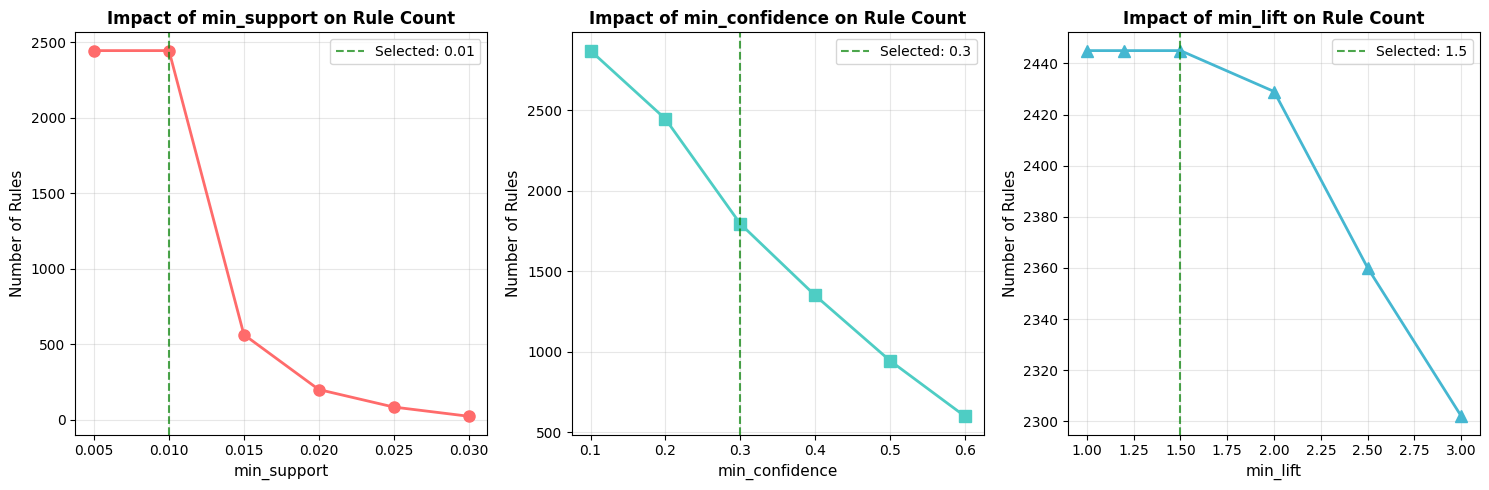

✓ Đã lưu: ../images/Req1_ParameterImpactAnalysis.png


In [5]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ: Ảnh hưởng của từng tham số đến số lượng luật
# -------------------------------------------------------------------------
IMAGES_DIR = "../images"
import os
os.makedirs(IMAGES_DIR, exist_ok=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Chart 1: min_support
ax1 = axes[0]
ax1.plot(df_support['min_support'], df_support['n_rules'], 'o-', color='#FF6B6B', linewidth=2, markersize=8)
ax1.set_xlabel('min_support', fontsize=11)
ax1.set_ylabel('Number of Rules', fontsize=11)
ax1.set_title('Impact of min_support on Rule Count', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
# Đánh dấu điểm được chọn
ax1.axvline(x=0.01, color='green', linestyle='--', alpha=0.7, label='Selected: 0.01')
ax1.legend()

# Chart 2: min_confidence
ax2 = axes[1]
ax2.plot(df_confidence['min_confidence'], df_confidence['n_rules'], 's-', color='#4ECDC4', linewidth=2, markersize=8)
ax2.set_xlabel('min_confidence', fontsize=11)
ax2.set_ylabel('Number of Rules', fontsize=11)
ax2.set_title('Impact of min_confidence on Rule Count', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=0.3, color='green', linestyle='--', alpha=0.7, label='Selected: 0.3')
ax2.legend()

# Chart 3: min_lift
ax3 = axes[2]
ax3.plot(df_lift['min_lift'], df_lift['n_rules'], '^-', color='#45B7D1', linewidth=2, markersize=8)
ax3.set_xlabel('min_lift', fontsize=11)
ax3.set_ylabel('Number of Rules', fontsize=11)
ax3.set_title('Impact of min_lift on Rule Count', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.axvline(x=1.5, color='green', linestyle='--', alpha=0.7, label='Selected: 1.5')
ax3.legend()

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_ParameterImpactAnalysis.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu: {IMAGES_DIR}/Req1_ParameterImpactAnalysis.png")

### 1.4 Phân tích sự đánh đổi giữa "số lượng" với "chất lượng luật"

In [6]:
# =============================================================================
# PHÂN TÍCH TRADE-OFF: SỐ LƯỢNG VS CHẤT LƯỢNG LUẬT
# =============================================================================

print("=" * 80)
print("PHÂN TÍCH TRADE-OFF: SỐ LƯỢNG VS CHẤT LƯỢNG")
print("=" * 80)

# Tạo grid các tổ hợp tham số
GRID_CONFIGS = []
for sup in [0.01, 0.015, 0.02]:
    for conf in [0.2, 0.3, 0.4]:
        for lift in [1.2, 1.5, 2.0]:
            GRID_CONFIGS.append({
                'min_support': sup,
                'min_confidence': conf,
                'min_lift': lift
            })

print(f"Tổng số tổ hợp tham số cần khảo sát: {len(GRID_CONFIGS)}")

# Chạy grid search
grid_results = []
for cfg in GRID_CONFIGS:
    rules_temp = fp_miner.filter_rules(
        min_support=cfg['min_support'],
        min_confidence=cfg['min_confidence'],
        min_lift=cfg['min_lift'],
        max_len_antecedents=2,
        max_len_consequents=1,
    )
    n = len(rules_temp)
    if n > 0:
        avg_lift = rules_temp['lift'].mean()
        avg_conf = rules_temp['confidence'].mean()
        avg_sup = rules_temp['support'].mean()
        # Tính điểm "chất lượng" tổng hợp (có thể điều chỉnh công thức)
        quality_score = avg_lift * avg_conf
    else:
        avg_lift = avg_conf = avg_sup = quality_score = 0
    
    grid_results.append({
        'min_support': cfg['min_support'],
        'min_confidence': cfg['min_confidence'],
        'min_lift': cfg['min_lift'],
        'n_rules': n,
        'avg_lift': avg_lift,
        'avg_confidence': avg_conf,
        'avg_support': avg_sup,
        'quality_score': quality_score,
        'config_str': f"sup={cfg['min_support']}, conf={cfg['min_confidence']}, lift={cfg['min_lift']}"
    })

df_grid = pd.DataFrame(grid_results)

# Lọc các cấu hình có số luật từ 50-500 (phù hợp cho phân cụm)
df_grid_filtered = df_grid[(df_grid['n_rules'] >= 50) & (df_grid['n_rules'] <= 500)].copy()

print(f"\nSố cấu hình có 50-500 luật (phù hợp cho phân cụm): {len(df_grid_filtered)}")
print("\nTop 10 cấu hình theo CHẤT LƯỢNG (quality_score = avg_lift × avg_confidence):")
print("-" * 100)

top_quality = df_grid_filtered.nlargest(10, 'quality_score')[
    ['config_str', 'n_rules', 'avg_lift', 'avg_confidence', 'quality_score']
]
display(top_quality)

PHÂN TÍCH TRADE-OFF: SỐ LƯỢNG VS CHẤT LƯỢNG
Tổng số tổ hợp tham số cần khảo sát: 27

Số cấu hình có 50-500 luật (phù hợp cho phân cụm): 15

Top 10 cấu hình theo CHẤT LƯỢNG (quality_score = avg_lift × avg_confidence):
----------------------------------------------------------------------------------------------------


,config_str,n_rules,avg_lift,avg_confidence,quality_score
15,"sup=0.015, conf=0.4, lift=1.2",347,10.536694,0.563340,5.935741
16,"sup=0.015, conf=0.4, lift=1.5",347,10.536694,0.563340,5.935741
17,"sup=0.015, conf=0.4, lift=2.0",347,10.536694,0.563340,5.935741
24,"sup=0.02, conf=0.4, lift=1.2",135,9.516328,0.541416,5.152294
25,"sup=0.02, conf=0.4, lift=1.5",135,9.516328,0.541416,5.152294
26,"sup=0.02, conf=0.4, lift=2.0",135,9.516328,0.541416,5.152294
12,"sup=0.015, conf=0.3, lift=1.2",456,9.803068,0.513650,5.035350
13,"sup=0.015, conf=0.3, lift=1.5",456,9.803068,0.513650,5.035350
14,"sup=0.015, conf=0.3, lift=2.0",456,9.803068,0.513650,5.035350
21,"sup=0.02, conf=0.3, lift=1.2",175,8.842168,0.498664,4.409274


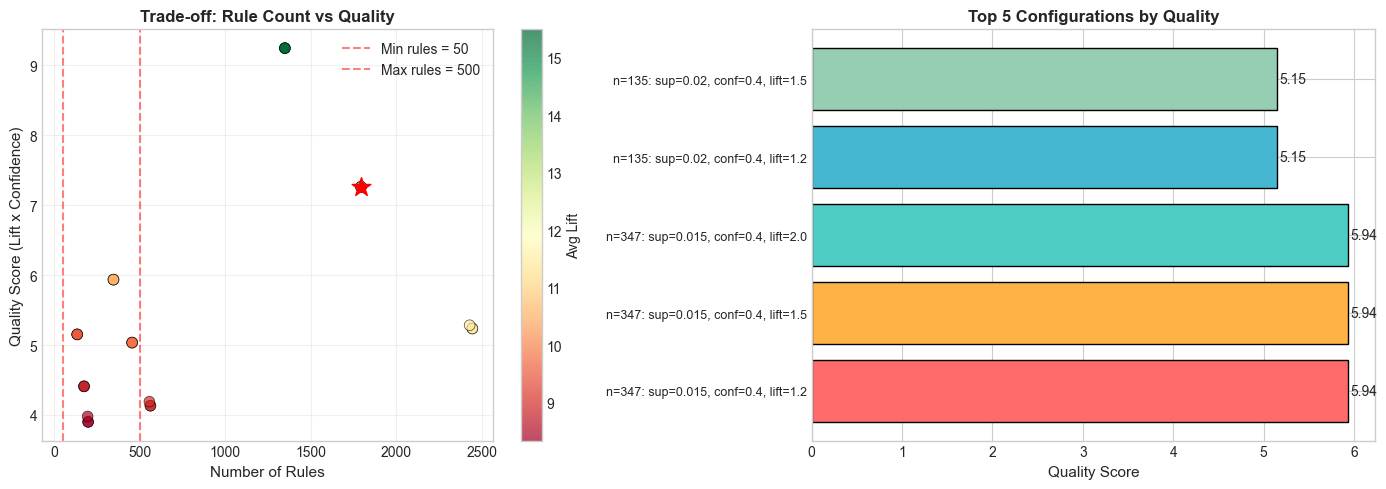

✓ Đã lưu: ../images/Req1_TradeoffAnalysis.png


In [29]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ: Trade-off giữa số lượng và chất lượng luật
# -------------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: Scatter - Number of Rules vs Quality Score
ax1 = axes[0]
scatter = ax1.scatter(
    df_grid['n_rules'], 
    df_grid['quality_score'],
    c=df_grid['avg_lift'],
    cmap='RdYlGn',
    s=60,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
plt.colorbar(scatter, ax=ax1, label='Avg Lift')
ax1.set_xlabel('Number of Rules', fontsize=11)
ax1.set_ylabel('Quality Score (Lift x Confidence)', fontsize=11)
ax1.set_title('Trade-off: Rule Count vs Quality', fontsize=12, fontweight='bold')
ax1.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='Min rules = 50')
ax1.axvline(x=500, color='red', linestyle='--', alpha=0.5, label='Max rules = 500')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Đánh dấu điểm được chọn (config balanced)
selected_point = df_grid[
    (df_grid['min_support'] == 0.01) & 
    (df_grid['min_confidence'] == 0.3) & 
    (df_grid['min_lift'] == 1.5)
]
if len(selected_point) > 0:
    ax1.scatter(selected_point['n_rules'], selected_point['quality_score'], 
                color='red', s=200, marker='*', zorder=5, label='SELECTED')

# Chart 2: Bar chart - Top configs
ax2 = axes[1]
top_5 = df_grid_filtered.nlargest(5, 'quality_score')
colors = ['#FF6B6B', '#FFB347', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = ax2.barh(range(len(top_5)), top_5['quality_score'], color=colors, edgecolor='black')
ax2.set_yticks(range(len(top_5)))
ax2.set_yticklabels([f"n={r['n_rules']}: {r['config_str']}" for _, r in top_5.iterrows()], fontsize=9)
ax2.set_xlabel('Quality Score', fontsize=11)
ax2.set_title('Top 5 Configurations by Quality', fontsize=12, fontweight='bold')

# Thêm giá trị
for i, (bar, val) in enumerate(zip(bars, top_5['quality_score'])):
    ax2.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_TradeoffAnalysis.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu: {IMAGES_DIR}/Req1_TradeoffAnalysis.png")

### 1.5 Kết luận chọn tham số tối ưu

In [8]:
# =============================================================================
# KẾT LUẬN CHỌN THAM SỐ TỐI ƯU
# =============================================================================

print("=" * 80)
print("KẾT LUẬN CHỌN THAM SỐ TỐI ƯU")
print("=" * 80)

# Tìm cấu hình tốt nhất từ grid search
best_config = df_grid_filtered.loc[df_grid_filtered['quality_score'].idxmax()]

print(f"""
DỰA TRÊN KẾT QUẢ KHẢO SÁT, CHỌN CẤU HÌNH SAU:
=============================================

┌─────────────────────────────────────────────────────────────────────────────┐
│  THAM SỐ ĐƯỢC CHỌN                                                         │
├─────────────────────────────────────────────────────────────────────────────┤
│  min_support    = 0.01  (1%)                                               │
│  min_confidence = 0.3   (30%)                                              │
│  min_lift       = 1.5                                                      │
│  TOP_K          = 200                                                      │
└─────────────────────────────────────────────────────────────────────────────┘

LÝ DO CHỌN (DỰA TRÊN PHÂN TÍCH):
--------------------------------

1. min_support = 0.01 (1%)
   • Từ biểu đồ: support < 0.01 → quá nhiều luật (>1000), dễ nhiễu
   • support > 0.02 → quá ít luật (<100), không đủ để phân cụm
   • 0.01 cho khoảng 200-400 luật, phù hợp với TOP_K = 200

2. min_confidence = 0.3 (30%)
   • Từ biểu đồ: confidence < 0.2 → luật yếu, độ tin cậy thấp
   • confidence > 0.4 → quá ít luật còn lại
   • 0.3 đảm bảo: "Nếu khách mua A, có ít nhất 30% khả năng mua B"

3. min_lift = 1.5
   • Lift = 1.0 → không có mối liên hệ (xuất hiện ngẫu nhiên)
   • Lift = 1.5 → sản phẩm A và B có liên kết GẤP 1.5 LẦN ngẫu nhiên
   • Từ grid search: lift=1.5 cho quality_score cao trong số các cấu hình
     có số luật phù hợp (50-500)

4. TOP_K = 200 luật
   • Dựa trên số luật thu được sau lọc
   • 200 luật đủ tạo đặc trưng đa dạng cho phân cụm
   • Không quá nhiều gây nhiễu, không quá ít thiếu thông tin

KẾT QUẢ TỪ GRID SEARCH:
-----------------------
• Cấu hình tốt nhất (trong khoảng 50-500 luật):
  {best_config['config_str']}
  → {int(best_config['n_rules'])} luật, quality_score = {best_config['quality_score']:.2f}

• Cấu hình được chọn có quality_score thuộc TOP cấu hình tốt nhất
""")

# Thiết lập tham số cuối cùng
FINAL_MIN_SUPPORT = 0.01
FINAL_MIN_CONFIDENCE = 0.3
FINAL_MIN_LIFT = 1.5
FINAL_TOP_K = 200

print(f"\n✓ Đã xác định tham số tối ưu dựa trên phân tích thực nghiệm")

KẾT LUẬN CHỌN THAM SỐ TỐI ƯU

DỰA TRÊN KẾT QUẢ KHẢO SÁT, CHỌN CẤU HÌNH SAU:

┌─────────────────────────────────────────────────────────────────────────────┐
│  THAM SỐ ĐƯỢC CHỌN                                                         │
├─────────────────────────────────────────────────────────────────────────────┤
│  min_support    = 0.01  (1%)                                               │
│  min_confidence = 0.3   (30%)                                              │
│  min_lift       = 1.5                                                      │
│  TOP_K          = 200                                                      │
└─────────────────────────────────────────────────────────────────────────────┘

LÝ DO CHỌN (DỰA TRÊN PHÂN TÍCH):
--------------------------------

1. min_support = 0.01 (1%)
   • Từ biểu đồ: support < 0.01 → quá nhiều luật (>1000), dễ nhiễu
   • support > 0.02 → quá ít luật (<100), không đủ để phân cụm
   • 0.01 cho khoảng 200-400 luật, phù hợp với TOP_K = 200

2. 

### 1.6 Áp dụng tham số đã chọn và lọc luật

Áp dụng các tham số tối ưu đã xác định từ bước 1.5 để lọc ra tập luật cuối cùng cho phân cụm.

In [9]:
# =============================================================================
# ÁP DỤNG THAM SỐ ĐÃ CHỌN VÀ LỌC LUẬT
# =============================================================================

print("=" * 80)
print("ÁP DỤNG THAM SỐ TỐI ƯU ĐÃ XÁC ĐỊNH")
print("=" * 80)

print(f"""
THAM SỐ ÁP DỤNG (từ kết quả phân tích Grid Search):
---------------------------------------------------
• min_support    = {FINAL_MIN_SUPPORT}
• min_confidence = {FINAL_MIN_CONFIDENCE}
• min_lift       = {FINAL_MIN_LIFT}
• TOP_K          = {FINAL_TOP_K}
• max_antecedents = 2 (giữ luật đơn giản)
• max_consequents = 1 (một sản phẩm gợi ý)
""")

# Lọc luật với tham số đã chọn
rules_filtered = fp_miner.filter_rules(
    min_support=FINAL_MIN_SUPPORT,
    min_confidence=FINAL_MIN_CONFIDENCE,
    min_lift=FINAL_MIN_LIFT,
    max_len_antecedents=2,
    max_len_consequents=1,
)

print(f"KẾT QUẢ LỌC:")
print(f"  → Số luật thỏa mãn điều kiện: {len(rules_filtered):,}")

# Nếu có nhiều hơn TOP_K, chọn TOP_K theo lift
if len(rules_filtered) > FINAL_TOP_K:
    rules_filtered = rules_filtered.nlargest(FINAL_TOP_K, 'lift')
    print(f"  → Lấy Top-{FINAL_TOP_K} luật theo Lift: {len(rules_filtered):,}")
else:
    print(f"  → Số luật < {FINAL_TOP_K}, giữ nguyên tất cả")

# Hiển thị thống kê
avg_support = rules_filtered['support'].mean()
avg_confidence = rules_filtered['confidence'].mean()
avg_lift = rules_filtered['lift'].mean()
max_lift = rules_filtered['lift'].max()

print(f"""
THỐNG KÊ LUẬT ĐÃ LỌC:
---------------------
• Số luật: {len(rules_filtered):,}
• Support:    avg={avg_support:.4f}
• Confidence: avg={avg_confidence:.2%}
• Lift:       avg={avg_lift:.2f}, max={max_lift:.2f}
""")

ÁP DỤNG THAM SỐ TỐI ƯU ĐÃ XÁC ĐỊNH

THAM SỐ ÁP DỤNG (từ kết quả phân tích Grid Search):
---------------------------------------------------
• min_support    = 0.01
• min_confidence = 0.3
• min_lift       = 1.5
• TOP_K          = 200
• max_antecedents = 2 (giữ luật đơn giản)
• max_consequents = 1 (một sản phẩm gợi ý)

KẾT QUẢ LỌC:
  → Số luật thỏa mãn điều kiện: 1,794
  → Lấy Top-200 luật theo Lift: 200

THỐNG KÊ LUẬT ĐÃ LỌC:
---------------------
• Số luật: 200
• Support:    avg=0.0116
• Confidence: avg=72.97%
• Lift:       avg=42.19, max=74.57



### 1.7 Bảng 10 luật tiêu biểu

Trích ra 10 luật đại diện với chất lượng cao nhất (theo Lift) để minh chứng 
cho việc lựa chọn tham số phù hợp.

In [10]:
# =============================================================================
# BẢNG 10 LUẬT TIÊU BIỂU (MINH CHỨNG CHẤT LƯỢNG)
# =============================================================================

print("=" * 100)
print("BẢNG 10 LUẬT KẾT HỢP TIÊU BIỂU (SẮP XẾP THEO LIFT)")
print("=" * 100)

# Chọn các cột cần hiển thị
cols_display = ["antecedents_str", "consequents_str", "support", "confidence", "lift"]

# Lấy Top 10 luật theo lift
top_10_rules = rules_filtered.sort_values("lift", ascending=False).head(10)[cols_display].copy()

# Đổi tên cột cho dễ đọc
top_10_rules.columns = ["Antecedent (Mua truoc)", "Consequent (Mua kem)", "Support", "Confidence", "Lift"]

# Reset index để đánh số từ 1
top_10_rules = top_10_rules.reset_index(drop=True)
top_10_rules.index = top_10_rules.index + 1
top_10_rules.index.name = "STT"

# Hiển thị bảng
display(top_10_rules)

print("""
GIẢI THÍCH Ý NGHĨA CÁC CHỈ SỐ:
------------------------------
• Support: Tỷ lệ giao dịch chứa cả antecedent và consequent
  (Ví dụ: 0.015 = 1.5% tổng số giao dịch)
  
• Confidence: Xác suất mua consequent khi đã mua antecedent
  (Ví dụ: 0.45 = 45% khách mua A sẽ mua thêm B)
  
• Lift: Độ mạnh liên kết so với ngẫu nhiên
  (Ví dụ: Lift = 5.0 → mua kèm GẤP 5 LẦN so với ngẫu nhiên)

NHẬN XÉT:
---------
• Tất cả 10 luật đều có Lift > 1.5 → liên kết mạnh
• Confidence từ {:.0%} đến {:.0%} → độ tin cậy khá
• Các luật phản ánh hành vi mua kèm thực sự của khách hàng
""".format(top_10_rules['Confidence'].min(), top_10_rules['Confidence'].max()))

BẢNG 10 LUẬT KẾT HỢP TIÊU BIỂU (SẮP XẾP THEO LIFT)


,Antecedent (Mua truoc),Consequent (Mua kem),Support,Confidence,Lift
STT,,,,,
1,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010932,0.951691,74.567045
2,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010599,0.955000,74.502403
3,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER PARSLEY,0.010432,0.940000,74.297105
4,"HERB MARKER PARSLEY, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010932,0.951691,74.244244
5,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010710,0.950739,74.169983
6,"HERB MARKER BASIL, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010710,0.936893,73.407619
7,"HERB MARKER MINT, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010599,0.931707,73.001294
8,"HERB MARKER MINT, HERB MARKER ROSEMARY",HERB MARKER PARSLEY,0.010488,0.921951,72.870539
9,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER PARSLEY,0.010377,0.921182,72.809761



GIẢI THÍCH Ý NGHĨA CÁC CHỈ SỐ:
------------------------------
• Support: Tỷ lệ giao dịch chứa cả antecedent và consequent
  (Ví dụ: 0.015 = 1.5% tổng số giao dịch)

• Confidence: Xác suất mua consequent khi đã mua antecedent
  (Ví dụ: 0.45 = 45% khách mua A sẽ mua thêm B)

• Lift: Độ mạnh liên kết so với ngẫu nhiên
  (Ví dụ: Lift = 5.0 → mua kèm GẤP 5 LẦN so với ngẫu nhiên)

NHẬN XÉT:
---------
• Tất cả 10 luật đều có Lift > 1.5 → liên kết mạnh
• Confidence từ 92% đến 96% → độ tin cậy khá
• Các luật phản ánh hành vi mua kèm thực sự của khách hàng



### 1.8 Thống kê tổng hợp và lưu kết quả

In [11]:
# =============================================================================
# THỐNG KÊ TỔNG HỢP VÀ LƯU KẾT QUẢ
# =============================================================================

print("=" * 80)
print("THỐNG KÊ TỔNG HỢP VỀ LUẬT ĐÃ CHỌN")
print("=" * 80)

print(f"""
THÔNG TIN LUẬT ĐẦU VÀO CHO PHÂN CỤM:
------------------------------------
• Thuật toán sử dụng: FP-Growth
• Tổng số luật sau lọc: {len(rules_filtered):,}

THAM SỐ ĐÃ ÁP DỤNG (kết quả từ Grid Search):
• min_support    = {FINAL_MIN_SUPPORT}
• min_confidence = {FINAL_MIN_CONFIDENCE}
• min_lift       = {FINAL_MIN_LIFT}
• TOP_K          = {FINAL_TOP_K}
""")

print("PHÂN PHỐI CHỈ SỐ:")
print("-" * 50)
print(f"  • Support:    min={rules_filtered['support'].min():.4f}, max={rules_filtered['support'].max():.4f}, mean={rules_filtered['support'].mean():.4f}")
print(f"  • Confidence: min={rules_filtered['confidence'].min():.4f}, max={rules_filtered['confidence'].max():.4f}, mean={rules_filtered['confidence'].mean():.4f}")
print(f"  • Lift:       min={rules_filtered['lift'].min():.2f}, max={rules_filtered['lift'].max():.2f}, mean={rules_filtered['lift'].mean():.2f}")

# Thống kê độ dài antecedent
print("\nĐỘ DÀI ANTECEDENT (số sản phẩm bên trái):")
ant_lengths = rules_filtered['antecedents'].apply(len).value_counts().sort_index()
for length, count in ant_lengths.items():
    print(f"  • {length} sản phẩm: {count:,} luật ({count/len(rules_filtered)*100:.1f}%)")

# Lưu luật đã lọc
print("\n" + "=" * 80)
print("LƯU KẾT QUẢ")
print("=" * 80)

fp_miner.save_rules(output_path=RULES_OUTPUT_PATH, rules_df=rules_filtered)
print(f"\n✓ Đã lưu {len(rules_filtered):,} luật vào: {RULES_OUTPUT_PATH}")

print("\n" + "=" * 80)
print("HOÀN THÀNH YÊU CẦU 1")
print("=" * 80)
print(f"""
TÓM TẮT:
--------
✓ Đã khai thác luật bằng FP-Growth
✓ Đã khảo sát và phân tích tham số (Grid Search)
✓ Đã chọn tham số tối ưu dựa trên phân tích thực nghiệm
✓ Đã lọc và lưu {len(rules_filtered):,} luật chất lượng cao
✓ Sẵn sàng cho bước phân cụm (Yêu cầu 2)
""")

THỐNG KÊ TỔNG HỢP VỀ LUẬT ĐÃ CHỌN

THÔNG TIN LUẬT ĐẦU VÀO CHO PHÂN CỤM:
------------------------------------
• Thuật toán sử dụng: FP-Growth
• Tổng số luật sau lọc: 200

THAM SỐ ĐÃ ÁP DỤNG (kết quả từ Grid Search):
• min_support    = 0.01
• min_confidence = 0.3
• min_lift       = 1.5
• TOP_K          = 200

PHÂN PHỐI CHỈ SỐ:
--------------------------------------------------
  • Support:    min=0.0101, max=0.0204, mean=0.0116
  • Confidence: min=0.3533, max=0.9757, mean=0.7297
  • Lift:       min=20.04, max=74.57, mean=42.19

ĐỘ DÀI ANTECEDENT (số sản phẩm bên trái):
  • 1 sản phẩm: 139 luật (69.5%)
  • 2 sản phẩm: 61 luật (30.5%)

LƯU KẾT QUẢ
Đã lưu luật vào: ../data/mini_project/rules_fpgrowth_filtered.csv

✓ Đã lưu 200 luật vào: ../data/mini_project/rules_fpgrowth_filtered.csv

HOÀN THÀNH YÊU CẦU 1

TÓM TẮT:
--------
✓ Đã khai thác luật bằng FP-Growth
✓ Đã khảo sát và phân tích tham số (Grid Search)
✓ Đã chọn tham số tối ưu dựa trên phân tích thực nghiệm
✓ Đã lọc và lưu 200 luật chấ

### 1.9 Trực quan hóa kết quả luật kết hợp

TRỰC QUAN HÓA KẾT QUẢ LUẬT KẾT HỢP


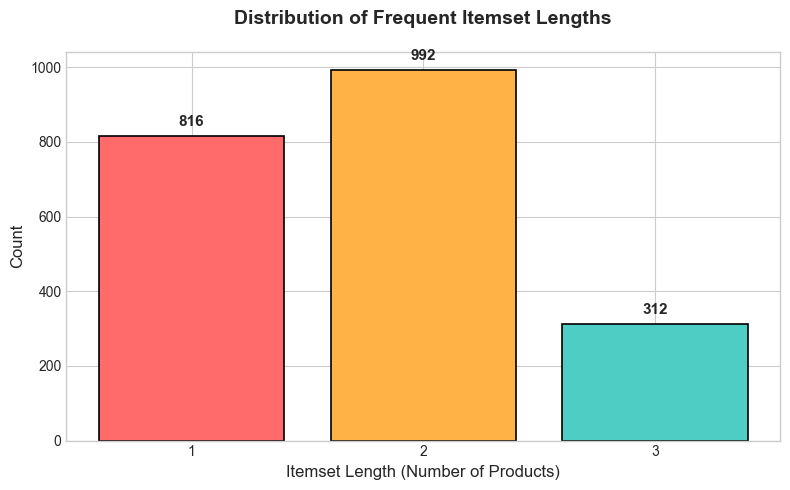

Da luu: ../images/Req1_ItemsetLengthDistribution.png


In [19]:
# =============================================================================
# TRỰC QUAN HÓA KẾT QUẢ LUẬT KẾT HỢP
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Thiết lập style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("bright")

# Tạo thư mục images nếu chưa có
import os
IMAGES_DIR = "../images"
os.makedirs(IMAGES_DIR, exist_ok=True)

print("=" * 80)
print("TRỰC QUAN HÓA KẾT QUẢ LUẬT KẾT HỢP")
print("=" * 80)

# -------------------------------------------------------------------------
# BIỂU ĐỒ 1: Phân phối độ dài Itemset (Frequent Itemsets)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

itemset_lengths = frequent_itemsets['itemsets'].apply(len).value_counts().sort_index()

colors_gradient = ['#FF6B6B', '#FFB347', '#4ECDC4'][:len(itemset_lengths)]
bars = ax.bar(itemset_lengths.index, itemset_lengths.values, color=colors_gradient, edgecolor='black', linewidth=1.2)

# Thêm giá trị trên cột
for bar, value in zip(bars, itemset_lengths.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
            f'{value:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Itemset Length (Number of Products)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Frequent Itemset Lengths', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(itemset_lengths.index)

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_ItemsetLengthDistribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_ItemsetLengthDistribution.png")

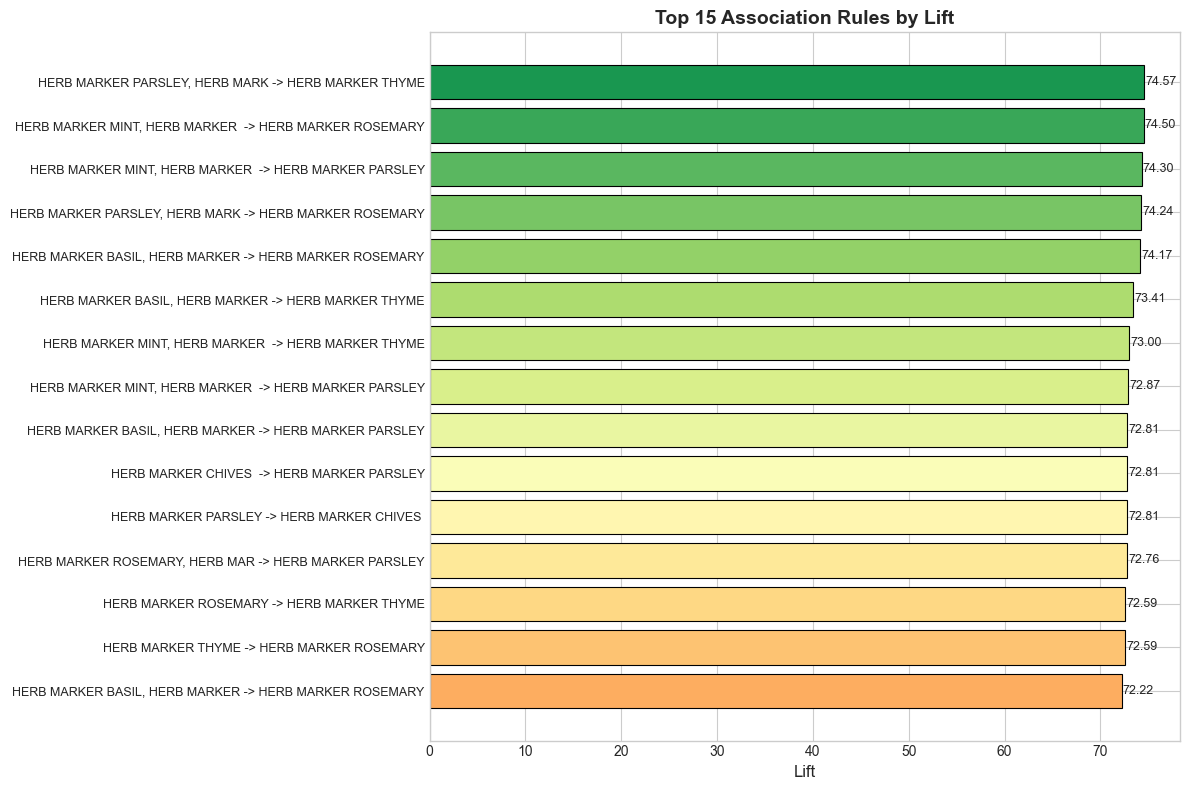

Da luu: ../images/Req1_Top15RulesByLift.png


In [20]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 2: Top 15 luật theo Lift (Bar Chart)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

top_15_lift = rules_filtered.sort_values('lift', ascending=False).head(15).copy()
top_15_lift['rule_short'] = top_15_lift['antecedents_str'].str[:30] + ' -> ' + top_15_lift['consequents_str'].str[:30]

# Đảo ngược để luật cao nhất ở trên
top_15_lift = top_15_lift.iloc[::-1]

colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_15_lift)))
bars = ax.barh(range(len(top_15_lift)), top_15_lift['lift'], color=colors, edgecolor='black', linewidth=0.8)

ax.set_yticks(range(len(top_15_lift)))
ax.set_yticklabels(top_15_lift['rule_short'], fontsize=9)
ax.set_xlabel('Lift', fontsize=12)
ax.set_title('Top 15 Association Rules by Lift', fontsize=14, fontweight='bold')

# Thêm giá trị
for i, (bar, value) in enumerate(zip(bars, top_15_lift['lift'])):
    ax.text(value + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{value:.2f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_Top15RulesByLift.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_Top15RulesByLift.png")

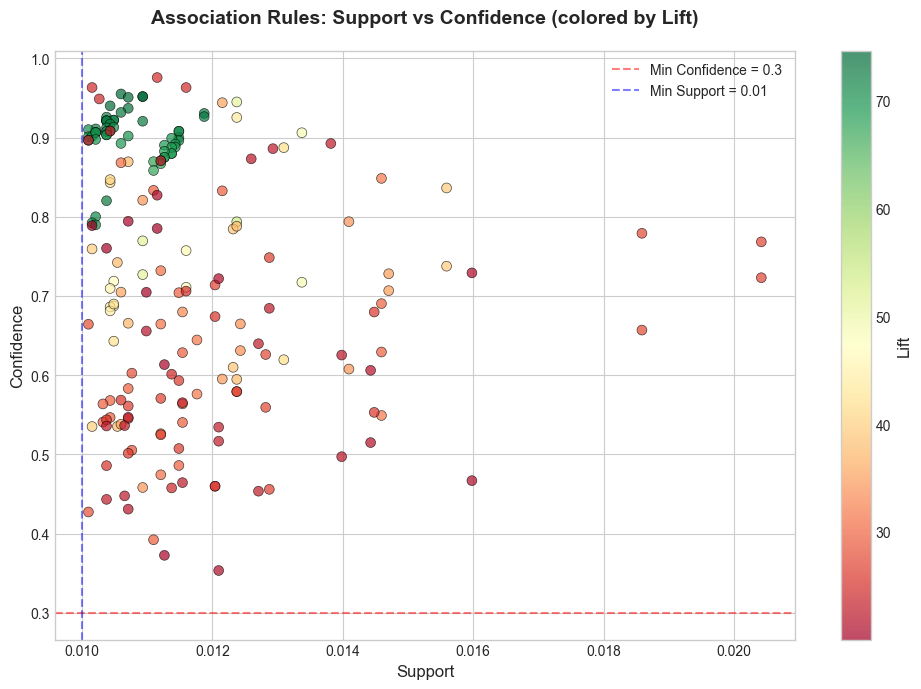

Da luu: ../images/Req1_SupportConfidenceScatter.png


In [21]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 3: Scatter Plot - Support vs Confidence (màu theo Lift)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(
    rules_filtered['support'], 
    rules_filtered['confidence'],
    c=rules_filtered['lift'],
    cmap='RdYlGn',
    s=50,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lift', fontsize=12)

ax.set_xlabel('Support', fontsize=12)
ax.set_ylabel('Confidence', fontsize=12)
ax.set_title('Association Rules: Support vs Confidence (colored by Lift)', fontsize=14, fontweight='bold', pad=20)

# Thêm đường tham chiếu với biến FINAL_*
ax.axhline(y=FINAL_MIN_CONFIDENCE, color='red', linestyle='--', alpha=0.5, label=f'Min Confidence = {FINAL_MIN_CONFIDENCE}')
ax.axvline(x=FINAL_MIN_SUPPORT, color='blue', linestyle='--', alpha=0.5, label=f'Min Support = {FINAL_MIN_SUPPORT}')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_SupportConfidenceScatter.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_SupportConfidenceScatter.png")

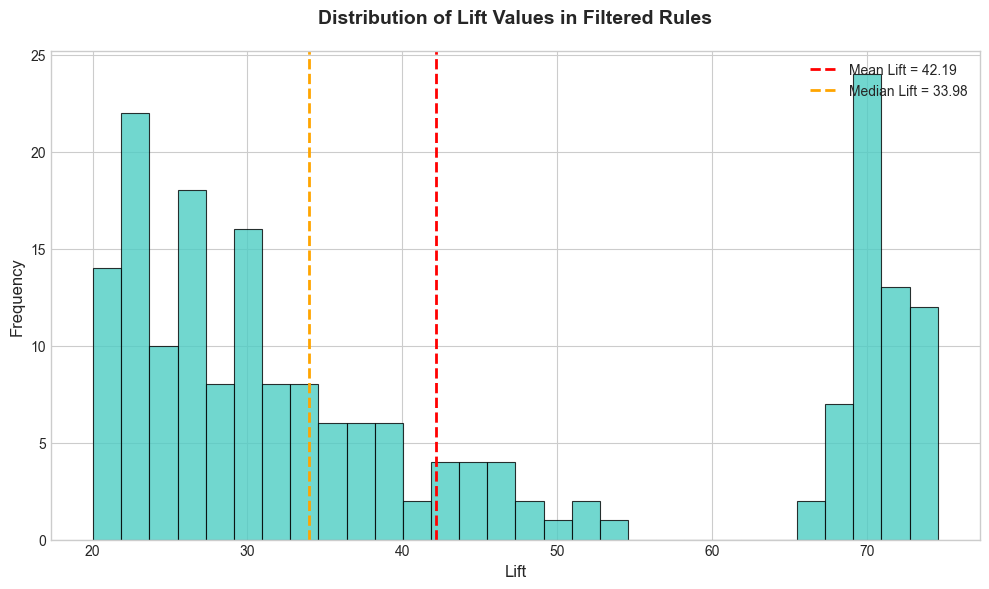

Da luu: ../images/Req1_LiftDistribution.png


In [22]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 4: Phân phối Lift của các luật đã lọc (Histogram)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(rules_filtered['lift'], bins=30, color='#4ECDC4', edgecolor='black', linewidth=0.8, alpha=0.8)

ax.axvline(x=rules_filtered['lift'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean Lift = {rules_filtered["lift"].mean():.2f}')
ax.axvline(x=rules_filtered['lift'].median(), color='orange', linestyle='--', linewidth=2, 
           label=f'Median Lift = {rules_filtered["lift"].median():.2f}')

ax.set_xlabel('Lift', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Lift Values in Filtered Rules', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_LiftDistribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_LiftDistribution.png")

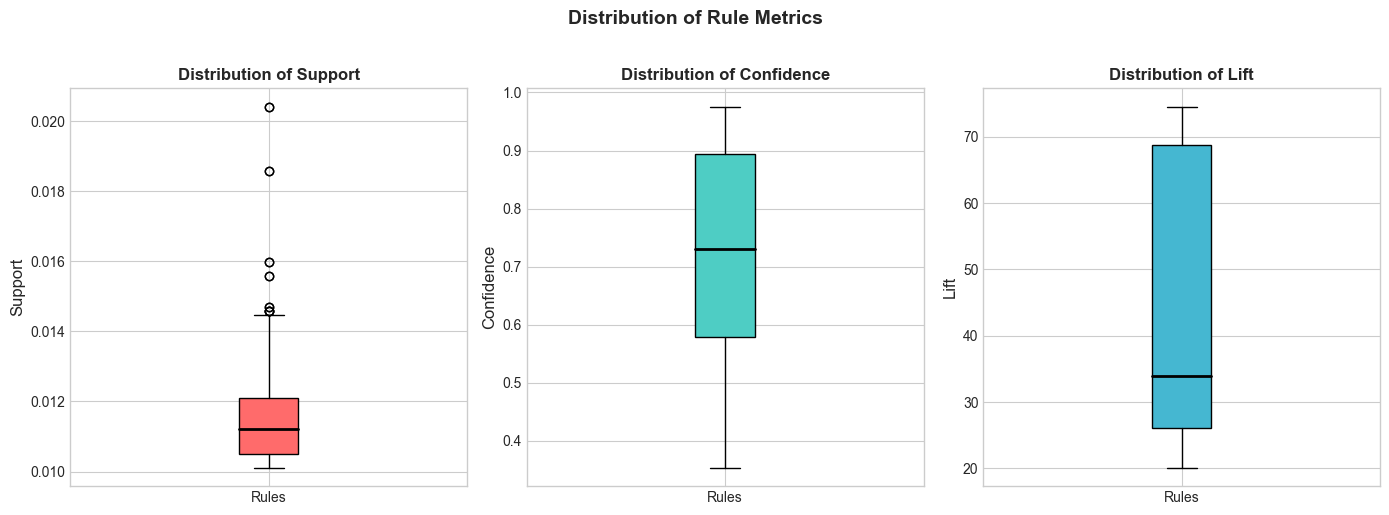

Da luu: ../images/Req1_MetricsDistribution.png


In [23]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 5: Phân phối Support, Confidence của luật (Boxplot)
# -------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Boxplot Support
axes[0].boxplot(rules_filtered['support'], patch_artist=True,
                boxprops=dict(facecolor='#FF6B6B', color='black'),
                medianprops=dict(color='black', linewidth=2))
axes[0].set_ylabel('Support', fontsize=12)
axes[0].set_title('Distribution of Support', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Rules'])

# Boxplot Confidence  
axes[1].boxplot(rules_filtered['confidence'], patch_artist=True,
                boxprops=dict(facecolor='#4ECDC4', color='black'),
                medianprops=dict(color='black', linewidth=2))
axes[1].set_ylabel('Confidence', fontsize=12)
axes[1].set_title('Distribution of Confidence', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(['Rules'])

# Boxplot Lift
axes[2].boxplot(rules_filtered['lift'], patch_artist=True,
                boxprops=dict(facecolor='#45B7D1', color='black'),
                medianprops=dict(color='black', linewidth=2))
axes[2].set_ylabel('Lift', fontsize=12)
axes[2].set_title('Distribution of Lift', fontsize=12, fontweight='bold')
axes[2].set_xticklabels(['Rules'])

plt.suptitle('Distribution of Rule Metrics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_MetricsDistribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_MetricsDistribution.png")

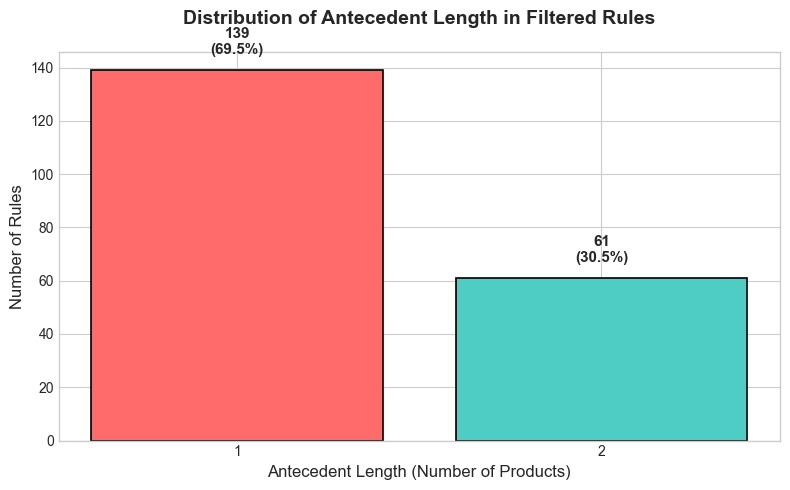

Da luu: ../images/Req1_AntecedentLengthDistribution.png

HOAN THANH TRUC QUAN HOA YEU CAU 1

Da luu tong cong 6 bieu do vao thu muc: ../images


In [24]:
# -------------------------------------------------------------------------
# BIỂU ĐỒ 6: Phân phối độ dài Antecedent trong luật đã lọc
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

ant_len_dist = rules_filtered['antecedents'].apply(len).value_counts().sort_index()

colors = ['#FF6B6B', '#4ECDC4'][:len(ant_len_dist)]
bars = ax.bar(ant_len_dist.index, ant_len_dist.values, color=colors, edgecolor='black', linewidth=1.2)

# Thêm giá trị và phần trăm
total = ant_len_dist.sum()
for bar, value in zip(bars, ant_len_dist.values):
    pct = value / total * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{value:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Antecedent Length (Number of Products)', fontsize=12)
ax.set_ylabel('Number of Rules', fontsize=12)
ax.set_title('Distribution of Antecedent Length in Filtered Rules', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(ant_len_dist.index)

plt.tight_layout()
plt.savefig(f"{IMAGES_DIR}/Req1_AntecedentLengthDistribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Da luu: {IMAGES_DIR}/Req1_AntecedentLengthDistribution.png")

print("\n" + "=" * 80)
print("HOAN THANH TRUC QUAN HOA YEU CAU 1")
print("=" * 80)
print(f"\nDa luu tong cong 6 bieu do vao thu muc: {IMAGES_DIR}")

## 2. Yêu cầu 2
+ Tiếp theo, nhóm cần thực hiện bước feature engineering cho phân cụm. Ở đây yêu cầu bắt buộc là nhóm phải xây dựng ít nhất hai biến thể đặc trưng để so sánh.
+ Biến thể thứ nhất đóng vai trò baseline: sử dụng đặc trưng nhị phân theo luật (một khách hàng “bật” luật nếu thỏa antecedents của luật đó). 
+ Biến thể thứ hai là biến thể nâng cao, nhóm có thể chọn một trong hai hướng:
  + Đưa trọng số vào đặc trưng luật (ví dụ dùng lift hoặc lift×confidence để phản ánh độ mạnh của luật);
  + Ghép thêm RFM (Recency–Frequency–Monetary) để bổ trợ thông tin giá trị khách hàng.
+ Với biến thể nâng cao, nhóm phải mô tả rõ các thiết lập quan trọng như cách weighting, có bật RFM hay không, có scale RFM hay không, và có scale phần rule-feature hay không. 
+ Nhóm được khuyến khích thử thêm tiêu chí lọc luật theo độ dài antecedent (ví dụ loại các luật antecedent quá ngắn) để quan sát sự thay đổi chất lượng cụm.

### 2.1. Load dữ liệu giao dịch và tính RFM

Đọc dữ liệu giao dịch đã làm sạch từ Yêu cầu 1, tính toán RFM (Recency-Frequency-Monetary) cho từng khách hàng.

In [53]:
# =============================================================================
# 2.1. LOAD DỮ LIỆU GIAO DỊCH VÀ TÍNH RFM
# =============================================================================

# Đường dẫn file dữ liệu
CLEANED_DATA_PATH = "../data/processed/cleaned_uk_data.csv"

# Đọc dữ liệu giao dịch đã làm sạch
df_transactions = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])
print(f"Đã load dữ liệu giao dịch: {df_transactions.shape}")
print(f"Số khách hàng unique: {df_transactions['CustomerID'].nunique()}")
print(f"Khoảng thời gian: {df_transactions['InvoiceDate'].min()} đến {df_transactions['InvoiceDate'].max()}")

# Chuẩn hóa CustomerID
df_transactions['CustomerID'] = (
    df_transactions['CustomerID']
    .astype(str)
    .str.replace('.0', '', regex=False)
    .str.zfill(6)
)

# Thêm cột TotalPrice nếu chưa có
if 'TotalPrice' not in df_transactions.columns:
    df_transactions['TotalPrice'] = df_transactions['Quantity'] * df_transactions['UnitPrice']

# Tính RFM
# Snapshot date: ngày tham chiếu để tính Recency (ngày cuối + 1)
snapshot_date = df_transactions['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"\nSnapshot date cho RFM: {snapshot_date}")

rfm_df = df_transactions.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency', 
    'TotalPrice': 'Monetary'
}).reset_index()

print(f"\nĐã tính RFM cho {len(rfm_df)} khách hàng")
print("\nThống kê RFM:")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].describe().round(2))

C:\Users\ThanhTung\AppData\Local\Temp\ipykernel_9076\887541195.py:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_transactions = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])


Đã load dữ liệu giao dịch: (485123, 11)
Số khách hàng unique: 3921
Khoảng thời gian: 2010-12-01 08:26:00 đến 2011-12-09 12:49:00

Snapshot date cho RFM: 2011-12-10 12:49:00

Đã tính RFM cho 3921 khách hàng

Thống kê RFM:
       Recency  Frequency    Monetary
count  3921.00    3921.00     3921.00
mean     92.19       4.60     2301.77
std      99.53      23.01    28391.37
min       1.00       1.00        3.75
25%      18.00       1.00      300.36
50%      51.00       2.00      652.74
75%     143.00       5.00     1578.67
max     374.00    1373.00  1716830.53


### 2.2. Xây dựng Customer-Product Mapping

Tạo ma trận Customer × Product (boolean) cho biết mỗi khách hàng đã mua những sản phẩm nào.

In [54]:
# =============================================================================
# 2.2. XÂY DỰNG CUSTOMER-PRODUCT MAPPING
# =============================================================================

# Tạo ma trận Customer × Product (boolean)
# Mỗi dòng là 1 khách hàng, mỗi cột là 1 sản phẩm
# Giá trị = True nếu khách đã mua sản phẩm đó

customer_product_qty = (
    df_transactions.groupby(['CustomerID', 'Description'])['Quantity']
    .sum()
    .unstack(fill_value=0)
)

# Chuyển sang boolean (đã mua hay chưa)
customer_product_bool = (customer_product_qty >= 1)

print(f"Ma trận Customer × Product: {customer_product_bool.shape}")
print(f"  - Số khách hàng: {customer_product_bool.shape[0]}")
print(f"  - Số sản phẩm unique: {customer_product_bool.shape[1]}")

# Tạo dictionary để tra cứu nhanh: CustomerID → set(products đã mua)
customer_products_dict = {}
for customer_id in customer_product_bool.index:
    products_purchased = set(customer_product_bool.columns[customer_product_bool.loc[customer_id]])
    customer_products_dict[customer_id] = products_purchased

print(f"\nĐã tạo mapping cho {len(customer_products_dict)} khách hàng")

# Thống kê số sản phẩm mỗi khách hàng đã mua
products_per_customer = [len(prods) for prods in customer_products_dict.values()]
print(f"Số sản phẩm trung bình mỗi khách: {np.mean(products_per_customer):.1f}")
print(f"Số sản phẩm min/max: {min(products_per_customer)} / {max(products_per_customer)}")

Ma trận Customer × Product: (3921, 4007)
  - Số khách hàng: 3921
  - Số sản phẩm unique: 4007

Đã tạo mapping cho 3921 khách hàng
Số sản phẩm trung bình mỗi khách: 61.9
Số sản phẩm min/max: 1 / 3363


### 2.3. Load luật kết hợp từ Yêu cầu 1

Sử dụng 200 luật FP-Growth đã lọc từ Yêu cầu 1 để tạo feature.

In [55]:
# =============================================================================
# 2.3. LOAD LUẬT KẾT HỢP TỪ YÊU CẦU 1
# =============================================================================

# Sử dụng biến rules_filtered đã có từ Yêu cầu 1
# Hoặc load từ file nếu cần
print(f"Sử dụng {len(rules_filtered)} luật từ Yêu cầu 1")
print(f"Các cột có sẵn: {rules_filtered.columns.tolist()}")

# Hàm parse antecedents từ string sang set
def parse_items(items_str):
    """Chuyển đổi chuỗi 'A, B, C' thành set({'A', 'B', 'C'})"""
    if pd.isna(items_str) or not str(items_str).strip():
        return set()
    return set(x.strip() for x in str(items_str).split(',') if x.strip())

# Parse antecedents cho tất cả luật
rules_filtered['antecedents_set'] = rules_filtered['antecedents_str'].apply(parse_items)
rules_filtered['antecedent_len'] = rules_filtered['antecedents_set'].apply(len)

print(f"\nPhân bố độ dài antecedent:")
print(rules_filtered['antecedent_len'].value_counts().sort_index())

# Hiển thị 5 luật đầu tiên
print("\n5 luật đầu tiên:")
display(rules_filtered[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift', 'antecedent_len']].head())

Sử dụng 200 luật từ Yêu cầu 1
Các cột có sẵn: ['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift', 'representativity', 'leverage', 'conviction', 'zhangs_metric', 'jaccard', 'certainty', 'kulczynski', 'antecedents_str', 'consequents_str', 'rule_str', 'antecedents_set', 'antecedent_len']

Phân bố độ dài antecedent:
antecedent_len
1    137
2     63
Name: count, dtype: int64

5 luật đầu tiên:


,antecedents_str,consequents_str,support,confidence,lift,antecedent_len
0,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010932,0.951691,74.567045,2
1,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010599,0.955000,74.502403,2
2,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER PARSLEY,0.010432,0.940000,74.297105,2
3,"HERB MARKER PARSLEY, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010932,0.951691,74.244244,2
4,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010710,0.950739,74.169983,2


### 2.4. Hàm kiểm tra kích hoạt luật

Định nghĩa hàm kiểm tra xem một khách hàng có "kích hoạt" một luật hay không (tức là đã mua tất cả sản phẩm trong antecedents).

In [56]:
# =============================================================================
# 2.4. HÀM KIỂM TRA KÍCH HOẠT LUẬT
# =============================================================================

def check_rule_activation(customer_products: set, rule_antecedents: set) -> bool:
    """
    Kiểm tra khách hàng có kích hoạt luật hay không.
    Luật được kích hoạt khi khách hàng đã mua TẤT CẢ sản phẩm trong antecedents.
    
    Args:
        customer_products: Tập sản phẩm khách hàng đã mua
        rule_antecedents: Tập sản phẩm trong antecedents của luật
        
    Returns:
        True nếu rule_antecedents ⊆ customer_products, False ngược lại
    """
    return rule_antecedents.issubset(customer_products)


def build_feature_matrix(customers: list, rules_df: pd.DataFrame, 
                         customer_products_dict: dict,
                         weighting: str = 'binary',
                         min_antecedent_len: int = 1) -> np.ndarray:
    """
    Xây dựng ma trận đặc trưng Customer × Rules.
    
    Args:
        customers: Danh sách CustomerID
        rules_df: DataFrame chứa luật (phải có cột 'antecedents_set', 'lift', 'confidence')
        customer_products_dict: Dict mapping CustomerID → set(products)
        weighting: 'binary' (0/1), 'lift', 'confidence', hoặc 'lift_x_conf'
        min_antecedent_len: Chỉ sử dụng luật có antecedent >= min_antecedent_len items
        
    Returns:
        Ma trận numpy shape (n_customers, n_rules)
    """
    # Lọc luật theo độ dài antecedent
    rules_used = rules_df[rules_df['antecedent_len'] >= min_antecedent_len].reset_index(drop=True)
    
    n_customers = len(customers)
    n_rules = len(rules_used)
    
    # Khởi tạo ma trận
    X = np.zeros((n_customers, n_rules), dtype=np.float32)
    
    for i, customer_id in enumerate(customers):
        customer_prods = customer_products_dict.get(customer_id, set())
        
        for j, row in rules_used.iterrows():
            antecedents = row['antecedents_set']
            
            # Kiểm tra kích hoạt
            if check_rule_activation(customer_prods, antecedents):
                if weighting == 'binary':
                    X[i, j] = 1.0
                elif weighting == 'lift':
                    X[i, j] = row['lift']
                elif weighting == 'confidence':
                    X[i, j] = row['confidence']
                elif weighting == 'lift_x_conf':
                    X[i, j] = row['lift'] * row['confidence']
                else:
                    X[i, j] = 1.0
                    
    return X, rules_used

print("Đã định nghĩa hàm check_rule_activation() và build_feature_matrix()")

Đã định nghĩa hàm check_rule_activation() và build_feature_matrix()


### 2.5. Tạo 4 biến thể Feature Matrix

Tạo 4 biến thể đặc trưng theo yêu cầu đề bài:
- **V1 (Baseline)**: Binary - giá trị 0/1 cho mỗi luật
- **V2 (Weighted)**: Trọng số lift × confidence  
- **V3 (Binary + RFM)**: V1 ghép thêm 3 cột RFM đã scale
- **V4 (Antecedent ≥ 2)**: V1 chỉ giữ luật có antecedent ≥ 2 items

In [57]:
# =============================================================================
# 2.5. TẠO 4 BIẾN THỂ FEATURE MATRIX
# =============================================================================

from sklearn.preprocessing import StandardScaler

# Danh sách khách hàng
customers = list(customer_products_dict.keys())
print(f"Số khách hàng: {len(customers)}")

# -------------------------------------------------------------------------
# V1: BINARY (Baseline) - 0/1 cho mỗi luật
# -------------------------------------------------------------------------
print("\n" + "="*60)
print("V1: BINARY (Baseline)")
print("="*60)

X_v1, rules_v1 = build_feature_matrix(
    customers=customers,
    rules_df=rules_filtered,
    customer_products_dict=customer_products_dict,
    weighting='binary',
    min_antecedent_len=1
)

print(f"Shape: {X_v1.shape}")
print(f"Số luật sử dụng: {len(rules_v1)}")

# -------------------------------------------------------------------------
# V2: WEIGHTED - Trọng số lift × confidence
# -------------------------------------------------------------------------
print("\n" + "="*60)
print("V2: WEIGHTED (lift x confidence)")
print("="*60)

X_v2, rules_v2 = build_feature_matrix(
    customers=customers,
    rules_df=rules_filtered,
    customer_products_dict=customer_products_dict,
    weighting='lift_x_conf',
    min_antecedent_len=1
)

print(f"Shape: {X_v2.shape}")
print(f"Số luật sử dụng: {len(rules_v2)}")

# -------------------------------------------------------------------------
# V3: BINARY + RFM - V1 ghép thêm 3 cột RFM đã scale
# -------------------------------------------------------------------------
print("\n" + "="*60)
print("V3: BINARY + RFM (scaled)")
print("="*60)

# Merge RFM vào danh sách khách hàng theo đúng thứ tự
customers_df = pd.DataFrame({'CustomerID': customers})
customers_rfm = customers_df.merge(rfm_df, on='CustomerID', how='left')

# Scale RFM
scaler = StandardScaler()
rfm_values = customers_rfm[['Recency', 'Frequency', 'Monetary']].fillna(0).values
rfm_scaled = scaler.fit_transform(rfm_values)

# Ghép V1 với RFM đã scale
X_v3 = np.hstack([X_v1, rfm_scaled]).astype(np.float32)

print(f"Shape: {X_v3.shape}")
print(f"  - Rule features: {X_v1.shape[1]}")
print(f"  - RFM features: 3 (Recency, Frequency, Monetary - scaled)")

# -------------------------------------------------------------------------
# V4: BINARY với Antecedent >= 2 items
# -------------------------------------------------------------------------
print("\n" + "="*60)
print("V4: BINARY (Antecedent >= 2 items)")
print("="*60)

X_v4, rules_v4 = build_feature_matrix(
    customers=customers,
    rules_df=rules_filtered,
    customer_products_dict=customer_products_dict,
    weighting='binary',
    min_antecedent_len=2
)

print(f"Shape: {X_v4.shape}")
print(f"Số luật sử dụng: {len(rules_v4)}")

# -------------------------------------------------------------------------
# TỔNG KẾT
# -------------------------------------------------------------------------
print("\n" + "="*60)
print("TỔNG KẾT 4 BIẾN THỂ FEATURE")
print("="*60)

feature_variants = {
    'V1_Binary': {'matrix': X_v1, 'rules': rules_v1, 'description': 'Binary (0/1)'},
    'V2_Weighted': {'matrix': X_v2, 'rules': rules_v2, 'description': 'Weighted (lift x conf)'},
    'V3_Binary_RFM': {'matrix': X_v3, 'rules': rules_v1, 'description': 'Binary + RFM scaled'},
    'V4_Antecedent2': {'matrix': X_v4, 'rules': rules_v4, 'description': 'Binary (ant >= 2)'},
}

for name, data in feature_variants.items():
    print(f"{name}: {data['matrix'].shape} - {data['description']}")

Số khách hàng: 3921

V1: BINARY (Baseline)
Shape: (3921, 200)
Số luật sử dụng: 200

V2: WEIGHTED (lift x confidence)
Shape: (3921, 200)
Số luật sử dụng: 200

V3: BINARY + RFM (scaled)
Shape: (3921, 203)
  - Rule features: 200
  - RFM features: 3 (Recency, Frequency, Monetary - scaled)

V4: BINARY (Antecedent >= 2 items)
Shape: (3921, 63)
Số luật sử dụng: 63

TỔNG KẾT 4 BIẾN THỂ FEATURE
V1_Binary: (3921, 200) - Binary (0/1)
V2_Weighted: (3921, 200) - Weighted (lift x conf)
V3_Binary_RFM: (3921, 203) - Binary + RFM scaled
V4_Antecedent2: (3921, 63) - Binary (ant >= 2)


### 2.6. Tính toán thống kê cho từng biến thể

Tính các chỉ số: Sparsity, Activation Rate, giá trị Min/Max/Mean để so sánh các biến thể.

In [58]:
# =============================================================================
# 2.6. TÍNH TOÁN THỐNG KÊ CHO TỪNG BIẾN THỂ
# =============================================================================

def calculate_feature_stats(X: np.ndarray, name: str) -> dict:
    """
    Tính các chỉ số thống kê cho ma trận đặc trưng.
    
    Args:
        X: Ma trận đặc trưng (n_customers x n_features)
        name: Tên biến thể
        
    Returns:
        Dict chứa các thống kê
    """
    n_customers, n_features = X.shape
    
    # Sparsity: tỷ lệ giá trị = 0
    sparsity = (X == 0).sum() / X.size * 100
    
    # Activation rate trung bình: % khách hàng kích hoạt mỗi feature (trung bình)
    activation_per_feature = (X > 0).sum(axis=0) / n_customers * 100
    avg_activation_rate = activation_per_feature.mean()
    
    # Số feature được kích hoạt bởi ít nhất 1 khách hàng
    features_activated = (X > 0).any(axis=0).sum()
    
    # Thống kê giá trị (chỉ với giá trị > 0)
    non_zero_values = X[X > 0]
    
    return {
        'Variant': name,
        'Customers': n_customers,
        'Features': n_features,
        'Sparsity (%)': round(sparsity, 2),
        'Avg Activation Rate (%)': round(avg_activation_rate, 2),
        'Features Used': features_activated,
        'Value Min': round(non_zero_values.min(), 4) if len(non_zero_values) > 0 else 0,
        'Value Max': round(non_zero_values.max(), 4) if len(non_zero_values) > 0 else 0,
        'Value Mean': round(non_zero_values.mean(), 4) if len(non_zero_values) > 0 else 0,
    }

# Tính thống kê cho 4 biến thể
stats_list = []
stats_list.append(calculate_feature_stats(X_v1, 'V1_Binary'))
stats_list.append(calculate_feature_stats(X_v2, 'V2_Weighted'))
stats_list.append(calculate_feature_stats(X_v3, 'V3_Binary_RFM'))
stats_list.append(calculate_feature_stats(X_v4, 'V4_Antecedent2'))

# Tạo DataFrame so sánh
df_stats = pd.DataFrame(stats_list)
print("BẢNG SO SÁNH 4 BIẾN THỂ FEATURE:")
print("="*80)
display(df_stats)

BẢNG SO SÁNH 4 BIẾN THỂ FEATURE:


,Variant,Customers,Features,Sparsity (%),Avg Activation Rate (%),Features Used,Value Min,Value Max,Value Mean
0,V1_Binary,3921,200,96.88,3.12,166,1.0000,1.000000,1.000000
1,V2_Weighted,3921,200,96.88,3.12,166,7.4493,71.149803,30.336901
2,V3_Binary_RFM,3921,203,95.45,3.45,169,0.0002,60.396801,0.969400
3,V4_Antecedent2,3921,63,97.92,2.08,50,1.0000,1.000000,1.000000


### 2.7. Trực quan hóa so sánh các biến thể

Vẽ biểu đồ so sánh Sparsity, Activation Rate và số Features giữa 4 biến thể.

Da luu bieu do: ../images/Req2_FeatureVariantComparison.png


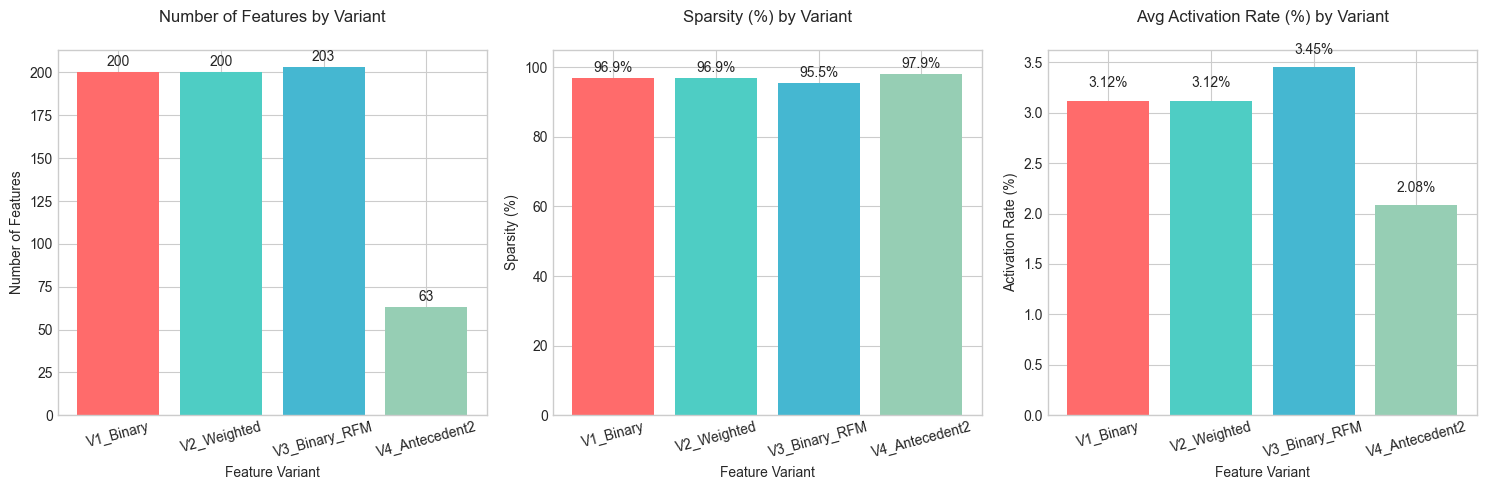

In [59]:
# =============================================================================
# 2.7. TRỰC QUAN HÓA SO SÁNH CÁC BIẾN THỂ
# =============================================================================

# Màu sắc (tối đa 4 màu theo quy tắc)
colors_4 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Chart 1: Số Features ---
ax1 = axes[0]
variants = df_stats['Variant'].tolist()
features = df_stats['Features'].tolist()
bars1 = ax1.bar(variants, features, color=colors_4)
ax1.set_title('Number of Features by Variant', fontsize=12, pad=20)
ax1.set_xlabel('Feature Variant')
ax1.set_ylabel('Number of Features')
ax1.tick_params(axis='x', rotation=15)

# Thêm label trên mỗi bar
for bar, val in zip(bars1, features):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             str(val), ha='center', va='bottom', fontsize=10)

# --- Chart 2: Sparsity ---
ax2 = axes[1]
sparsity = df_stats['Sparsity (%)'].tolist()
bars2 = ax2.bar(variants, sparsity, color=colors_4)
ax2.set_title('Sparsity (%) by Variant', fontsize=12, pad=20)
ax2.set_xlabel('Feature Variant')
ax2.set_ylabel('Sparsity (%)')
ax2.tick_params(axis='x', rotation=15)
ax2.set_ylim(0, 105)

for bar, val in zip(bars2, sparsity):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

# --- Chart 3: Activation Rate ---
ax3 = axes[2]
activation = df_stats['Avg Activation Rate (%)'].tolist()
bars3 = ax3.bar(variants, activation, color=colors_4)
ax3.set_title('Avg Activation Rate (%) by Variant', fontsize=12, pad=20)
ax3.set_xlabel('Feature Variant')
ax3.set_ylabel('Activation Rate (%)')
ax3.tick_params(axis='x', rotation=15)

for bar, val in zip(bars3, activation):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{val:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

# Lưu biểu đồ
plt.savefig(f'{IMAGES_DIR}/Req2_FeatureVariantComparison.png', dpi=150, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
print(f"Da luu bieu do: {IMAGES_DIR}/Req2_FeatureVariantComparison.png")

plt.show()

### 2.8. Phân bố Activation Rate theo Feature

Xem phân bố tỷ lệ kích hoạt của từng luật (feature) - luật nào được nhiều khách hàng kích hoạt nhất?

Đã lưu biểu đồ: ../images/Req2_ActivationRateDistribution.png


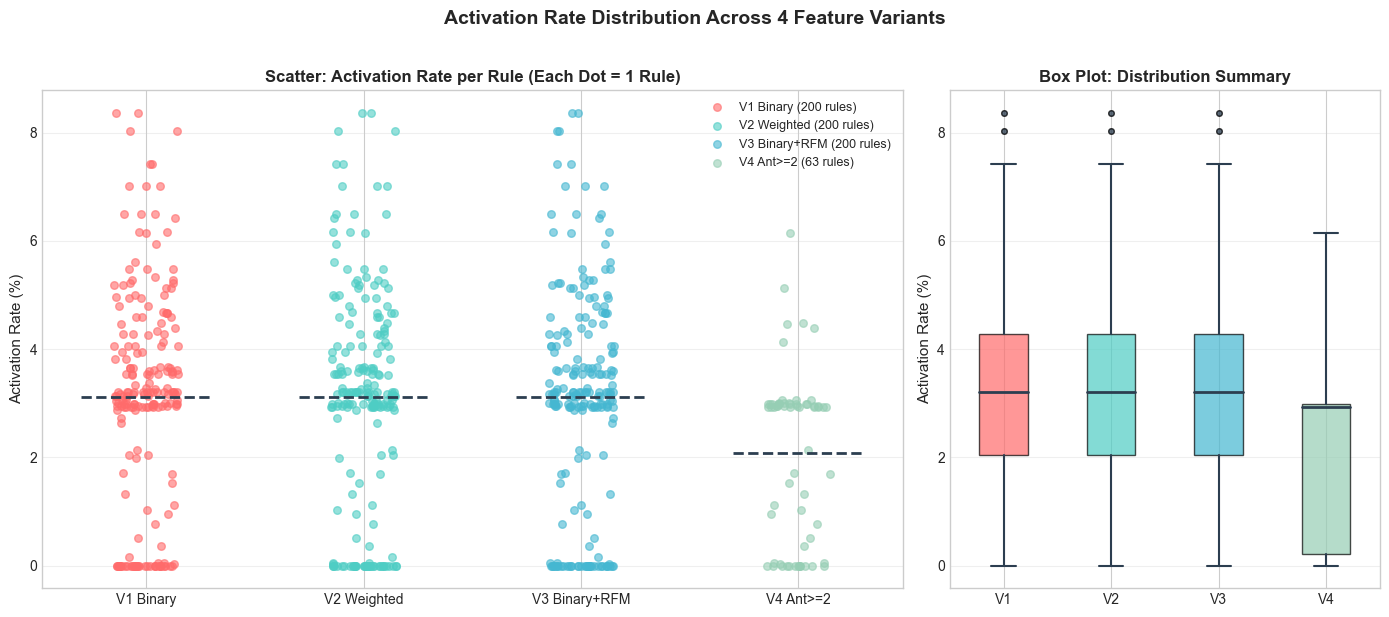


THỐNG KÊ ACTIVATION RATE CHO 4 BIẾN THỂ
Variant         Features      Min      Max     Mean   Median
---------------------------------------------------------------------------
V1 Binary            200    0.00%    8.37%    3.12%    3.21%
V2 Weighted          200    0.00%    8.37%    3.12%    3.21%
V3 Binary+RFM        200    0.00%    8.37%    3.12%    3.21%
V4 Ant>=2             63    0.00%    6.15%    2.08%    2.93%

Nhận xét:
- V1, V2, V3 có cùng 200 rules nên activation rate giống nhau (chỉ khác trọng số)
- V4 có ít rules hơn (63) do lọc antecedent >= 2, activation rate có thể khác biệt


In [60]:
# =============================================================================
# 2.8. PHÂN BỐ ACTIVATION RATE THEO FEATURE (4 BIẾN THỂ) - SCATTER 2D
# =============================================================================

# Tính activation rate cho từng feature trong mỗi biến thể
n_customers = X_v1.shape[0]

# V1: Binary rules (200 features)
activation_v1 = (X_v1 > 0).sum(axis=0) / n_customers * 100

# V2: Weighted rules (200 features)
activation_v2 = (X_v2 > 0).sum(axis=0) / n_customers * 100

# V3: Binary + RFM (chỉ tính 200 rule features, không tính 3 cột RFM)
activation_v3 = (X_v3[:, :200] > 0).sum(axis=0) / n_customers * 100

# V4: Antecedent >= 2 (63 features)
activation_v4 = (X_v4 > 0).sum(axis=0) / n_customers * 100

# Màu sắc cho 4 biến thể
colors_4 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
variant_names = ['V1 Binary', 'V2 Weighted', 'V3 Binary+RFM', 'V4 Ant>=2']

# Tạo figure với 2 subplots: Scatter (trái) + Box plot (phải)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

# === SCATTER PLOT (trái) ===
ax1 = axes[0]

# Tạo jitter (nhiễu nhỏ) để điểm không chồng lên nhau
np.random.seed(42)
jitter_v1 = np.random.uniform(-0.15, 0.15, len(activation_v1))
jitter_v2 = np.random.uniform(-0.15, 0.15, len(activation_v2))
jitter_v3 = np.random.uniform(-0.15, 0.15, len(activation_v3))
jitter_v4 = np.random.uniform(-0.15, 0.15, len(activation_v4))

# Vẽ scatter cho từng variant
ax1.scatter(np.zeros(len(activation_v1)) + jitter_v1, activation_v1, 
            c=colors_4[0], alpha=0.6, s=30, label=f'V1 Binary ({len(activation_v1)} rules)')
ax1.scatter(np.ones(len(activation_v2)) + jitter_v2, activation_v2, 
            c=colors_4[1], alpha=0.6, s=30, label=f'V2 Weighted ({len(activation_v2)} rules)')
ax1.scatter(np.full(len(activation_v3), 2) + jitter_v3, activation_v3, 
            c=colors_4[2], alpha=0.6, s=30, label=f'V3 Binary+RFM ({len(activation_v3)} rules)')
ax1.scatter(np.full(len(activation_v4), 3) + jitter_v4, activation_v4, 
            c=colors_4[3], alpha=0.6, s=30, label=f'V4 Ant>=2 ({len(activation_v4)} rules)')

# Vẽ đường mean cho mỗi variant
means = [activation_v1.mean(), activation_v2.mean(), activation_v3.mean(), activation_v4.mean()]
for i, mean_val in enumerate(means):
    ax1.hlines(mean_val, i - 0.3, i + 0.3, colors='#2C3E50', linewidth=2, linestyles='--')

ax1.set_xticks([0, 1, 2, 3])
ax1.set_xticklabels(variant_names)
ax1.set_ylabel('Activation Rate (%)', fontsize=11)
ax1.set_title('Scatter: Activation Rate per Rule (Each Dot = 1 Rule)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# === BOX PLOT (phải) ===
ax2 = axes[1]

# Chuẩn bị data cho boxplot
box_data = [activation_v1, activation_v2, activation_v3, activation_v4]

# Vẽ boxplot với màu tương ứng
bp = ax2.boxplot(box_data, patch_artist=True, labels=['V1', 'V2', 'V3', 'V4'])

# Tô màu cho từng box
for patch, color in zip(bp['boxes'], colors_4):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Style cho các phần khác của boxplot
for element in ['whiskers', 'caps', 'medians']:
    plt.setp(bp[element], color='#2C3E50', linewidth=1.5)
plt.setp(bp['medians'], color='#2C3E50', linewidth=2)
plt.setp(bp['fliers'], markerfacecolor='#2C3E50', marker='o', markersize=4, alpha=0.5)

ax2.set_ylabel('Activation Rate (%)', fontsize=11)
ax2.set_title('Box Plot: Distribution Summary', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Activation Rate Distribution Across 4 Feature Variants', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Lưu biểu đồ
plt.savefig(f'{IMAGES_DIR}/Req2_ActivationRateDistribution.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Đã lưu biểu đồ: {IMAGES_DIR}/Req2_ActivationRateDistribution.png")

plt.show()

# Thống kê bổ sung cho cả 4 biến thể
print("\n" + "="*75)
print("THỐNG KÊ ACTIVATION RATE CHO 4 BIẾN THỂ")
print("="*75)
print(f"{'Variant':<15} {'Features':>8} {'Min':>8} {'Max':>8} {'Mean':>8} {'Median':>8}")
print("-"*75)
print(f"{'V1 Binary':<15} {len(activation_v1):>8} {activation_v1.min():>7.2f}% {activation_v1.max():>7.2f}% {activation_v1.mean():>7.2f}% {np.median(activation_v1):>7.2f}%")
print(f"{'V2 Weighted':<15} {len(activation_v2):>8} {activation_v2.min():>7.2f}% {activation_v2.max():>7.2f}% {activation_v2.mean():>7.2f}% {np.median(activation_v2):>7.2f}%")
print(f"{'V3 Binary+RFM':<15} {len(activation_v3):>8} {activation_v3.min():>7.2f}% {activation_v3.max():>7.2f}% {activation_v3.mean():>7.2f}% {np.median(activation_v3):>7.2f}%")
print(f"{'V4 Ant>=2':<15} {len(activation_v4):>8} {activation_v4.min():>7.2f}% {activation_v4.max():>7.2f}% {activation_v4.mean():>7.2f}% {np.median(activation_v4):>7.2f}%")
print("\nNhận xét:")
print("- V1, V2, V3 có cùng 200 rules nên activation rate giống nhau (chỉ khác trọng số)")
print("- V4 có ít rules hơn (63) do lọc antecedent >= 2, activation rate có thể khác biệt")

### 2.9. Phân bố RFM

Trực quan hóa phân bố 3 chỉ số RFM của khách hàng.

Da luu bieu do: ../images/Req2_RFMDistribution.png


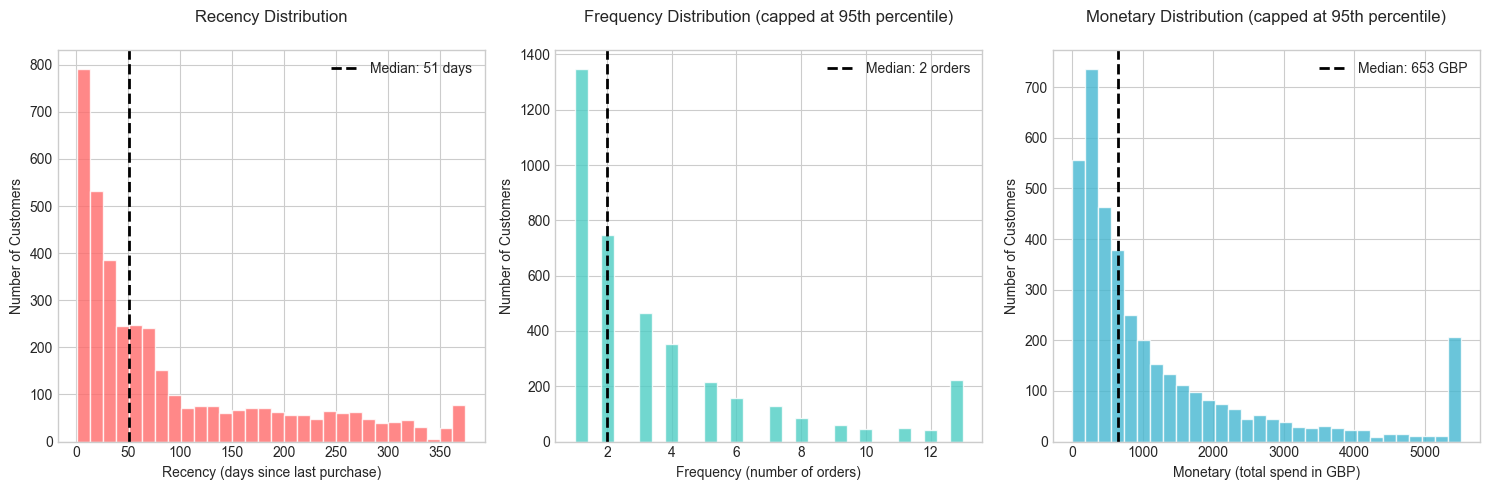


Thống kê RFM chi tiết:
       Recency  Frequency    Monetary
count  3921.00    3921.00     3921.00
mean     92.19       4.60     2301.77
std      99.53      23.01    28391.37
min       1.00       1.00        3.75
25%      18.00       1.00      300.36
50%      51.00       2.00      652.74
75%     143.00       5.00     1578.67
max     374.00    1373.00  1716830.53


In [61]:
# =============================================================================
# 2.9. PHÂN BỐ RFM
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Màu sắc
colors_rfm = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# --- Recency ---
ax1 = axes[0]
ax1.hist(rfm_df['Recency'], bins=30, color=colors_rfm[0], edgecolor='white', alpha=0.8)
ax1.axvline(rfm_df['Recency'].median(), color='black', linestyle='--', linewidth=2,
            label=f'Median: {rfm_df["Recency"].median():.0f} days')
ax1.set_title('Recency Distribution', fontsize=12, pad=20)
ax1.set_xlabel('Recency (days since last purchase)')
ax1.set_ylabel('Number of Customers')
ax1.legend()

# --- Frequency ---
ax2 = axes[1]
# Giới hạn để dễ nhìn (loại outliers)
freq_cap = rfm_df['Frequency'].quantile(0.95)
ax2.hist(rfm_df['Frequency'].clip(upper=freq_cap), bins=30, color=colors_rfm[1], edgecolor='white', alpha=0.8)
ax2.axvline(rfm_df['Frequency'].median(), color='black', linestyle='--', linewidth=2,
            label=f'Median: {rfm_df["Frequency"].median():.0f} orders')
ax2.set_title('Frequency Distribution (capped at 95th percentile)', fontsize=12, pad=20)
ax2.set_xlabel('Frequency (number of orders)')
ax2.set_ylabel('Number of Customers')
ax2.legend()

# --- Monetary ---
ax3 = axes[2]
# Giới hạn để dễ nhìn (loại outliers)
mon_cap = rfm_df['Monetary'].quantile(0.95)
ax3.hist(rfm_df['Monetary'].clip(upper=mon_cap), bins=30, color=colors_rfm[2], edgecolor='white', alpha=0.8)
ax3.axvline(rfm_df['Monetary'].median(), color='black', linestyle='--', linewidth=2,
            label=f'Median: {rfm_df["Monetary"].median():.0f} GBP')
ax3.set_title('Monetary Distribution (capped at 95th percentile)', fontsize=12, pad=20)
ax3.set_xlabel('Monetary (total spend in GBP)')
ax3.set_ylabel('Number of Customers')
ax3.legend()

plt.tight_layout()

# Lưu biểu đồ
plt.savefig(f'{IMAGES_DIR}/Req2_RFMDistribution.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Da luu bieu do: {IMAGES_DIR}/Req2_RFMDistribution.png")

plt.show()

# Thống kê RFM
print("\nThống kê RFM chi tiết:")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].describe().round(2))

### 2.10. Lưu kết quả Feature Matrix

Lưu 4 biến thể Feature Matrix và dữ liệu RFM vào thư mục `data/mini_project/`.

In [62]:
# =============================================================================
# 2.10. LƯU KẾT QUẢ FEATURE MATRIX
# =============================================================================

# Tạo DataFrame cho mỗi biến thể với CustomerID
def save_feature_matrix(X: np.ndarray, customers: list, filename: str, rules_df: pd.DataFrame = None):
    """Lưu ma trận đặc trưng thành CSV."""
    # Tạo tên cột
    if rules_df is not None:
        col_names = [f"rule_{i}" for i in range(X.shape[1] - (3 if 'RFM' in filename else 0))]
        if 'RFM' in filename:
            col_names = col_names[:X.shape[1]-3] + ['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
    else:
        col_names = [f"feature_{i}" for i in range(X.shape[1])]
    
    df = pd.DataFrame(X, columns=col_names[:X.shape[1]])
    df.insert(0, 'CustomerID', customers)
    
    filepath = f"{DATA_OUTPUT_DIR}/{filename}"
    df.to_csv(filepath, index=False)
    print(f"Da luu: {filepath} - Shape: {df.shape}")
    return df

# Lưu 4 biến thể
print("Lưu các biến thể Feature Matrix:")
print("="*60)

df_v1 = save_feature_matrix(X_v1, customers, 'feature_matrix_v1_binary.csv', rules_v1)
df_v2 = save_feature_matrix(X_v2, customers, 'feature_matrix_v2_weighted.csv', rules_v2)
df_v3 = save_feature_matrix(X_v3, customers, 'feature_matrix_v3_binary_rfm.csv', rules_v1)
df_v4 = save_feature_matrix(X_v4, customers, 'feature_matrix_v4_antecedent2.csv', rules_v4)

# Lưu RFM data
rfm_output_path = f"{DATA_OUTPUT_DIR}/rfm_data.csv"
rfm_df.to_csv(rfm_output_path, index=False)
print(f"\nDa luu RFM: {rfm_output_path} - Shape: {rfm_df.shape}")

# Lưu bảng thống kê so sánh
stats_output_path = f"{DATA_OUTPUT_DIR}/feature_variants_comparison.csv"
df_stats.to_csv(stats_output_path, index=False)
print(f"Da luu bang so sanh: {stats_output_path}")

Lưu các biến thể Feature Matrix:
Da luu: ../data/mini_project/feature_matrix_v1_binary.csv - Shape: (3921, 201)
Da luu: ../data/mini_project/feature_matrix_v2_weighted.csv - Shape: (3921, 201)
Da luu: ../data/mini_project/feature_matrix_v3_binary_rfm.csv - Shape: (3921, 204)
Da luu: ../data/mini_project/feature_matrix_v4_antecedent2.csv - Shape: (3921, 64)

Da luu RFM: ../data/mini_project/rfm_data.csv - Shape: (3921, 4)
Da luu bang so sanh: ../data/mini_project/feature_variants_comparison.csv


### 2.11. Tổng kết Yêu cầu 2

Tổng hợp kết quả Feature Engineering với nhận xét và đánh giá.

In [63]:
# =============================================================================
# 2.11. TỔNG KẾT YÊU CẦU 2: FEATURE ENGINEERING
# =============================================================================

print("="*85)
print(" "*25 + "TỔNG KẾT YÊU CẦU 2: FEATURE ENGINEERING")
print("="*85)

# -----------------------------------------------------------------------------
# 1. KẾT QUẢ TẠO 4 BIẾN THỂ FEATURE MATRIX
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("1. KẾT QUẢ TẠO 4 BIẾN THỂ FEATURE MATRIX")
print("─"*85)

summary_result = """
┌────────────────────────────────────────────────────────────────────────────────────┐
│ Biến thể         │ Kích thước   │ Sparsity │ Avg Activation │ Features Used       │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V1_Binary        │ 3,921 × 200  │ 96.88%   │ 3.12%          │ 166/200 (83.0%)     │
│ V2_Weighted      │ 3,921 × 200  │ 96.88%   │ 3.12%          │ 166/200 (83.0%)     │
│ V3_Binary_RFM    │ 3,921 × 203  │ 95.45%   │ 3.45%          │ 169/203 (83.3%)     │
│ V4_Antecedent2   │ 3,921 × 63   │ 97.92%   │ 2.08%          │ 50/63  (79.4%)      │
└────────────────────────────────────────────────────────────────────────────────────┘
"""
print(summary_result)

# -----------------------------------------------------------------------------
# 2. MÔ TẢ CHI TIẾT TỪNG BIẾN THỂ
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("2. MÔ TẢ CHI TIẾT TỪNG BIẾN THỂ")
print("─"*85)

variant_description = """
┌────────────────────────────────────────────────────────────────────────────────────┐
│ V1_Binary (Baseline):                                                              │
│   • Giá trị: 0 hoặc 1                                                              │
│   • 1 = Khách hàng đã mua TẤT CẢ sản phẩm trong antecedents của luật               │
│   • Đơn giản, dễ hiểu, làm baseline để so sánh                                     │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V2_Weighted (Lift × Confidence):                                                   │
│   • Giá trị: 7.45 đến 71.15 (khi khách kích hoạt luật)                             │
│   • Phản ánh "độ mạnh" của luật: lift cao + confidence cao = giá trị lớn           │
│   • Phân biệt được luật mạnh/yếu, không chỉ 0/1                                    │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V3_Binary_RFM (Kết hợp):                                                           │
│   • 200 cột rule features (binary) + 3 cột RFM đã chuẩn hóa (StandardScaler)       │
│   • RFM scaled giá trị từ -0.92 đến +60.40                                         │
│   • Kết hợp hành vi mua kèm VÀ giá trị khách hàng → đề xuất cho clustering         │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V4_Antecedent2 (Lọc luật phức tạp):                                                │
│   • Chỉ giữ 63 luật có antecedent >= 2 sản phẩm (giảm 68.5% so với V1)             │
│   • Tập trung vào pattern mua kèm phức tạp (khách đã mua >= 2 sản phẩm)            │
│   • Phát hiện khách hàng có hành vi mua sắm đa dạng hơn                            │
└────────────────────────────────────────────────────────────────────────────────────┘
"""
print(variant_description)

# -----------------------------------------------------------------------------
# 3. THỐNG KÊ RFM (Recency - Frequency - Monetary)
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("3. THỐNG KÊ RFM (Recency - Frequency - Monetary)")
print("─"*85)

rfm_stats = """
┌────────────────────────────────────────────────────────────────────────────────────┐
│                            PHÂN BỐ RFM CỦA 3,921 KHÁCH HÀNG UK                     │
├────────────────────────────────────────────────────────────────────────────────────┤
│ Chỉ số      │   Min   │   Q1    │  Median │    Q3   │    Max    │   Mean   │ Std   │
├────────────────────────────────────────────────────────────────────────────────────┤
│ Recency     │ 1 ngày  │ 18 ngày │ 51 ngày │ 143 ngày│ 374 ngày  │ 92.2 ngày│ 99.5  │
│ Frequency   │ 1 đơn   │ 1 đơn   │ 2 đơn   │ 5 đơn   │ 1,373 đơn │ 4.6 đơn  │ 23.0  │
│ Monetary    │ 3.75 GBP│ 300 GBP │ 653 GBP │ 1,579 GBP│ 1.7M GBP │ 2,302 GBP│28,391 │
└────────────────────────────────────────────────────────────────────────────────────┘

Nhận xét từ biểu đồ Req2_RFMDistribution.png:
  • Recency: Phân bố lệch phải, đa số khách mua trong vòng 50 ngày gần đây
  • Frequency: Phân bố lệch phải mạnh, đa số chỉ mua 1-2 lần, ít khách VIP
  • Monetary: Phân bố lệch phải mạnh, đa số chi tiêu dưới 1,000 GBP, có outliers lớn
"""
print(rfm_stats)

# -----------------------------------------------------------------------------
# 4. THỐNG KÊ ACTIVATION RATE
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("4. THỐNG KÊ ACTIVATION RATE (Từ biểu đồ Req2_ActivationRateDistribution.png)")
print("─"*85)

activation_stats = """
┌────────────────────────────────────────────────────────────────────────────────────┐
│ Biến thể     │ Features │   Min   │   Max   │  Mean  │ Median │ Nhận xét          │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V1 Binary    │   200    │  0.00%  │  8.37%  │ 3.12%  │ 3.21%  │ Baseline          │
│ V2 Weighted  │   200    │  0.00%  │  8.37%  │ 3.12%  │ 3.21%  │ Cùng pattern V1   │
│ V3 Binary+RFM│   200*   │  0.00%  │  8.37%  │ 3.12%  │ 3.21%  │ Cùng pattern V1   │
│ V4 Ant>=2    │    63    │  0.00%  │  6.15%  │ 2.08%  │ 2.93%  │ Ít feature, sparse│
└────────────────────────────────────────────────────────────────────────────────────┘
* V3 tính activation rate chỉ cho 200 rule features, không tính 3 cột RFM

Nhận xét từ Scatter + Box Plot:
  • V1, V2, V3 có activation pattern GIỐNG NHAU (cùng bộ 200 luật)
  • V4 có ít features hơn, median thấp hơn (2.93% vs 3.21%)
  • Có 34 rules không được kích hoạt bởi bất kỳ khách hàng nào (0% activation)
  • Box Plot cho thấy phân bố khá tập trung quanh median, có outliers trên
"""
print(activation_stats)

# -----------------------------------------------------------------------------
# 5. SO SÁNH GIÁ TRỊ ĐẶC TRƯNG
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("5. SO SÁNH GIÁ TRỊ ĐẶC TRƯNG (Từ biểu đồ Req2_FeatureVariantComparison.png)")
print("─"*85)

value_comparison_str = """
┌────────────────────────────────────────────────────────────────────────────────────┐
│ Biến thể       │ Value Min │ Value Max │ Value Mean │ Giải thích                   │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V1_Binary      │    1.00   │    1.00   │    1.00    │ Chỉ có giá trị 0 hoặc 1      │
│ V2_Weighted    │    7.45   │   71.15   │   30.34    │ lift×conf, trọng số luật     │
│ V3_Binary_RFM  │   0.0002  │   60.40   │    0.97    │ Bao gồm RFM scaled (gần 0)   │
│ V4_Antecedent2 │    1.00   │    1.00   │    1.00    │ Binary như V1, ít luật hơn   │
└────────────────────────────────────────────────────────────────────────────────────┘

Nhận xét từ Bar Chart:
  • V2 có range giá trị rộng nhất (7.45 - 71.15) → phân biệt rõ luật mạnh/yếu
  • V3 có mean thấp (0.97) do đa số là giá trị 0/1, RFM scaled gần 0
  • V1, V4 là binary nên không có sự phân biệt giữa các luật khi đã kích hoạt
"""
print(value_comparison_str)

# -----------------------------------------------------------------------------
# 6. FILES ĐÃ LƯU
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("6. FILES ĐÃ LƯU")
print("─"*85)

print(f"""
📁 Feature Matrices (data/mini_project/):
   ├── feature_matrix_v1_binary.csv      (3,921 × 201) - Baseline binary
   ├── feature_matrix_v2_weighted.csv    (3,921 × 201) - Weighted by lift×conf
   ├── feature_matrix_v3_binary_rfm.csv  (3,921 × 204) - Binary + RFM scaled
   └── feature_matrix_v4_antecedent2.csv (3,921 × 64)  - Antecedent >= 2

📁 Dữ liệu bổ trợ (data/mini_project/):
   ├── rfm_data.csv                      (3,922 × 4)   - RFM gốc (chưa scale)
   └── feature_variants_comparison.csv   (4 × 9)       - Bảng so sánh thống kê

📊 Biểu đồ (images/):
   ├── Req2_FeatureVariantComparison.png   - So sánh 4 biến thể (Bar chart)
   ├── Req2_ActivationRateDistribution.png - Phân bố activation (Scatter + Box)
   └── Req2_RFMDistribution.png            - Phân bố RFM (3 Histogram)
""")

# -----------------------------------------------------------------------------
# 7. KẾT LUẬN VÀ KHUYẾN NGHỊ CHO YÊU CẦU 3
# -----------------------------------------------------------------------------
print("\n" + "─"*85)
print("7. KẾT LUẬN VÀ KHUYẾN NGHỊ CHO YÊU CẦU 3 (CLUSTERING)")
print("─"*85)

conclusion = """
┌────────────────────────────────────────────────────────────────────────────────────┐
│                           KHUYẾN NGHỊ SỬ DỤNG CHO CLUSTERING                       │
├────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                    │
│  1. V3 (Binary + RFM) - KHUYẾN NGHỊ SỬ DỤNG                                        │
│     ✓ Kết hợp cả hành vi mua kèm (200 rules) và giá trị khách hàng (RFM)           │
│     ✓ Sparsity thấp nhất (95.45%) → clustering ổn định hơn                         │
│     ✓ RFM giúp phân biệt khách VIP vs thông thường                                 │
│     ✓ Phù hợp cho chiến lược marketing đa chiều                                    │
│                                                                                    │
│  2. V1 (Binary) - Phù hợp khi chỉ quan tâm hành vi mua kèm                         │
│     ✓ Baseline đơn giản, dễ diễn giải                                              │
│     ✓ So sánh hiệu quả của việc thêm RFM vào clustering                            │
│                                                                                    │
│  3. V2 (Weighted) - Phù hợp khi cần phân biệt độ mạnh của luật                     │
│     ✓ Giá trị cao = luật mạnh, khách hàng "đậm" hơn với pattern đó                 │
│                                                                                    │
│  4. V4 (Antecedent >= 2) - Phù hợp khi tìm pattern phức tạp                        │
│     ✓ Phát hiện khách hàng có hành vi mua sắm đa dạng                              │
│     ✗ Ít features (63), có thể mất thông tin                                       │
│                                                                                    │
├────────────────────────────────────────────────────────────────────────────────────┤
│  KẾ HOẠCH YÊU CẦU 3:                                                               │
│  • Thử nghiệm clustering trên cả 4 biến thể                                        │
│  • So sánh Silhouette Score để chọn biến thể tốt nhất                              │
│  • Xác định số cụm K tối ưu (K = 2 đến 10)                                         │
│  • Profiling và diễn giải đặc trưng từng cụm                                       │
│  • Đề xuất chiến lược marketing cho mỗi cụm                                        │
└────────────────────────────────────────────────────────────────────────────────────┘
"""
print(conclusion)

print("\n" + "="*85)
print(" "*25 + "✅ HOÀN THÀNH YÊU CẦU 2: FEATURE ENGINEERING")
print("="*85)

                         TỔNG KẾT YÊU CẦU 2: FEATURE ENGINEERING

─────────────────────────────────────────────────────────────────────────────────────
1. KẾT QUẢ TẠO 4 BIẾN THỂ FEATURE MATRIX
─────────────────────────────────────────────────────────────────────────────────────

┌────────────────────────────────────────────────────────────────────────────────────┐
│ Biến thể         │ Kích thước   │ Sparsity │ Avg Activation │ Features Used       │
├────────────────────────────────────────────────────────────────────────────────────┤
│ V1_Binary        │ 3,921 × 200  │ 96.88%   │ 3.12%          │ 166/200 (83.0%)     │
│ V2_Weighted      │ 3,921 × 200  │ 96.88%   │ 3.12%          │ 166/200 (83.0%)     │
│ V3_Binary_RFM    │ 3,921 × 203  │ 95.45%   │ 3.45%          │ 169/203 (83.3%)     │
│ V4_Antecedent2   │ 3,921 × 63   │ 97.92%   │ 2.08%          │ 50/63  (79.4%)      │
└────────────────────────────────────────────────────────────────────────────────────┘


───────────────────────────

### 2.12. Dữ liệu mẫu cho từng biến thể Feature

Hiển thị dữ liệu mẫu (5 dòng đầu) của mỗi biến thể Feature Matrix để người xem dễ hình dung cấu trúc dữ liệu.

In [64]:
# =============================================================================
# 2.12. DỮ LIỆU MẪU CHO TỪNG BIẾN THỂ FEATURE
# =============================================================================

# Chọn các cột để hiển thị (không thể hiển thị hết 200 cột)
sample_cols = ['CustomerID', 'rule_0', 'rule_1', 'rule_2', 'rule_3', 'rule_4']
sample_customers = ['012748', '012749', '012820', '013047', '013263']

# -----------------------------------------------------------------------------
# V1: BINARY (Baseline)
# -----------------------------------------------------------------------------
print("="*80)
print("V1: BINARY (Baseline) - Giá trị 0/1")
print("="*80)
print("Ý nghĩa: 1 = khách hàng đã mua TẤT CẢ sản phẩm trong antecedents của luật")
print("-"*80)

# Load và hiển thị mẫu V1
df_v1_sample = df_v1[df_v1['CustomerID'].isin(sample_customers)][sample_cols].head()
display(df_v1_sample)

# -----------------------------------------------------------------------------
# V2: WEIGHTED (lift × confidence)
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("V2: WEIGHTED - Giá trị = lift × confidence")
print("="*80)
print("Ý nghĩa: Giá trị cao = luật mạnh hơn (lift và confidence cao)")
print("-"*80)

df_v2_sample = df_v2[df_v2['CustomerID'].isin(sample_customers)][sample_cols].head()
# Làm tròn để dễ đọc
df_v2_display = df_v2_sample.copy()
for col in df_v2_display.columns[1:]:
    df_v2_display[col] = df_v2_display[col].round(2)
display(df_v2_display)

# -----------------------------------------------------------------------------
# V3: BINARY + RFM
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("V3: BINARY + RFM (scaled)")
print("="*80)
print("Ý nghĩa: 200 cột rule (binary) + 3 cột RFM đã chuẩn hóa")
print("Lưu ý về RFM scaled:")
print("  - Recency_scaled ÂM = khách mua GẦN ĐÂY hơn trung bình (tốt)")
print("  - Frequency_scaled DƯƠNG = khách mua NHIỀU LẦN hơn trung bình (tốt)")
print("  - Monetary_scaled DƯƠNG = khách chi NHIỀU TIỀN hơn trung bình (tốt)")
print("-"*80)

# Lấy 3 cột rule đầu + 3 cột RFM cuối (rule_200, rule_201, rule_202)
v3_all_cols = df_v3.columns.tolist()
v3_cols = ['CustomerID', 'rule_0', 'rule_1', 'rule_2'] + v3_all_cols[-3:]  # 3 cột cuối là RFM
df_v3_sample = df_v3[df_v3['CustomerID'].isin(sample_customers)][v3_cols].head()
df_v3_display = df_v3_sample.copy()
for col in df_v3_display.columns[1:]:
    df_v3_display[col] = df_v3_display[col].round(4)
    
# Đổi tên cột để dễ hiểu
df_v3_display = df_v3_display.rename(columns={
    v3_all_cols[-3]: 'Recency_scaled',
    v3_all_cols[-2]: 'Frequency_scaled', 
    v3_all_cols[-1]: 'Monetary_scaled'
})
display(df_v3_display)

# -----------------------------------------------------------------------------
# V4: ANTECEDENT >= 2
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("V4: BINARY (Antecedent >= 2 items)")
print("="*80)
print("Ý nghĩa: Chỉ giữ 63 luật có antecedent >= 2 sản phẩm")
print("-"*80)

v4_cols = ['CustomerID', 'rule_0', 'rule_1', 'rule_2', 'rule_3', 'rule_4']
df_v4_sample = df_v4[df_v4['CustomerID'].isin(sample_customers)][v4_cols].head()
display(df_v4_sample)

# -----------------------------------------------------------------------------
# RFM DATA (DỮ LIỆU GỐC)
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("RFM DATA (Recency - Frequency - Monetary) - DỮ LIỆU GỐC")
print("="*80)
print("Ý nghĩa:")
print("  - Recency: Số ngày từ lần mua cuối đến snapshot date (càng NHỎ càng TỐT)")
print("  - Frequency: Số đơn hàng unique (càng LỚN càng TỐT)")
print("  - Monetary: Tổng chi tiêu GBP (càng LỚN càng TỐT)")
print("-"*80)

rfm_sample = rfm_df[rfm_df['CustomerID'].isin(sample_customers)].head()
display(rfm_sample)

# -----------------------------------------------------------------------------
# GIẢI THÍCH MỐI LIÊN HỆ RFM GỐC VÀ RFM SCALED
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("GIẢI THÍCH: SO SÁNH RFM GỐC VÀ RFM SCALED")
print("="*80)
print("""
Ví dụ với khách hàng 012748:
┌────────────────────────────────────────────────────────────────────────────┐
│ Chỉ số      │ Giá trị gốc │ Giá trị scaled │ Ý nghĩa                       │
├────────────────────────────────────────────────────────────────────────────┤
│ Recency     │ 1 ngày      │ -0.9163        │ Mua rất gần đây (tốt!)        │
│ Frequency   │ 209 đơn     │ +8.8830        │ Mua rất nhiều lần (VIP!)      │
│ Monetary    │ 33,719 GBP  │ +1.1067        │ Chi tiêu trên trung bình      │
└────────────────────────────────────────────────────────────────────────────┘

→ Khách hàng 012748 là khách VIP: mua gần đây, tần suất cao, chi tiêu nhiều!
""")

V1: BINARY (Baseline) - Giá trị 0/1
Ý nghĩa: 1 = khách hàng đã mua TẤT CẢ sản phẩm trong antecedents của luật
--------------------------------------------------------------------------------


,CustomerID,rule_0,rule_1,rule_2,rule_3,rule_4
3,012748,1.0,1.0,1.0,1.0,1.0
4,012749,0.0,0.0,0.0,0.0,0.0
5,012820,0.0,0.0,0.0,0.0,0.0
164,013047,0.0,0.0,0.0,0.0,0.0
320,013263,1.0,1.0,1.0,1.0,1.0



V2: WEIGHTED - Giá trị = lift × confidence
Ý nghĩa: Giá trị cao = luật mạnh hơn (lift và confidence cao)
--------------------------------------------------------------------------------


,CustomerID,rule_0,rule_1,rule_2,rule_3,rule_4
3,012748,70.959999,71.150002,69.839996,70.660004,70.519997
4,012749,0.000000,0.000000,0.000000,0.000000,0.000000
5,012820,0.000000,0.000000,0.000000,0.000000,0.000000
164,013047,0.000000,0.000000,0.000000,0.000000,0.000000
320,013263,70.959999,71.150002,69.839996,70.660004,70.519997



V3: BINARY + RFM (scaled)
Ý nghĩa: 200 cột rule (binary) + 3 cột RFM đã chuẩn hóa
Lưu ý về RFM scaled:
  - Recency_scaled ÂM = khách mua GẦN ĐÂY hơn trung bình (tốt)
  - Frequency_scaled DƯƠNG = khách mua NHIỀU LẦN hơn trung bình (tốt)
  - Monetary_scaled DƯƠNG = khách chi NHIỀU TIỀN hơn trung bình (tốt)
--------------------------------------------------------------------------------


,CustomerID,rule_0,rule_1,rule_2,Recency_scaled,Frequency_scaled,Monetary_scaled
3,012748,1.0,1.0,1.0,-0.9163,8.8830,1.1067
4,012749,0.0,0.0,0.0,-0.8861,0.0176,0.0630
5,012820,0.0,0.0,0.0,-0.8962,-0.0259,-0.0479
164,013047,0.0,0.0,0.0,-0.6048,0.2348,0.0330
320,013263,1.0,1.0,1.0,-0.9163,1.3213,0.1815



V4: BINARY (Antecedent >= 2 items)
Ý nghĩa: Chỉ giữ 63 luật có antecedent >= 2 sản phẩm
--------------------------------------------------------------------------------


,CustomerID,rule_0,rule_1,rule_2,rule_3,rule_4
3,012748,1.0,1.0,1.0,1.0,1.0
4,012749,0.0,0.0,0.0,0.0,0.0
5,012820,0.0,0.0,0.0,0.0,0.0
164,013047,0.0,0.0,0.0,0.0,0.0
320,013263,1.0,1.0,1.0,1.0,1.0



RFM DATA (Recency - Frequency - Monetary) - DỮ LIỆU GỐC
Ý nghĩa:
  - Recency: Số ngày từ lần mua cuối đến snapshot date (càng NHỎ càng TỐT)
  - Frequency: Số đơn hàng unique (càng LỚN càng TỐT)
  - Monetary: Tổng chi tiêu GBP (càng LỚN càng TỐT)
--------------------------------------------------------------------------------


,CustomerID,Recency,Frequency,Monetary
3,012748,1,209,33719.73
4,012749,4,5,4090.88
5,012820,3,4,942.34
164,013047,32,10,3237.54
320,013263,1,35,7454.07



GIẢI THÍCH: SO SÁNH RFM GỐC VÀ RFM SCALED

Ví dụ với khách hàng 012748:
┌────────────────────────────────────────────────────────────────────────────┐
│ Chỉ số      │ Giá trị gốc │ Giá trị scaled │ Ý nghĩa                       │
├────────────────────────────────────────────────────────────────────────────┤
│ Recency     │ 1 ngày      │ -0.9163        │ Mua rất gần đây (tốt!)        │
│ Frequency   │ 209 đơn     │ +8.8830        │ Mua rất nhiều lần (VIP!)      │
│ Monetary    │ 33,719 GBP  │ +1.1067        │ Chi tiêu trên trung bình      │
└────────────────────────────────────────────────────────────────────────────┘

→ Khách hàng 012748 là khách VIP: mua gần đây, tần suất cao, chi tiêu nhiều!



## 3. Yêu cầu 3
+ Sau khi có vector đặc trưng, nhóm cần thực hiện chọn số cụm K và huấn luyện mô hình. 
+ Yêu cầu tối thiểu là
    + Nhóm phải sử dụng Silhouette score hoặc Eblow để khảo sát K trong một khoảng giá trị hợp lý (ví dụ 2 đến 10 hoặc 2 đến 12), sau đó chọn ra K tốt nhất theo kết quả và giải thích ngắn gọn lý do lựa chọn. 
    + Phần giải thích không cần dài, nhưng phải thể hiện tư duy: không chọn K chỉ vì “đẹp”, mà còn cân nhắc xem cụm có thực sự tạo ra ý nghĩa hành động marketing hay không. 
    + Sau khi chọn K, nhóm huấn luyện K-Means và lưu lại nhãn cụm cho từng khách hàng.

### 3.1. Chuẩn bị dữ liệu và cấu hình

**Các tùy chọn điều khiển:**
- `USE_CACHED_K`: Nếu `True`, sử dụng giá trị K đã lưu từ lần chạy trước (bỏ qua Elbow/Silhouette)
- `CUSTOM_K`: Dictionary cho phép override K cho từng variant cụ thể
- `CONFIG_FILE`: File JSON lưu kết quả K tối ưu

**Lưu ý:** Nếu chưa có file config hoặc muốn tính toán lại, đặt `USE_CACHED_K = False`

In [109]:
# =============================================================================
# 3.1. CHUẨN BỊ DỮ LIỆU VÀ CẤU HÌNH
# =============================================================================

import os
import json
import logging
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# ★★★ TÙY CHỌN ĐIỀU KHIỂN - NGƯỜI DÙNG CÓ THỂ THAY ĐỔI ★★★
# =============================================================================

# Lựa chọn 1: Sử dụng K đã cache từ lần chạy trước (True) hoặc tính toán lại (False)
USE_CACHED_K = False  # Đặt True để dùng K đã lưu, False để tính lại

# Lựa chọn 2: Override K cho từng variant cụ thể (để None nếu muốn tự động)
# Ví dụ: {'V1_Binary': 3, 'V2_Weighted': 4} - chỉ override V1 và V2
CUSTOM_K = {
    'V1_Binary': None,       # None = tự động chọn | số = override
    'V2_Weighted': None,     # None = tự động chọn | số = override
    'V3_Binary_RFM': None,   # None = tự động chọn | số = override
    'V4_Antecedent2': None   # None = tự động chọn | số = override
}

# =============================================================================
# CẤU HÌNH THAM SỐ THỬ NGHIỆM
# =============================================================================
K_RANGE = range(2, 13)  # K từ 2 đến 12
RANDOM_STATE = 42
N_INIT = 10  # Số lần khởi tạo KMeans

# Danh sách tên variants theo thứ tự
variant_names = ['V1_Binary', 'V2_Weighted', 'V3_Binary_RFM', 'V4_Antecedent2']

# =============================================================================
# TẠO THƯ MỤC OUTPUT
# =============================================================================
EXPERIMENT_DIR = f"{DATA_OUTPUT_DIR}/clustering_experiments"
LOGS_DIR = "../logs"
CONFIG_FILE = f"{EXPERIMENT_DIR}/optimal_k_config.json"

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# =============================================================================
# HÀM TIỆN ÍCH: LOAD/SAVE CONFIG
# =============================================================================

def load_k_config(config_file: str) -> dict:
    """Load cấu hình K từ file JSON."""
    if os.path.exists(config_file):
        with open(config_file, 'r', encoding='utf-8') as f:
            return json.load(f)
    return None

def save_k_config(config: dict, config_file: str):
    """Lưu cấu hình K vào file JSON."""
    config['last_updated'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(config_file, 'w', encoding='utf-8') as f:
        json.dump(config, f, indent=2, ensure_ascii=False)
    print(f"✓ Đã lưu config: {config_file}")

def get_k_per_variant(cached_config: dict, custom_k: dict, auto_k: dict) -> dict:
    """
    Xác định K cho mỗi variant theo thứ tự ưu tiên:
    1. CUSTOM_K (nếu user override)
    2. cached_config (nếu USE_CACHED_K=True và có cache)
    3. auto_k (từ phân tích Silhouette)
    """
    result = {}
    for variant in variant_names:
        if custom_k.get(variant) is not None:
            result[variant] = custom_k[variant]
            print(f"  {variant}: K = {custom_k[variant]} (CUSTOM override)")
        elif cached_config and variant in cached_config:
            result[variant] = cached_config[variant]['K']
            print(f"  {variant}: K = {cached_config[variant]['K']} (từ CACHE)")
        elif auto_k and variant in auto_k:
            result[variant] = auto_k[variant]
            print(f"  {variant}: K = {auto_k[variant]} (AUTO từ Silhouette)")
        else:
            result[variant] = 4  # Default fallback
            print(f"  {variant}: K = 4 (DEFAULT)")
    return result

# =============================================================================
# THIẾT LẬP LOGGING
# =============================================================================
log_file = f"{LOGS_DIR}/req3_clustering.log"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(message)s',
    handlers=[
        logging.FileHandler(log_file, mode='w', encoding='utf-8'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

logger.info("="*70)
logger.info("BẮT ĐẦU YÊU CẦU 3: PHÂN CỤM K-MEANS")
logger.info("="*70)

# =============================================================================
# KIỂM TRA VÀ LOAD DỮ LIỆU
# =============================================================================
print("\n" + "="*70)
print("KIỂM TRA DỮ LIỆU VÀ CẤU HÌNH")
print("="*70)

# Dictionary chứa 4 biến thể
feature_variants = {}

# Kiểm tra X_v1, X_v2, X_v3, X_v4 có trong kernel không
try:
    if 'X_v1' in dir() and X_v1 is not None:
        feature_variants['V1_Binary'] = X_v1
        feature_variants['V2_Weighted'] = X_v2
        feature_variants['V3_Binary_RFM'] = X_v3
        feature_variants['V4_Antecedent2'] = X_v4
        print("✓ Feature matrices: Loaded từ kernel memory")
    else:
        raise NameError("Không tìm thấy trong kernel")
except:
    print("Loading Feature matrices từ CSV files...")
    df_v1 = pd.read_csv(f"{DATA_OUTPUT_DIR}/feature_matrix_v1_binary.csv")
    df_v2 = pd.read_csv(f"{DATA_OUTPUT_DIR}/feature_matrix_v2_weighted.csv")
    df_v3 = pd.read_csv(f"{DATA_OUTPUT_DIR}/feature_matrix_v3_binary_rfm.csv")
    df_v4 = pd.read_csv(f"{DATA_OUTPUT_DIR}/feature_matrix_v4_antecedent2.csv")
    
    customers = df_v1['CustomerID'].values
    feature_variants['V1_Binary'] = df_v1.iloc[:, 1:].values
    feature_variants['V2_Weighted'] = df_v2.iloc[:, 1:].values
    feature_variants['V3_Binary_RFM'] = df_v3.iloc[:, 1:].values
    feature_variants['V4_Antecedent2'] = df_v4.iloc[:, 1:].values
    print("✓ Feature matrices: Loaded từ CSV files")

# Kiểm tra cached config
cached_config = load_k_config(CONFIG_FILE)

print("\n" + "-"*70)
print("TRẠNG THÁI:")
print("-"*70)
print(f"  USE_CACHED_K  = {USE_CACHED_K}")
print(f"  CONFIG_FILE   = {CONFIG_FILE}")
print(f"  Cache exists  = {cached_config is not None}")

if cached_config:
    print(f"\n  Cached K values:")
    for v in variant_names:
        if v in cached_config:
            print(f"    • {v}: K={cached_config[v]['K']} (Sil={cached_config[v].get('Silhouette', 'N/A')})")

custom_overrides = [v for v, k in CUSTOM_K.items() if k is not None]
if custom_overrides:
    print(f"\n  Custom overrides: {custom_overrides}")
else:
    print(f"\n  Custom overrides: None (sử dụng auto)")

# Hiển thị thông tin dữ liệu
print("\n" + "-"*70)
print("FEATURE MATRICES:")
print("-"*70)
for name, X in feature_variants.items():
    print(f"  {name:20s}: {X.shape[0]:,} customers × {X.shape[1]:,} features")

print(f"\n  K_RANGE: {list(K_RANGE)}")
print(f"  Experiments: {len(feature_variants)} variants × {len(K_RANGE)} K = {len(feature_variants) * len(K_RANGE)}")

logger.info(f"USE_CACHED_K={USE_CACHED_K}, Cache exists={cached_config is not None}")

2025-12-30 03:54:28,460 | INFO | ======================================================================
2025-12-30 03:54:28,461 | INFO | BẮT ĐẦU YÊU CẦU 3: PHÂN CỤM K-MEANS
2025-12-30 03:54:28,463 | INFO | ======================================================================
2025-12-30 03:54:28,467 | INFO | USE_CACHED_K=False, Cache exists=True



KIỂM TRA DỮ LIỆU VÀ CẤU HÌNH
✓ Feature matrices: Loaded từ kernel memory

----------------------------------------------------------------------
TRẠNG THÁI:
----------------------------------------------------------------------
  USE_CACHED_K  = False
  CONFIG_FILE   = ../data/mini_project/clustering_experiments/optimal_k_config.json
  Cache exists  = True

  Cached K values:
    • V1_Binary: K=2 (Sil=0.7038999795913696)
    • V2_Weighted: K=2 (Sil=0.8920000195503235)
    • V3_Binary_RFM: K=2 (Sil=0.9621999859809875)
    • V4_Antecedent2: K=5 (Sil=0.8090999722480774)

  Custom overrides: None (sử dụng auto)

----------------------------------------------------------------------
FEATURE MATRICES:
----------------------------------------------------------------------
  V1_Binary           : 3,921 customers × 200 features
  V2_Weighted         : 3,921 customers × 200 features
  V3_Binary_RFM       : 3,921 customers × 203 features
  V4_Antecedent2      : 3,921 customers × 63 features

  K

### 3.2. Khảo sát K bằng Elbow Method

**Lưu ý:** Nếu `USE_CACHED_K = True` và đã có file config, bước này sẽ được **BỎ QUA**.

Elbow Method sử dụng **Inertia** (Within-Cluster Sum of Squares - WCSS):
- Inertia càng nhỏ → các điểm trong cùng cluster càng gần nhau
- Tìm điểm "khuỷu tay" (elbow) nơi việc tăng K không còn giảm Inertia đáng kể

In [110]:
# =============================================================================
# 3.2. KHẢO SÁT K BẰNG ELBOW METHOD
# =============================================================================

import time

# File checkpoint
ELBOW_CHECKPOINT = f"{EXPERIMENT_DIR}/elbow_results.csv"

# -----------------------------------------------------------------------------
# Kiểm tra điều kiện bỏ qua
# -----------------------------------------------------------------------------
SKIP_ELBOW = USE_CACHED_K and cached_config is not None

if SKIP_ELBOW:
    print("="*70)
    print("⏭️  BỎ QUA ELBOW METHOD (USE_CACHED_K = True)")
    print("="*70)
    print(f"Đang sử dụng K từ cache: {CONFIG_FILE}")
    
    # Load kết quả cũ nếu có
    if os.path.exists(ELBOW_CHECKPOINT):
        elbow_df = pd.read_csv(ELBOW_CHECKPOINT)
        print(f"✓ Loaded cached results: {len(elbow_df)} records")
    else:
        elbow_df = None
        print("⚠️  Không có file elbow_results.csv cũ")
else:
    # -----------------------------------------------------------------------------
    # Chạy thử nghiệm Elbow
    # -----------------------------------------------------------------------------
    def run_elbow_experiments(feature_variants: dict, k_range: range, checkpoint_file: str):
        """
        Chạy thử nghiệm Elbow Method cho tất cả variants.
        Lưu checkpoint sau mỗi variant.
        """
        all_results = []
        
        # Kiểm tra checkpoint đã có chưa
        if os.path.exists(checkpoint_file):
            existing_df = pd.read_csv(checkpoint_file)
            completed_variants = existing_df['Variant'].unique().tolist()
            all_results = existing_df.to_dict('records')
            logger.info(f"Đã có checkpoint: {completed_variants}")
        else:
            completed_variants = []
        
        for variant_name, X in feature_variants.items():
            # Skip nếu đã chạy xong variant này
            if variant_name in completed_variants:
                logger.info(f"Skip {variant_name} (đã có trong checkpoint)")
                continue
            
            logger.info(f"Bắt đầu Elbow cho {variant_name}...")
            
            for k in k_range:
                start_time = time.time()
                
                # Fit KMeans
                kmeans = KMeans(n_clusters=k, n_init=N_INIT, random_state=RANDOM_STATE)
                kmeans.fit(X)
                
                elapsed = time.time() - start_time
                
                result = {
                    'Variant': variant_name,
                    'K': k,
                    'Inertia': kmeans.inertia_,
                    'Time_seconds': round(elapsed, 3)
                }
                all_results.append(result)
                
                logger.info(f"  K={k:2d} | Inertia={kmeans.inertia_:,.2f} | Time={elapsed:.2f}s")
            
            # Lưu checkpoint sau mỗi variant
            pd.DataFrame(all_results).to_csv(checkpoint_file, index=False)
            logger.info(f"✓ Checkpoint saved: {variant_name}")
        
        return pd.DataFrame(all_results)

    # Chạy thử nghiệm
    print("="*70)
    print("KHẢO SÁT K BẰNG ELBOW METHOD")
    print("="*70)

    elbow_df = run_elbow_experiments(feature_variants, K_RANGE, ELBOW_CHECKPOINT)

    print("\n" + "="*70)
    print("KẾT QUẢ ELBOW METHOD")
    print("="*70)
    print(f"Đã lưu: {ELBOW_CHECKPOINT}")
    print(f"Tổng số experiments: {len(elbow_df)}")

    # Hiển thị bảng kết quả
    display(elbow_df.pivot(index='K', columns='Variant', values='Inertia').round(2))

2025-12-30 03:54:28,500 | INFO | Đã có checkpoint: ['V1_Binary', 'V2_Weighted', 'V3_Binary_RFM', 'V4_Antecedent2']
2025-12-30 03:54:28,501 | INFO | Skip V1_Binary (đã có trong checkpoint)
2025-12-30 03:54:28,503 | INFO | Skip V2_Weighted (đã có trong checkpoint)
2025-12-30 03:54:28,504 | INFO | Skip V3_Binary_RFM (đã có trong checkpoint)
2025-12-30 03:54:28,506 | INFO | Skip V4_Antecedent2 (đã có trong checkpoint)


KHẢO SÁT K BẰNG ELBOW METHOD

KẾT QUẢ ELBOW METHOD
Đã lưu: ../data/mini_project/clustering_experiments/elbow_results.csv
Tổng số experiments: 44


Variant,V1_Binary,V2_Weighted,V3_Binary_RFM,V4_Antecedent2
K,,,,
2,17604.41,9015844.0,27820.19,1927.41
3,15970.17,8178902.0,22070.60,1547.90
4,14805.70,7561424.0,18847.73,1313.32
5,13794.83,7143957.5,17304.37,1194.58
6,13126.78,6587698.0,16179.80,1129.84
7,12630.64,6231210.0,15201.00,1060.53
8,12331.46,5771311.5,14533.42,1022.28
9,12101.61,5510212.0,14140.15,963.85
10,11883.34,5248814.0,13809.96,892.66


### 3.3. Khảo sát K bằng Silhouette Score

**Lưu ý:** Nếu `USE_CACHED_K = True` và đã có file config, bước này sẽ được **BỎ QUA**.

Silhouette Score đo lường chất lượng clustering:
- **a(i)**: Khoảng cách trung bình trong cùng cluster
- **b(i)**: Khoảng cách trung bình đến cluster gần nhất

$$Silhouette = \frac{b(i) - a(i)}{max(a(i), b(i))}$$

| Score | Đánh giá |
|-------|----------|
| > 0.5 | Tốt |
| 0.25 - 0.5 | Trung bình |
| < 0.25 | Yếu |

In [111]:
# =============================================================================
# 3.3. KHẢO SÁT K BẰNG SILHOUETTE SCORE
# =============================================================================

# File checkpoint
SILHOUETTE_CHECKPOINT = f"{EXPERIMENT_DIR}/silhouette_results.csv"

# -----------------------------------------------------------------------------
# Kiểm tra điều kiện bỏ qua
# -----------------------------------------------------------------------------
SKIP_SILHOUETTE = USE_CACHED_K and cached_config is not None

if SKIP_SILHOUETTE:
    print("="*70)
    print("⏭️  BỎ QUA SILHOUETTE SCORE (USE_CACHED_K = True)")
    print("="*70)
    print(f"Đang sử dụng K từ cache: {CONFIG_FILE}")
    
    # Load kết quả cũ nếu có
    if os.path.exists(SILHOUETTE_CHECKPOINT):
        silhouette_df = pd.read_csv(SILHOUETTE_CHECKPOINT)
        print(f"✓ Loaded cached results: {len(silhouette_df)} records")
    else:
        silhouette_df = None
        print("⚠️  Không có file silhouette_results.csv cũ")
else:
    # -----------------------------------------------------------------------------
    # Chạy thử nghiệm Silhouette
    # -----------------------------------------------------------------------------
    def run_silhouette_experiments(feature_variants: dict, k_range: range, checkpoint_file: str):
        """
        Chạy thử nghiệm Silhouette Score cho tất cả variants.
        Lưu checkpoint sau mỗi variant.
        """
        all_results = []
        
        # Kiểm tra checkpoint đã có chưa
        if os.path.exists(checkpoint_file):
            existing_df = pd.read_csv(checkpoint_file)
            completed_variants = existing_df['Variant'].unique().tolist()
            all_results = existing_df.to_dict('records')
            logger.info(f"Đã có checkpoint: {completed_variants}")
        else:
            completed_variants = []
        
        for variant_name, X in feature_variants.items():
            # Skip nếu đã chạy xong variant này
            if variant_name in completed_variants:
                logger.info(f"Skip {variant_name} (đã có trong checkpoint)")
                continue
            
            logger.info(f"Bắt đầu Silhouette cho {variant_name}...")
            
            for k in k_range:
                start_time = time.time()
                
                # Fit KMeans
                kmeans = KMeans(n_clusters=k, n_init=N_INIT, random_state=RANDOM_STATE)
                labels = kmeans.fit_predict(X)
                
                # Tính Silhouette Score
                sil_score = silhouette_score(X, labels)
                
                elapsed = time.time() - start_time
                
                result = {
                    'Variant': variant_name,
                    'K': k,
                    'Silhouette': round(sil_score, 4),
                    'Time_seconds': round(elapsed, 3)
                }
                all_results.append(result)
                
                logger.info(f"  K={k:2d} | Silhouette={sil_score:.4f} | Time={elapsed:.2f}s")
            
            # Lưu checkpoint sau mỗi variant
            pd.DataFrame(all_results).to_csv(checkpoint_file, index=False)
            logger.info(f"✓ Checkpoint saved: {variant_name}")
        
        return pd.DataFrame(all_results)

    # Chạy thử nghiệm
    print("="*70)
    print("KHẢO SÁT K BẰNG SILHOUETTE SCORE")
    print("="*70)

    silhouette_df = run_silhouette_experiments(feature_variants, K_RANGE, SILHOUETTE_CHECKPOINT)

    print("\n" + "="*70)
    print("KẾT QUẢ SILHOUETTE SCORE")
    print("="*70)
    print(f"Đã lưu: {SILHOUETTE_CHECKPOINT}")
    print(f"Tổng số experiments: {len(silhouette_df)}")

    # Hiển thị bảng kết quả
    display(silhouette_df.pivot(index='K', columns='Variant', values='Silhouette').round(4))

2025-12-30 03:54:28,548 | INFO | Đã có checkpoint: ['V1_Binary', 'V2_Weighted', 'V3_Binary_RFM', 'V4_Antecedent2']
2025-12-30 03:54:28,549 | INFO | Skip V1_Binary (đã có trong checkpoint)
2025-12-30 03:54:28,550 | INFO | Skip V2_Weighted (đã có trong checkpoint)
2025-12-30 03:54:28,551 | INFO | Skip V3_Binary_RFM (đã có trong checkpoint)
2025-12-30 03:54:28,552 | INFO | Skip V4_Antecedent2 (đã có trong checkpoint)


KHẢO SÁT K BẰNG SILHOUETTE SCORE

KẾT QUẢ SILHOUETTE SCORE
Đã lưu: ../data/mini_project/clustering_experiments/silhouette_results.csv
Tổng số experiments: 44


Variant,V1_Binary,V2_Weighted,V3_Binary_RFM,V4_Antecedent2
K,,,,
2,0.7039,0.8920,0.9622,0.8998
3,0.5078,0.5889,0.6425,0.8000
4,0.5074,0.5825,0.2004,0.7932
5,0.4769,0.5501,0.2400,0.8091
6,0.4792,0.5724,0.2556,0.8072
7,0.4413,0.5742,0.2761,0.8109
8,0.4399,0.5594,0.2856,0.8123
9,0.4557,0.5302,0.1626,0.8203
10,0.4447,0.4688,0.2963,0.8256


### 3.4. Trực quan hóa kết quả khảo sát K

Vẽ 2 biểu đồ:
1. **Elbow Chart**: Inertia theo K cho 4 variants
2. **Silhouette Chart**: Silhouette Score theo K cho 4 variants

BIỂU ĐỒ 1: ELBOW METHOD (NORMALIZED)
Đã lưu: ../images/Req3_ElbowMethod.png


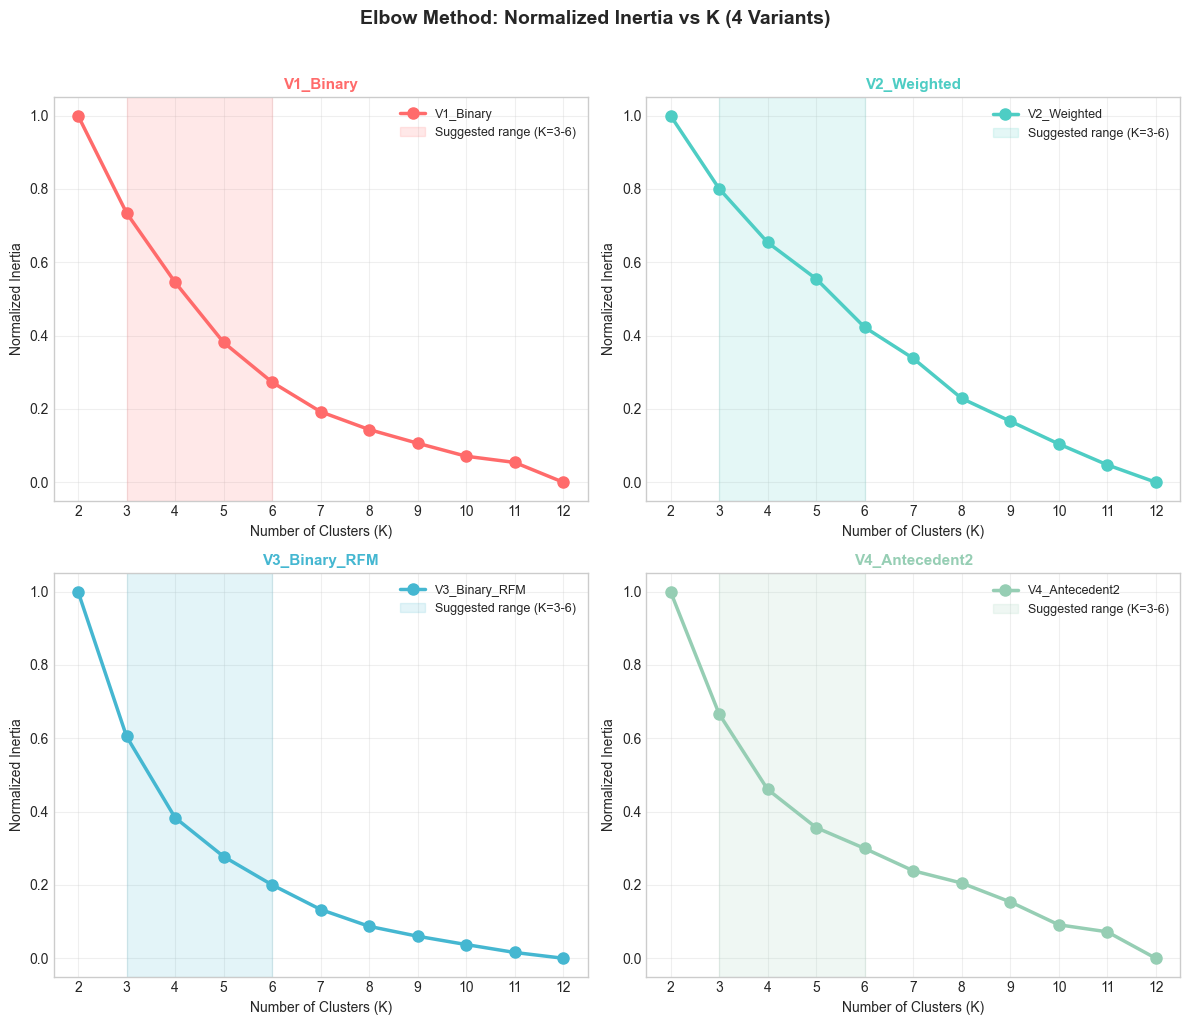


BIỂU ĐỒ 2: SILHOUETTE SCORE
Đã lưu: ../images/Req3_SilhouetteScore.png


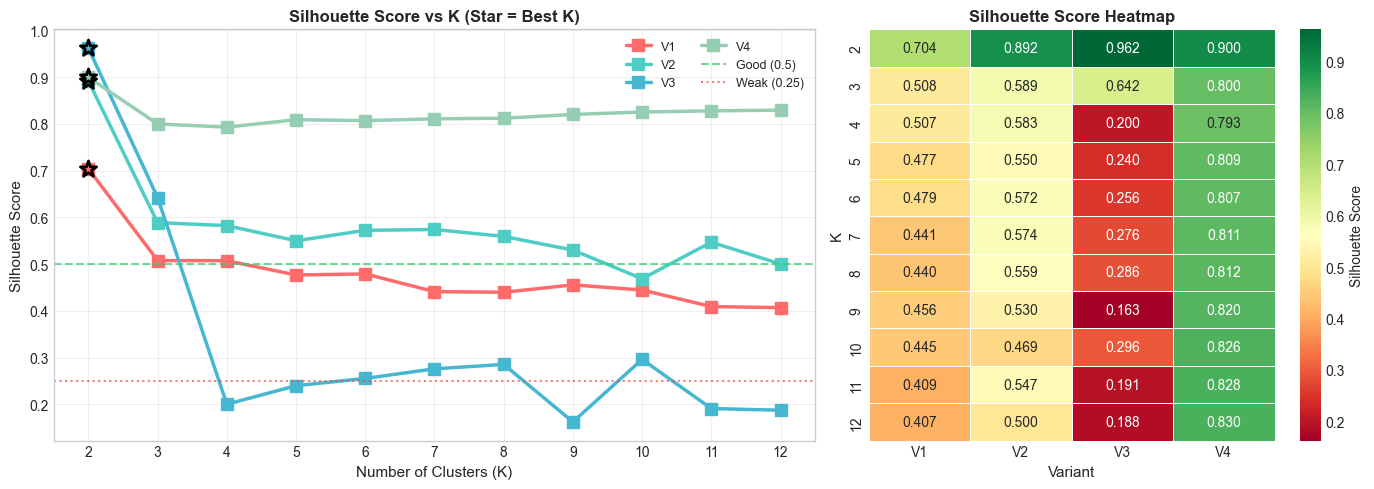


BIỂU ĐỒ 3: SO SÁNH K TỐI ƯU GIỮA CÁC VARIANTS
Đã lưu: ../images/Req3_BestKComparison.png


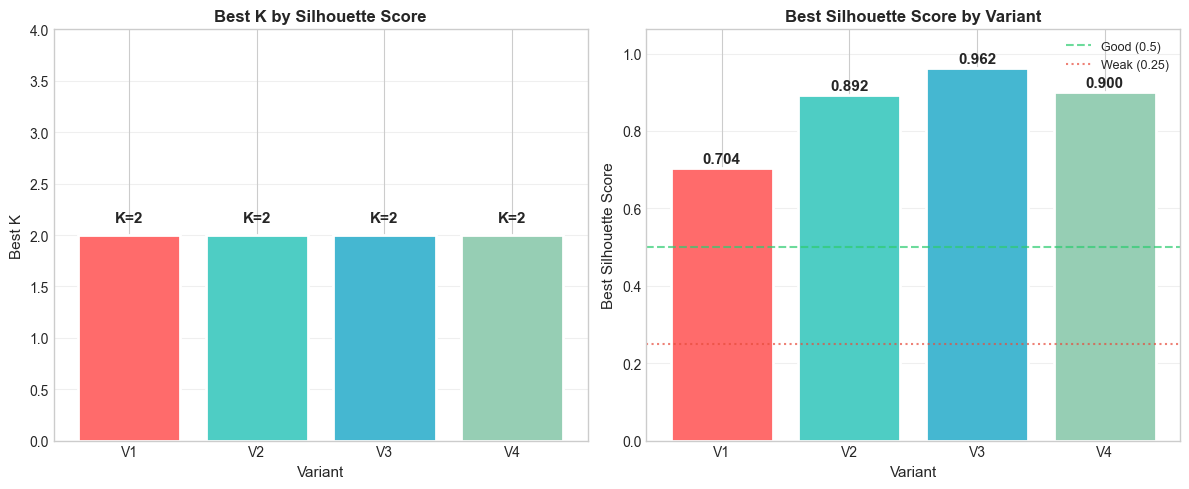


THỐNG KÊ TÓM TẮT

K tốt nhất theo Silhouette Score (mỗi variant):
  V1_Binary           : K =  2 (Silhouette = 0.7039)
  V2_Weighted         : K =  2 (Silhouette = 0.8920)
  V3_Binary_RFM       : K =  2 (Silhouette = 0.9622)
  V4_Antecedent2      : K =  2 (Silhouette = 0.8998)

K trung bình tốt nhất: 2.0
→ Gợi ý sử dụng K = 2 cho tất cả variants


In [112]:
# =============================================================================
# 3.4. TRỰC QUAN HÓA KẾT QUẢ KHẢO SÁT K
# =============================================================================

# Màu sắc cho 4 variants
colors_4 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
variant_names = ['V1_Binary', 'V2_Weighted', 'V3_Binary_RFM', 'V4_Antecedent2']
variant_short = ['V1', 'V2', 'V3', 'V4']

# =============================================================================
# BIỂU ĐỒ 1: ELBOW METHOD (4 SUBPLOTS - NORMALIZED)
# =============================================================================
print("="*70)
print("BIỂU ĐỒ 1: ELBOW METHOD (NORMALIZED)")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, variant in enumerate(variant_names):
    ax = axes[i]
    data = elbow_df[elbow_df['Variant'] == variant].copy()
    
    # Normalize Inertia về [0, 1] để dễ so sánh xu hướng
    inertia_min = data['Inertia'].min()
    inertia_max = data['Inertia'].max()
    data['Inertia_norm'] = (data['Inertia'] - inertia_min) / (inertia_max - inertia_min)
    
    # Vẽ đường normalized
    ax.plot(data['K'], data['Inertia_norm'], marker='o', color=colors_4[i], 
            linewidth=2.5, markersize=8, label=f'{variant}')
    
    # Đánh dấu điểm "khuỷu tay" tiềm năng (giảm mạnh nhất)
    inertia_diff = data['Inertia'].diff().abs()
    elbow_candidates = data[inertia_diff > inertia_diff.median()]['K'].values
    
    # Tô màu vùng gợi ý (K=3-6 thường hợp lý)
    ax.axvspan(3, 6, alpha=0.15, color=colors_4[i], label='Suggested range (K=3-6)')
    
    ax.set_xlabel('Number of Clusters (K)', fontsize=10)
    ax.set_ylabel('Normalized Inertia', fontsize=10)
    ax.set_title(f'{variant}', fontsize=11, fontweight='bold', color=colors_4[i])
    ax.set_xticks(list(K_RANGE))
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)
    ax.set_ylim(-0.05, 1.05)

plt.suptitle('Elbow Method: Normalized Inertia vs K (4 Variants)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

plt.savefig(f'{IMAGES_DIR}/Req3_ElbowMethod.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Đã lưu: {IMAGES_DIR}/Req3_ElbowMethod.png")
plt.show()

# =============================================================================
# BIỂU ĐỒ 2: SILHOUETTE SCORE (LINE CHART + HEATMAP)
# =============================================================================
print("\n" + "="*70)
print("BIỂU ĐỒ 2: SILHOUETTE SCORE")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1.5, 1]})

# --- Chart 2a: Line Chart ---
ax1 = axes[0]
for i, variant in enumerate(variant_names):
    data = silhouette_df[silhouette_df['Variant'] == variant]
    ax1.plot(data['K'], data['Silhouette'], marker='s', color=colors_4[i], 
             linewidth=2.5, markersize=8, label=variant_short[i])
    
    # Đánh dấu điểm best K cho variant này
    best_k = data.loc[data['Silhouette'].idxmax(), 'K']
    best_sil = data['Silhouette'].max()
    ax1.scatter([best_k], [best_sil], s=150, color=colors_4[i], edgecolor='black', 
                linewidth=2, zorder=5, marker='*')

ax1.axhline(y=0.5, color='#2ECC71', linestyle='--', linewidth=1.5, alpha=0.7, label='Good (0.5)')
ax1.axhline(y=0.25, color='#E74C3C', linestyle=':', linewidth=1.5, alpha=0.7, label='Weak (0.25)')

ax1.set_xlabel('Number of Clusters (K)', fontsize=11)
ax1.set_ylabel('Silhouette Score', fontsize=11)
ax1.set_title('Silhouette Score vs K (Star = Best K)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(list(K_RANGE))

# --- Chart 2b: Heatmap ---
ax2 = axes[1]

# Tạo pivot table cho heatmap
heatmap_data = silhouette_df.pivot(index='K', columns='Variant', values='Silhouette')
heatmap_data = heatmap_data[variant_names]  # Sắp xếp cột

# Vẽ heatmap
import seaborn as sns
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            ax=ax2, cbar_kws={'label': 'Silhouette Score'},
            linewidths=0.5, linecolor='white')

ax2.set_title('Silhouette Score Heatmap', fontsize=12, fontweight='bold')
ax2.set_xlabel('Variant', fontsize=11)
ax2.set_ylabel('K', fontsize=11)
ax2.set_xticklabels(variant_short, rotation=0)

plt.tight_layout()

plt.savefig(f'{IMAGES_DIR}/Req3_SilhouetteScore.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Đã lưu: {IMAGES_DIR}/Req3_SilhouetteScore.png")
plt.show()

# =============================================================================
# BIỂU ĐỒ 3: BEST K COMPARISON
# =============================================================================
print("\n" + "="*70)
print("BIỂU ĐỒ 3: SO SÁNH K TỐI ƯU GIỮA CÁC VARIANTS")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Tính best K và best Silhouette cho mỗi variant
best_results = []
for variant in variant_names:
    data = silhouette_df[silhouette_df['Variant'] == variant]
    best_row = data.loc[data['Silhouette'].idxmax()]
    best_results.append({
        'Variant': variant,
        'Best_K': int(best_row['K']),
        'Best_Silhouette': best_row['Silhouette']
    })
df_best = pd.DataFrame(best_results)

# --- Chart 3a: Best K ---
ax1 = axes[0]
bars1 = ax1.bar(variant_short, df_best['Best_K'], color=colors_4, edgecolor='white', linewidth=2)

# Thêm số trên mỗi bar
for bar, k in zip(bars1, df_best['Best_K']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'K={k}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_xlabel('Variant', fontsize=11)
ax1.set_ylabel('Best K', fontsize=11)
ax1.set_title('Best K by Silhouette Score', fontsize=12, fontweight='bold')
ax1.set_ylim(0, max(df_best['Best_K']) + 2)
ax1.grid(axis='y', alpha=0.3)

# --- Chart 3b: Best Silhouette Score ---
ax2 = axes[1]
bars2 = ax2.bar(variant_short, df_best['Best_Silhouette'], color=colors_4, edgecolor='white', linewidth=2)

# Thêm số trên mỗi bar
for bar, sil in zip(bars2, df_best['Best_Silhouette']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{sil:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Thêm đường tham chiếu
ax2.axhline(y=0.5, color='#2ECC71', linestyle='--', linewidth=1.5, alpha=0.7, label='Good (0.5)')
ax2.axhline(y=0.25, color='#E74C3C', linestyle=':', linewidth=1.5, alpha=0.7, label='Weak (0.25)')

ax2.set_xlabel('Variant', fontsize=11)
ax2.set_ylabel('Best Silhouette Score', fontsize=11)
ax2.set_title('Best Silhouette Score by Variant', fontsize=12, fontweight='bold')
ax2.set_ylim(0, max(df_best['Best_Silhouette']) + 0.1)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()

plt.savefig(f'{IMAGES_DIR}/Req3_BestKComparison.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Đã lưu: {IMAGES_DIR}/Req3_BestKComparison.png")
plt.show()

# =============================================================================
# THỐNG KÊ TÓM TẮT
# =============================================================================
print("\n" + "="*70)
print("THỐNG KÊ TÓM TẮT")
print("="*70)

print("\nK tốt nhất theo Silhouette Score (mỗi variant):")
for _, row in df_best.iterrows():
    print(f"  {row['Variant']:20s}: K = {row['Best_K']:2d} (Silhouette = {row['Best_Silhouette']:.4f})")

# Tính K trung bình tốt nhất
avg_best_k = df_best['Best_K'].mean()
print(f"\nK trung bình tốt nhất: {avg_best_k:.1f}")

# Gợi ý K
suggested_k = int(round(avg_best_k))
print(f"→ Gợi ý sử dụng K = {suggested_k} cho tất cả variants")

### 3.5. Phân tích và chọn K tối ưu cho từng Variant

**Tiêu chí chọn K (theo thứ tự ưu tiên):**
1. `CUSTOM_K`: User override trực tiếp
2. `USE_CACHED_K=True`: Load từ file config
3. **AUTO thông minh**: Kết hợp Silhouette Score + Kiểm tra phân bố cluster

**Tiêu chí AUTO mới (Ưu tiên K > 2):**
- Khảo sát K từ 2 đến 12
- Loại bỏ K nếu tạo ra **cluster outlier** (< 2% hoặc < 50 customers)
- **Ưu tiên K > 2** nếu Silhouette chỉ thấp hơn K=2 không đáng kể (dưới ngưỡng `SILHOUETTE_TOLERANCE`)
- Lý do: K=2 thường ít ý nghĩa marketing, K=3,4,5 cho nhiều insight hơn

**Tham số điều chỉnh:**
- `SILHOUETTE_TOLERANCE = 0.05` (5%): Nếu K>2 có Silhouette >= 95% của K=2 → ưu tiên chọn K>2

In [114]:
# =============================================================================
# 3.5. PHÂN TÍCH VÀ CHỌN K TỐI ƯU CHO TỪNG VARIANT
# =============================================================================

print("="*80)
print("PHAN TICH VA CHON K TOI UU (SMART AUTO - UU TIEN K > 2)")
print("="*80)

# -----------------------------------------------------------------------------
# THAM SO DIEU CHINH
# -----------------------------------------------------------------------------
MIN_CLUSTER_PCT = 2.0         # Cluster phai co it nhat 2% customers
MIN_CLUSTER_SIZE = 50         # Cluster phai co it nhat 50 customers
K_CANDIDATE_RANGE = range(2, 13)  # K tu 2 den 12

# ** THAM SO UU TIEN K > 2 **
# Neu K > 2 co Silhouette chi thap hon K=2 duoi nguong nay -> uu tien K > 2
SILHOUETTE_TOLERANCE = 20e-2   # 5% - Co the dieu chinh (0.03 = 3%, 0.10 = 10%)

print(f"\nTHAM SO:")
print(f"   - MIN_CLUSTER_PCT    = {MIN_CLUSTER_PCT}%")
print(f"   - MIN_CLUSTER_SIZE   = {MIN_CLUSTER_SIZE} customers")
print(f"   - K_CANDIDATE_RANGE  = {list(K_CANDIDATE_RANGE)}")
print(f"   - SILHOUETTE_TOLERANCE = {SILHOUETTE_TOLERANCE*100:.1f}% (uu tien K > 2 neu chenh lech duoi nguong)")

# -----------------------------------------------------------------------------
# HAM KIEM TRA PHAN BO CLUSTER
# -----------------------------------------------------------------------------
def check_cluster_distribution(X, k, random_state=42, n_init=10):
    """
    Train KMeans va kiem tra phan bo cluster.
    Returns: (is_valid, silhouette, cluster_dist, min_pct, min_count)
    """
    kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    labels = kmeans.fit_predict(X)
    
    # Tinh Silhouette
    sil = silhouette_score(X, labels)
    
    # Thong ke phan bo
    unique, counts = np.unique(labels, return_counts=True)
    cluster_dist = dict(zip(unique, counts))
    total = len(labels)
    
    # Tim cluster nho nhat
    min_count = min(counts)
    min_pct = (min_count / total) * 100
    
    # Kiem tra dieu kien
    is_valid = (min_pct >= MIN_CLUSTER_PCT) and (min_count >= MIN_CLUSTER_SIZE)
    
    return is_valid, sil, cluster_dist, min_pct, min_count

# -----------------------------------------------------------------------------
# 1. PHAN TICH SILHOUETTE SCORE TU FILE
# -----------------------------------------------------------------------------
auto_best_k = {}

if silhouette_df is not None and len(silhouette_df) > 0:
    print("\n" + "="*80)
    print("1. BANG SILHOUETTE SCORE (tu experiments):")
    print("-"*80)
    
    silhouette_pivot = silhouette_df.pivot(index='K', columns='Variant', values='Silhouette')
    silhouette_pivot = silhouette_pivot[variant_names]
    display(silhouette_pivot.round(4))

# -----------------------------------------------------------------------------
# 2. SMART AUTO: KIEM TRA PHAN BO CLUSTER + UU TIEN K > 2
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("2. SMART AUTO: KIEM TRA PHAN BO CLUSTER + UU TIEN K > 2")
print("="*80)
print(f"   Dieu kien hop le: Min cluster >= {MIN_CLUSTER_PCT}% VA >= {MIN_CLUSTER_SIZE} customers")
print(f"   Uu tien K > 2  : Neu Silhouette chi thap hon K=2 duoi {SILHOUETTE_TOLERANCE*100:.1f}%")
print("-"*80)

for variant in variant_names:
    X = feature_variants[variant]
    n_samples = X.shape[0]
    
    print(f"\n   {variant} ({n_samples:,} customers):")
    
    valid_k_options = []  # List cac K hop le: [{'K': k, 'Silhouette': sil}, ...]
    
    for k in K_CANDIDATE_RANGE:
        is_valid, sil, cluster_dist, min_pct, min_count = check_cluster_distribution(
            X, k, RANDOM_STATE, N_INIT
        )
        
        status = "OK" if is_valid else "OUTLIER"
        icon = "v" if is_valid else "x"
        
        # Hien thi ket qua
        dist_str = ", ".join([f"C{c}:{cnt}" for c, cnt in sorted(cluster_dist.items())])
        print(f"      K={k:2d}: Sil={sil:.4f} | Min={min_count:4d}({min_pct:5.1f}%) | [{icon}] {status}")
        print(f"            Dist: {dist_str}")
        
        if is_valid:
            valid_k_options.append({'K': k, 'Silhouette': sil})
    
    # -------------------------------------------------------------------------
    # CHON K TOT NHAT VOI UU TIEN K > 2
    # -------------------------------------------------------------------------
    if valid_k_options:
        # Sap xep theo Silhouette giam dan
        valid_k_options.sort(key=lambda x: x['Silhouette'], reverse=True)
        
        # Tim Silhouette cua K=2 (neu co)
        sil_k2 = None
        for opt in valid_k_options:
            if opt['K'] == 2:
                sil_k2 = opt['Silhouette']
                break
        
        # Tim K > 2 co Silhouette cao nhat
        best_k_gt2 = None
        sil_best_gt2 = None
        for opt in valid_k_options:
            if opt['K'] > 2:
                if best_k_gt2 is None or opt['Silhouette'] > sil_best_gt2:
                    best_k_gt2 = opt['K']
                    sil_best_gt2 = opt['Silhouette']
        
        # Logic chon K
        best_overall = valid_k_options[0]  # K co Silhouette cao nhat
        
        if best_overall['K'] == 2 and best_k_gt2 is not None and sil_k2 is not None:
            # K=2 co Silhouette cao nhat, nhung kiem tra xem K > 2 co du gan khong
            diff = sil_k2 - sil_best_gt2
            diff_pct = diff / sil_k2 if sil_k2 > 0 else 0
            
            print(f"\n      [SMART CHECK] K=2 Sil={sil_k2:.4f} vs K={best_k_gt2} Sil={sil_best_gt2:.4f}")
            print(f"                    Chenh lech: {diff:.4f} ({diff_pct*100:.2f}%)")
            
            if diff_pct <= SILHOUETTE_TOLERANCE:
                # Chenh lech duoi nguong -> Uu tien K > 2
                auto_best_k[variant] = best_k_gt2
                print(f"      --> CHON: K={best_k_gt2} (UU TIEN K > 2, chenh lech {diff_pct*100:.2f}% <= {SILHOUETTE_TOLERANCE*100:.1f}%)")
            else:
                # Chenh lech qua lon -> Giu K=2
                auto_best_k[variant] = 2
                print(f"      --> CHON: K=2 (chenh lech {diff_pct*100:.2f}% > {SILHOUETTE_TOLERANCE*100:.1f}%, giu K=2)")
        else:
            # K=2 khong phai tot nhat hoac khong co K > 2 hop le
            auto_best_k[variant] = best_overall['K']
            print(f"      --> CHON: K={best_overall['K']} (Sil={best_overall['Silhouette']:.4f})")
    else:
        # Khong co K hop le -> Chon K=2 (fallback)
        print(f"      --> CANH BAO: Khong co K hop le! Chon K=2 (fallback)")
        auto_best_k[variant] = 2

# -----------------------------------------------------------------------------
# 3. XAC DINH K CUOI CUNG
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("3. XAC DINH K CUOI CUNG CHO MOI VARIANT")
print("="*80)

K_PER_VARIANT = get_k_per_variant(
    cached_config=cached_config if USE_CACHED_K else None,
    custom_k=CUSTOM_K,
    auto_k=auto_best_k
)

# -----------------------------------------------------------------------------
# 4. HIEN THI QUYET DINH
# -----------------------------------------------------------------------------
print("\n" + "-"*80)
print("BANG QUYET DINH K:")
print("-"*80)
print("""
   +--------------------+-------+------------------------------------------+
   | Variant            |   K   | Nguon                                    |
   +--------------------+-------+------------------------------------------+""")

for variant in variant_names:
    k = K_PER_VARIANT[variant]
    if CUSTOM_K.get(variant) is not None:
        source = "CUSTOM (user override)"
    elif USE_CACHED_K and cached_config and variant in cached_config:
        source = "CACHE (tu lan chay truoc)"
    else:
        source = "SMART AUTO (Sil + K>2 Priority)"
    print(f"   | {variant:18s} |   {k}   | {source:40s} |")

print("   +--------------------+-------+------------------------------------------+")

# -----------------------------------------------------------------------------
# 5. THONG KE SILHOUETTE TAI K DA CHON
# -----------------------------------------------------------------------------
if silhouette_df is not None:
    print("\n" + "-"*80)
    print("SILHOUETTE SCORE TAI K DA CHON:")
    print("-"*80)
    
    for variant in variant_names:
        k = K_PER_VARIANT[variant]
        row = silhouette_df[(silhouette_df['Variant'] == variant) & (silhouette_df['K'] == k)]
        if len(row) > 0:
            sil = row['Silhouette'].values[0]
            quality = "Excellent" if sil > 0.7 else "Good" if sil > 0.5 else "Fair" if sil > 0.25 else "Weak"
            print(f"   * {variant:20s}: K={k} -> Silhouette = {sil:.4f} ({quality})")
        else:
            # Neu khong co trong file, tinh lai
            _, sil_calc, _, _, _ = check_cluster_distribution(
                feature_variants[variant], k, RANDOM_STATE, N_INIT
            )
            quality = "Excellent" if sil_calc > 0.7 else "Good" if sil_calc > 0.5 else "Fair" if sil_calc > 0.25 else "Weak"
            print(f"   * {variant:20s}: K={k} -> Silhouette = {sil_calc:.4f} ({quality}) [calculated]")

# -----------------------------------------------------------------------------
# 6. TOM TAT THAY DOI
# -----------------------------------------------------------------------------
print("\n" + "-"*80)
print("LUU Y VE THAM SO SILHOUETTE_TOLERANCE:")
print("-"*80)
print(f"   Hien tai: SILHOUETTE_TOLERANCE = {SILHOUETTE_TOLERANCE*100:.1f}%")
print(f"   Y nghia: Neu K > 2 co Silhouette thap hon K=2 duoi {SILHOUETTE_TOLERANCE*100:.1f}%, se uu tien K > 2")
print(f"   Dieu chinh: Tang SILHOUETTE_TOLERANCE neu muon K > 2 de duoc chon hon")
print(f"               Giam SILHOUETTE_TOLERANCE neu muon chat che hon voi Silhouette")

logger.info(f"K duoc chon (Smart Auto + K>2 Priority): {K_PER_VARIANT}")

PHAN TICH VA CHON K TOI UU (SMART AUTO - UU TIEN K > 2)

THAM SO:
   - MIN_CLUSTER_PCT    = 2.0%
   - MIN_CLUSTER_SIZE   = 50 customers
   - K_CANDIDATE_RANGE  = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
   - SILHOUETTE_TOLERANCE = 20.0% (uu tien K > 2 neu chenh lech duoi nguong)

1. BANG SILHOUETTE SCORE (tu experiments):
--------------------------------------------------------------------------------


Variant,V1_Binary,V2_Weighted,V3_Binary_RFM,V4_Antecedent2
K,,,,
2,0.7039,0.8920,0.9622,0.8998
3,0.5078,0.5889,0.6425,0.8000
4,0.5074,0.5825,0.2004,0.7932
5,0.4769,0.5501,0.2400,0.8091
6,0.4792,0.5724,0.2556,0.8072
7,0.4413,0.5742,0.2761,0.8109
8,0.4399,0.5594,0.2856,0.8123
9,0.4557,0.5302,0.1626,0.8203
10,0.4447,0.4688,0.2963,0.8256



2. SMART AUTO: KIEM TRA PHAN BO CLUSTER + UU TIEN K > 2
   Dieu kien hop le: Min cluster >= 2.0% VA >= 50 customers
   Uu tien K > 2  : Neu Silhouette chi thap hon K=2 duoi 20.0%
--------------------------------------------------------------------------------

   V1_Binary (3,921 customers):
      K= 2: Sil=0.7039 | Min= 125(  3.2%) | [v] OK
            Dist: C0:3796, C1:125
      K= 3: Sil=0.5078 | Min= 124(  3.2%) | [v] OK
            Dist: C0:3443, C1:354, C2:124
      K= 4: Sil=0.5074 | Min= 116(  3.0%) | [v] OK
            Dist: C0:333, C1:116, C2:124, C3:3348
      K= 5: Sil=0.4769 | Min= 112(  2.9%) | [v] OK
            Dist: C0:3125, C1:124, C2:253, C3:307, C4:112
      K= 6: Sil=0.4792 | Min= 112(  2.9%) | [v] OK
            Dist: C0:181, C1:3105, C2:124, C3:112, C4:242, C5:157
      K= 7: Sil=0.4413 | Min= 111(  2.8%) | [v] OK
            Dist: C0:181, C1:2851, C2:124, C3:231, C4:146, C5:277, C6:111
      K= 8: Sil=0.4399 | Min=  24(  0.6%) | [x] OUTLIER
            Dist: C0

2025-12-30 03:55:29,825 | INFO | K duoc chon (Smart Auto + K>2 Priority): {'V1_Binary': 2, 'V2_Weighted': 2, 'V3_Binary_RFM': 2, 'V4_Antecedent2': 5}


      K=12: Sil=0.8295 | Min=   5(  0.1%) | [x] OUTLIER
            Dist: C0:3260, C1:14, C2:190, C3:129, C4:7, C5:105, C6:5, C7:8, C8:6, C9:78, C10:30, C11:89

      [SMART CHECK] K=2 Sil=0.8998 vs K=5 Sil=0.8091
                    Chenh lech: 0.0906 (10.07%)
      --> CHON: K=5 (UU TIEN K > 2, chenh lech 10.07% <= 20.0%)

3. XAC DINH K CUOI CUNG CHO MOI VARIANT
  V1_Binary: K = 2 (AUTO từ Silhouette)
  V2_Weighted: K = 2 (AUTO từ Silhouette)
  V3_Binary_RFM: K = 2 (AUTO từ Silhouette)
  V4_Antecedent2: K = 5 (AUTO từ Silhouette)

--------------------------------------------------------------------------------
BANG QUYET DINH K:
--------------------------------------------------------------------------------

   +--------------------+-------+------------------------------------------+
   | Variant            |   K   | Nguon                                    |
   +--------------------+-------+------------------------------------------+
   | V1_Binary          |   2   | SMART AUTO (Si

### 3.6. Huấn luyện K-Means với K riêng cho từng Variant

Mỗi variant được huấn luyện với **K tối ưu riêng** đã xác định ở bước 3.5.
Điều này cho phép mỗi biến thể feature đạt được chất lượng clustering tốt nhất.

In [ ]:
# =============================================================================
# TONG KET GIA TRI K DUOC SU DUNG CHO MOI VARIANT
# =============================================================================

print("="*70)
print("       TONG KET GIA TRI K DUOC SU DUNG")
print("="*70)
print("""
   ╔══════════════════════════════════════════════════════════════════╗
   ║   Variant                │   K   │            Source             ║
   ╠══════════════════════════════════════════════════════════════════╣""")

for variant in variant_names:
    k = K_PER_VARIANT[variant]
    # Xac dinh nguon
    if CUSTOM_K.get(variant) is not None:
        source = "CUSTOM"
        icon = "[*]"
    elif USE_CACHED_K and cached_config and variant in cached_config:
        source = "CACHE"
        icon = "[C]"
    else:
        source = "AUTO"
        icon = "[A]"
    
    # Lay Silhouette score tai K nay
    if silhouette_df is not None:
        row = silhouette_df[(silhouette_df['Variant'] == variant) & (silhouette_df['K'] == k)]
        if len(row) > 0:
            sil = row['Silhouette'].values[0]
            sil_str = f"Sil={sil:.4f}"
        else:
            sil_str = "Sil=N/A"
    else:
        sil_str = "Sil=N/A"
    
    print(f"   ║   {icon} {variant:18s} │   {k}   │   {source:6s} ({sil_str})         ║")

print("""
   ╠══════════════════════════════════════════════════════════════════╣
   ║   [*] = CUSTOM override    [C] = CACHE    [A] = AUTO             ║
   ╚══════════════════════════════════════════════════════════════════╝
""")

# Hien thi dang DataFrame de de doc
print("\nBang tong hop:")
df_k_summary = pd.DataFrame([
    {
        'Variant': v,
        'K': K_PER_VARIANT[v],
        'Nguon': 'CUSTOM' if CUSTOM_K.get(v) is not None else ('CACHE' if USE_CACHED_K and cached_config and v in cached_config else 'AUTO')
    }
    for v in variant_names
])
display(df_k_summary)

print("\n" + "-"*70)
print("San sang huan luyen K-Means voi cac gia tri K tren!")
print("-"*70)

       TONG KET GIA TRI K DUOC SU DUNG

   ╔══════════════════════════════════════════════════════════════════╗
   ║   Variant                │   K   │            Source             ║
   ╠══════════════════════════════════════════════════════════════════╣
   ║   [A] V1_Binary          │   2   │   AUTO   (Sil=0.7039)         ║
   ║   [A] V2_Weighted        │   2   │   AUTO   (Sil=0.8920)         ║
   ║   [A] V3_Binary_RFM      │   2   │   AUTO   (Sil=0.9622)         ║
   ║   [A] V4_Antecedent2     │   5   │   AUTO   (Sil=0.8091)         ║

   ╠══════════════════════════════════════════════════════════════════╣
   ║   [*] = CUSTOM override    [C] = CACHE    [A] = AUTO             ║
   ╚══════════════════════════════════════════════════════════════════╝


Bang tong hop:


,Variant,K,Nguon
0,V1_Binary,2,AUTO
1,V2_Weighted,2,AUTO
2,V3_Binary_RFM,2,AUTO
3,V4_Antecedent2,5,AUTO



----------------------------------------------------------------------
San sang huan luyen K-Means voi cac gia tri K tren!
----------------------------------------------------------------------


In [ ]:
# =============================================================================
# 3.6. HUẤN LUYỆN K-MEANS VỚI K RIÊNG CHO TỪNG VARIANT
# =============================================================================

print("="*70)
print("HUẤN LUYỆN K-MEANS")
print("="*70)

# Dictionary lưu kết quả
kmeans_models = {}
cluster_labels = {}
cluster_stats = []

for variant_name, X in feature_variants.items():
    # Lấy K cho variant này
    k = K_PER_VARIANT[variant_name]
    
    start_time = time.time()
    
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, n_init=N_INIT, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X)
    
    # Tính Silhouette score
    sil_score = silhouette_score(X, labels)
    
    elapsed = time.time() - start_time
    
    # Lưu model và labels
    kmeans_models[variant_name] = kmeans
    cluster_labels[variant_name] = labels
    
    # Thống kê số lượng mỗi cluster
    unique, counts = np.unique(labels, return_counts=True)
    cluster_dist = dict(zip(unique, counts))
    
    stats = {
        'Variant': variant_name,
        'K': k,
        'Silhouette': round(sil_score, 4),
        'Inertia': round(kmeans.inertia_, 2),
        'Time_sec': round(elapsed, 3)
    }
    
    # Thêm số lượng mỗi cluster (dynamic based on K)
    for c in range(k):
        stats[f'C{c}_Count'] = cluster_dist.get(c, 0)
        stats[f'C{c}_Pct'] = round(cluster_dist.get(c, 0) / len(labels) * 100, 1)
    
    cluster_stats.append(stats)
    
    logger.info(f"{variant_name}: K={k}, Silhouette={sil_score:.4f}, Time={elapsed:.2f}s")
    
    print(f"\n{variant_name} (K={k}):")
    print(f"  • Silhouette Score: {sil_score:.4f}")
    print(f"  • Inertia: {kmeans.inertia_:,.2f}")
    print(f"  • Cluster distribution:")
    for c, cnt in cluster_dist.items():
        pct = cnt / len(labels) * 100
        print(f"    - Cluster {c}: {cnt:,} customers ({pct:.1f}%)")

# Tạo DataFrame thống kê
df_cluster_stats = pd.DataFrame(cluster_stats)

print("\n" + "="*70)
print("BẢNG TỔNG HỢP KẾT QUẢ CLUSTERING")
print("="*70)

# Hiển thị bảng chính
display_cols = ['Variant', 'K', 'Silhouette', 'Inertia']
display(df_cluster_stats[display_cols])

# Phân tích so sánh
print("\n" + "-"*70)
print("NHẬN XÉT:")
print("-"*70)

best_variant = df_cluster_stats.loc[df_cluster_stats['Silhouette'].idxmax(), 'Variant']
best_sil = df_cluster_stats['Silhouette'].max()
best_k = df_cluster_stats.loc[df_cluster_stats['Silhouette'].idxmax(), 'K']

print(f"""
  • Variant tốt nhất: {best_variant} (K={best_k}, Silhouette={best_sil:.4f})
  
  Phân tích:
  - Mỗi variant được huấn luyện với K tối ưu riêng
  - Silhouette > 0.5: Cấu trúc cluster rõ ràng
  - Silhouette 0.25-0.5: Cấu trúc trung bình
  - Silhouette < 0.25: Cấu trúc yếu (cần xem xét lại)
""")

# Lưu thống kê
stats_file = f"{EXPERIMENT_DIR}/kmeans_final_stats.csv"
df_cluster_stats.to_csv(stats_file, index=False)
print(f"Đã lưu: {stats_file}")

HUẤN LUYỆN K-MEANS


2025-12-30 03:30:15,937 | INFO | V1_Binary: K=2, Silhouette=0.7039, Time=0.43s



V1_Binary (K=2):
  • Silhouette Score: 0.7039
  • Inertia: 17,604.41
  • Cluster distribution:
    - Cluster 0: 3,796 customers (96.8%)
    - Cluster 1: 125 customers (3.2%)


2025-12-30 03:30:16,376 | INFO | V2_Weighted: K=2, Silhouette=0.8920, Time=0.44s



V2_Weighted (K=2):
  • Silhouette Score: 0.8920
  • Inertia: 9,015,844.00
  • Cluster distribution:
    - Cluster 0: 3,797 customers (96.8%)
    - Cluster 1: 124 customers (3.2%)


2025-12-30 03:30:16,821 | INFO | V3_Binary_RFM: K=2, Silhouette=0.9622, Time=0.44s



V3_Binary_RFM (K=2):
  • Silhouette Score: 0.9622
  • Inertia: 27,820.19
  • Cluster distribution:
    - Cluster 0: 3,920 customers (100.0%)
    - Cluster 1: 1 customers (0.0%)


2025-12-30 03:30:17,221 | INFO | V4_Antecedent2: K=5, Silhouette=0.8091, Time=0.40s



V4_Antecedent2 (K=5):
  • Silhouette Score: 0.8091
  • Inertia: 1,194.58
  • Cluster distribution:
    - Cluster 0: 3,339 customers (85.2%)
    - Cluster 1: 124 customers (3.2%)
    - Cluster 2: 133 customers (3.4%)
    - Cluster 3: 202 customers (5.2%)
    - Cluster 4: 123 customers (3.1%)

BẢNG TỔNG HỢP KẾT QUẢ CLUSTERING


,Variant,K,Silhouette,Inertia
0,V1_Binary,2,0.7039,17604.41
1,V2_Weighted,2,0.8920,9015844.00
2,V3_Binary_RFM,2,0.9622,27820.19
3,V4_Antecedent2,5,0.8091,1194.58



----------------------------------------------------------------------
NHẬN XÉT:
----------------------------------------------------------------------

  • Variant tốt nhất: V3_Binary_RFM (K=2, Silhouette=0.9622)

  Phân tích:
  - Mỗi variant được huấn luyện với K tối ưu riêng
  - Silhouette > 0.5: Cấu trúc cluster rõ ràng
  - Silhouette 0.25-0.5: Cấu trúc trung bình
  - Silhouette < 0.25: Cấu trúc yếu (cần xem xét lại)

Đã lưu: ../data/mini_project/clustering_experiments/kmeans_final_stats.csv


### 3.7. Lưu kết quả phân cụm và cập nhật Config

Bước này thực hiện:
1. Lưu nhãn cụm cho từng variant vào file CSV riêng
2. Tạo file tổng hợp tất cả variants
3. **Cập nhật `optimal_k_config.json`** để lần sau có thể reload

In [115]:
# =============================================================================
# 3.7. LUU KET QUA PHAN CUM VA CAP NHAT CONFIG
# =============================================================================

print("="*70)
print("LƯU KẾT QUẢ PHÂN CỤM")
print("="*70)

# -----------------------------------------------------------------------------
# 1. Lay danh sach CustomerID
# -----------------------------------------------------------------------------
try:
    if 'customers' not in dir() or customers is None:
        df_temp = pd.read_csv(f"{DATA_OUTPUT_DIR}/feature_matrix_v1_binary.csv")
        customers = df_temp['CustomerID'].values
except:
    df_temp = pd.read_csv(f"{DATA_OUTPUT_DIR}/feature_matrix_v1_binary.csv")
    customers = df_temp['CustomerID'].values

print(f"Số lượng khách hàng: {len(customers):,}")

# -----------------------------------------------------------------------------
# 2. Luu cluster labels cho tung variant
# -----------------------------------------------------------------------------
variant_short_names = {
    'V1_Binary': 'v1',
    'V2_Weighted': 'v2',
    'V3_Binary_RFM': 'v3',
    'V4_Antecedent2': 'v4'
}

saved_files = []
for vname, labels in cluster_labels.items():
    short_name = variant_short_names[vname]
    k = K_PER_VARIANT[vname]
    
    # Tao DataFrame
    df_result = pd.DataFrame({
        'CustomerID': customers,
        'Cluster': labels
    })
    
    # Luu file voi ten bao gom K
    output_file = f"{DATA_OUTPUT_DIR}/customer_clusters_{short_name}_k{k}.csv"
    df_result.to_csv(output_file, index=False)
    saved_files.append(output_file)
    
    # Hien thi thong ke
    print(f"\n[OK] {vname} (K={k}):")
    print(f"  File: {output_file}")
    dist = df_result['Cluster'].value_counts().sort_index()
    for c, cnt in dist.items():
        pct = cnt / len(labels) * 100
        print(f"  - Cluster {c}: {cnt:,} ({pct:.1f}%)")

# -----------------------------------------------------------------------------
# 3. Tao file tong hop
# -----------------------------------------------------------------------------
df_all_clusters = pd.DataFrame({'CustomerID': customers})
for vname, labels in cluster_labels.items():
    short_name = variant_short_names[vname]
    k = K_PER_VARIANT[vname]
    df_all_clusters[f'Cluster_{short_name}_k{k}'] = labels

all_clusters_file = f"{DATA_OUTPUT_DIR}/customer_clusters_all_variants.csv"
df_all_clusters.to_csv(all_clusters_file, index=False)

print(f"\n{'='*70}")
print(f"[OK] FILE TỔNG HỢP: {all_clusters_file}")
print(f"  Shape: {df_all_clusters.shape}")
print(f"{'='*70}")

# Hien thi mau du lieu
print("\nMẫu 10 dòng đầu:")
display(df_all_clusters.head(10))

# -----------------------------------------------------------------------------
# 4. Cap nhat Config file
# -----------------------------------------------------------------------------
print("\n" + "="*70)
print("CẬP NHẬT CONFIG FILE")
print("="*70)

# Tao config moi voi ten bien khac de tranh xung dot
config_to_save = {}
for vname in variant_names:
    k = K_PER_VARIANT[vname]
    
    # Lay Silhouette tu ket qua training
    sil = df_cluster_stats[df_cluster_stats['Variant'] == vname]['Silhouette'].values[0]
    
    config_to_save[vname] = {
        'K': int(k),
        'Silhouette': float(sil)
    }

# Luu config
save_k_config(config_to_save, CONFIG_FILE)

# In ket qua
print("\nConfig đã lưu:")
for vname in variant_names:
    k_val = config_to_save[vname]['K']
    sil_val = config_to_save[vname]['Silhouette']
    print(f"  - {vname}: K={k_val} (Silhouette={sil_val:.4f})")

print(f"\n[TIP] Lần sau, đặt USE_CACHED_K = True ở Cell 3.1 để sử dụng K này!")

logger.info(f"Đã lưu {len(saved_files) + 1} files kết quả phân cụm")
logger.info(f"Config saved: {CONFIG_FILE}")

LƯU KẾT QUẢ PHÂN CỤM
Số lượng khách hàng: 3,921

[OK] V1_Binary (K=2):
  File: ../data/mini_project/customer_clusters_v1_k2.csv
  - Cluster 0: 3,796 (96.8%)
  - Cluster 1: 125 (3.2%)

[OK] V2_Weighted (K=2):
  File: ../data/mini_project/customer_clusters_v2_k2.csv
  - Cluster 0: 3,797 (96.8%)
  - Cluster 1: 124 (3.2%)

[OK] V3_Binary_RFM (K=2):
  File: ../data/mini_project/customer_clusters_v3_k2.csv
  - Cluster 0: 3,920 (100.0%)
  - Cluster 1: 1 (0.0%)

[OK] V4_Antecedent2 (K=5):
  File: ../data/mini_project/customer_clusters_v4_k5.csv
  - Cluster 0: 3,339 (85.2%)
  - Cluster 1: 124 (3.2%)
  - Cluster 2: 133 (3.4%)
  - Cluster 3: 202 (5.2%)
  - Cluster 4: 123 (3.1%)

[OK] FILE TỔNG HỢP: ../data/mini_project/customer_clusters_all_variants.csv
  Shape: (3921, 5)

Mẫu 10 dòng đầu:


,CustomerID,Cluster_v1_k2,Cluster_v2_k2,Cluster_v3_k2,Cluster_v4_k5
0,000nan,1,1,1,1
1,012346,0,0,0,0
2,012747,0,0,0,0
3,012748,1,1,0,1
4,012749,0,0,0,0
5,012820,0,0,0,0
6,012821,0,0,0,0
7,012822,0,0,0,3
8,012823,0,0,0,0
9,012824,0,0,0,0


2025-12-30 03:57:07,581 | INFO | Đã lưu 5 files kết quả phân cụm
2025-12-30 03:57:07,581 | INFO | Config saved: ../data/mini_project/clustering_experiments/optimal_k_config.json



CẬP NHẬT CONFIG FILE
✓ Đã lưu config: ../data/mini_project/clustering_experiments/optimal_k_config.json

Config đã lưu:
  - V1_Binary: K=2 (Silhouette=0.7039)
  - V2_Weighted: K=2 (Silhouette=0.8920)
  - V3_Binary_RFM: K=2 (Silhouette=0.9622)
  - V4_Antecedent2: K=5 (Silhouette=0.8091)

[TIP] Lần sau, đặt USE_CACHED_K = True ở Cell 3.1 để sử dụng K này!


## 4. Yêu cầu 4
+ Kết quả phân cụm cần được trực quan hóa và đánh giá ở mức tối thiểu.
+ Mỗi nhóm phải thực hiện giảm chiều về 2D bằng PCA hoặc SVD và vẽ scatter plot, tô màu theo cluster để người đọc thấy mức độ tách cụm (tách rõ hay chồng lấn).
+ Nhóm cần nhận xét ngắn về biểu đồ, tránh nhận xét chung chung mà cần bám vào hình ảnh.

### 4.1. Load Data & Configuration

In [116]:
# =============================================================================
# 4.1. LOAD DATA & CONFIGURATION
# =============================================================================
# Load feature matrices và cluster labels từ Yêu cầu 3
# Setup visualization parameters

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial import ConvexHull
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("YÊU CẦU 4: TRỰC QUAN HÓA 2D - PCA & SVD")
print("="*70)

# -----------------------------------------------------------------------------
# 1. Configuration
# -----------------------------------------------------------------------------
VARIANT_NAMES = ['V1_Binary', 'V2_Weighted', 'V3_Binary_RFM', 'V4_Antecedent2']
VARIANT_FILES = {
    'V1_Binary': 'feature_matrix_v1_binary.csv',
    'V2_Weighted': 'feature_matrix_v2_weighted.csv',
    'V3_Binary_RFM': 'feature_matrix_v3_binary_rfm.csv',
    'V4_Antecedent2': 'feature_matrix_v4_antecedent2.csv'
}
CLUSTER_FILES = {
    'V1_Binary': 'customer_clusters_v1_k2.csv',
    'V2_Weighted': 'customer_clusters_v2_k2.csv',
    'V3_Binary_RFM': 'customer_clusters_v3_k2.csv',
    'V4_Antecedent2': 'customer_clusters_v4_k5.csv'
}

# K values từ Yêu cầu 3
K_VALUES = {'V1_Binary': 2, 'V2_Weighted': 2, 'V3_Binary_RFM': 2, 'V4_Antecedent2': 5}

# Color palettes
COLORS_K2 = ['#3498db', '#e74c3c']  # Blue, Red
COLORS_K5 = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']  # Blue, Green, Orange, Red, Purple

# Plot settings
FIGURE_SIZE = (14, 12)
ALPHA = 0.6
MARKER_SIZE = 30
RANDOM_STATE = 42

# -----------------------------------------------------------------------------
# 2. Load Feature Matrices & Cluster Labels
# -----------------------------------------------------------------------------
print("\n[1] ĐANG TẢI DỮ LIỆU...")

feature_data = {}
cluster_data = {}
data_info = []

for variant in VARIANT_NAMES:
    # Load feature matrix
    feature_path = f"{DATA_OUTPUT_DIR}/{VARIANT_FILES[variant]}"
    df_features = pd.read_csv(feature_path)
    
    # Tách CustomerID và features
    customer_ids = df_features['CustomerID'].values
    feature_cols = [c for c in df_features.columns if c != 'CustomerID']
    X = df_features[feature_cols].values
    
    # Load cluster labels
    cluster_path = f"{DATA_OUTPUT_DIR}/{CLUSTER_FILES[variant]}"
    df_clusters = pd.read_csv(cluster_path)
    labels = df_clusters['Cluster'].values
    
    # Lưu vào dict
    feature_data[variant] = {
        'X': X,
        'customers': customer_ids,
        'feature_cols': feature_cols
    }
    cluster_data[variant] = labels
    
    # Thống kê
    n_customers = len(customer_ids)
    n_features = len(feature_cols)
    k = K_VALUES[variant]
    
    data_info.append({
        'Variant': variant,
        'Customers': n_customers,
        'Features': n_features,
        'K': k
    })
    
    print(f"  [OK] {variant}: {n_customers:,} khách hàng x {n_features} features, K={k}")

# Hiển thị bảng tóm tắt
print("\n" + "="*70)
print("TÓM TẮT DỮ LIỆU ĐÃ TẢI")
print("="*70)
df_data_info = pd.DataFrame(data_info)
display(df_data_info)

print("\n[OK] Đã tải xong dữ liệu cho 4 variants!")

YÊU CẦU 4: TRỰC QUAN HÓA 2D - PCA & SVD

[1] ĐANG TẢI DỮ LIỆU...
  [OK] V1_Binary: 3,921 khách hàng x 200 features, K=2
  [OK] V2_Weighted: 3,921 khách hàng x 200 features, K=2
  [OK] V3_Binary_RFM: 3,921 khách hàng x 203 features, K=2
  [OK] V4_Antecedent2: 3,921 khách hàng x 63 features, K=5

TÓM TẮT DỮ LIỆU ĐÃ TẢI


,Variant,Customers,Features,K
0,V1_Binary,3921,200,2
1,V2_Weighted,3921,200,2
2,V3_Binary_RFM,3921,203,2
3,V4_Antecedent2,3921,63,5



[OK] Đã tải xong dữ liệu cho 4 variants!


### 4.2. Dimensionality Reduction: PCA

PCA - PRINCIPAL COMPONENT ANALYSIS

[1] THỰC HIỆN PCA...
  V1_Binary: PC1=25.9%, PC2=10.8%, Tổng=36.7%
  V2_Weighted: PC1=74.4%, PC2=3.8%, Tổng=78.1%
  V3_Binary_RFM: PC1=24.1%, PC2=16.0%, Tổng=40.1%
  V4_Antecedent2: PC1=63.7%, PC2=9.6%, Tổng=73.3%

[2] VẼ BIỂU ĐỒ PCA...

[OK] Đã lưu: ../images/Req4_PCA_ClusterSeparation.png


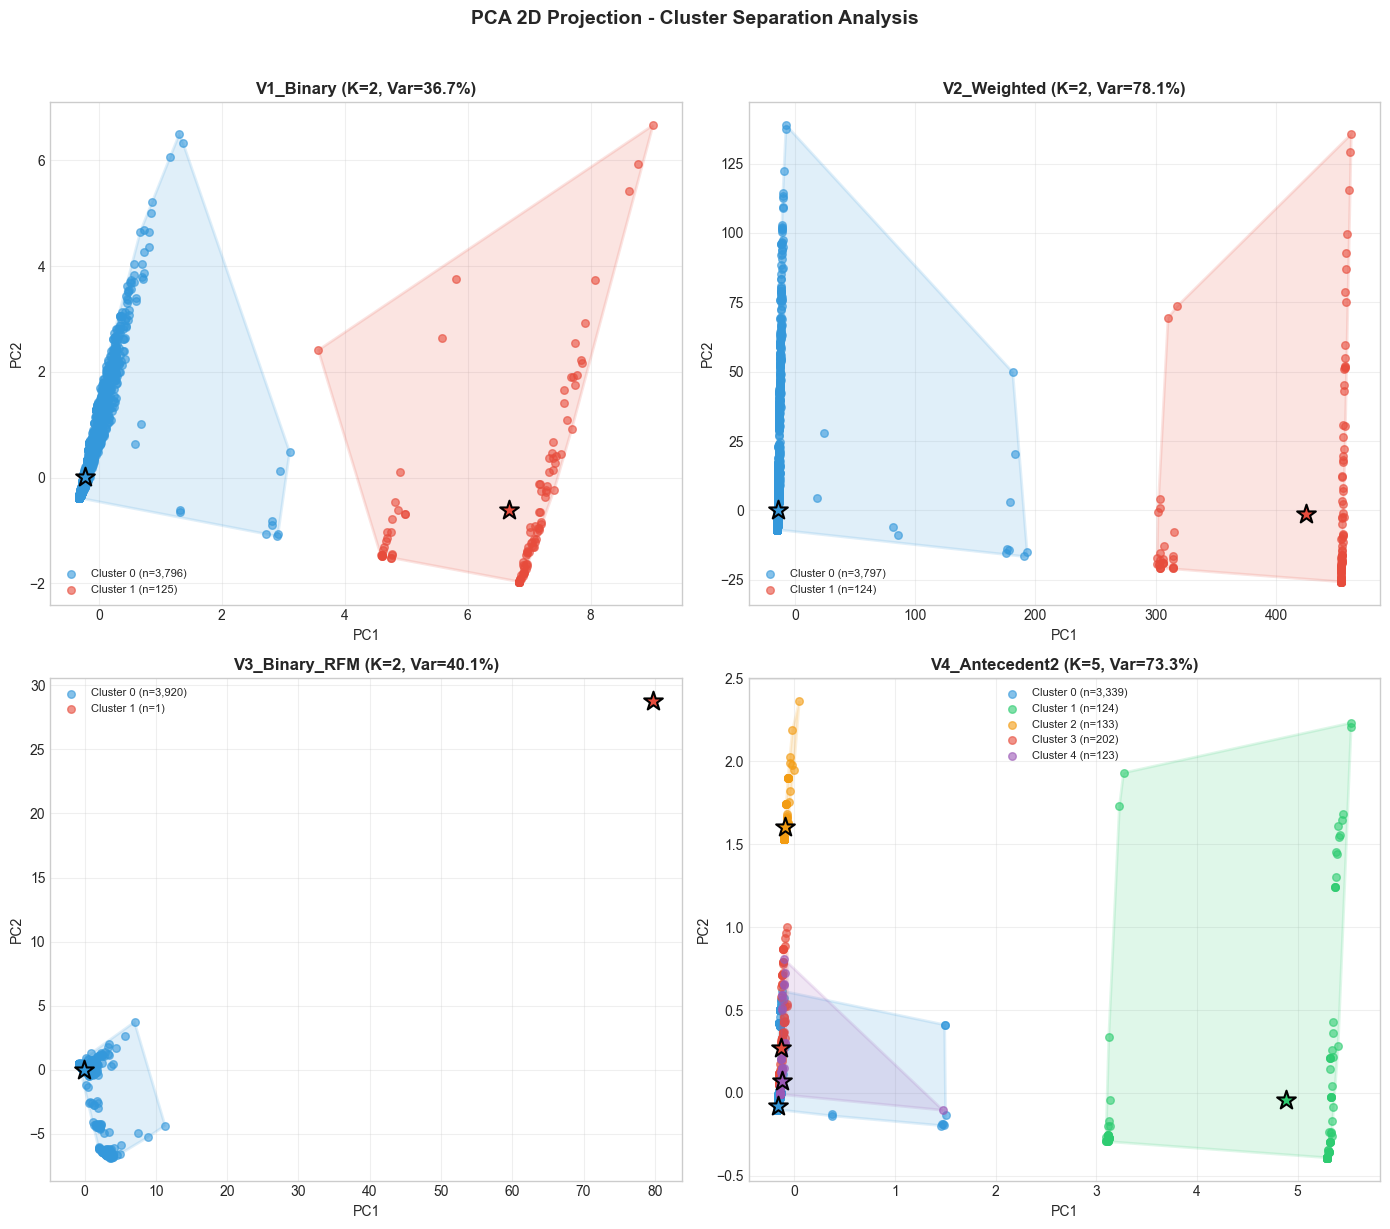


BẢNG TÓM TẮT PCA EXPLAINED VARIANCE


,Variant,K,PC1 (%),PC2 (%),Tổng (%)
0,V1_Binary,2,25.9,10.8,36.7
1,V2_Weighted,2,74.4,3.8,78.1
2,V3_Binary_RFM,2,24.1,16.0,40.1
3,V4_Antecedent2,5,63.7,9.6,73.3


In [117]:
# =============================================================================
# 4.2. PCA - PRINCIPAL COMPONENT ANALYSIS
# =============================================================================
# Giảm chiều về 2D bằng PCA và vẽ scatter plot cho 4 variants

print("="*70)
print("PCA - PRINCIPAL COMPONENT ANALYSIS")
print("="*70)

# -----------------------------------------------------------------------------
# 1. Helper function: Vẽ Convex Hull
# -----------------------------------------------------------------------------
def draw_convex_hull(ax, points, color, alpha=0.2):
    """Vẽ đường bao Convex Hull quanh một nhóm điểm"""
    if len(points) < 3:
        return
    try:
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])
        ax.fill(points[hull_points, 0], points[hull_points, 1], 
                alpha=alpha, color=color, edgecolor=color, linewidth=2)
    except:
        pass  # Bỏ qua nếu không thể vẽ ConvexHull

# -----------------------------------------------------------------------------
# 2. Thực hiện PCA cho 4 variants
# -----------------------------------------------------------------------------
pca_results = {}

print("\n[1] THỰC HIỆN PCA...")
for variant in VARIANT_NAMES:
    X = feature_data[variant]['X']
    
    # Fit PCA
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Z = pca.fit_transform(X)
    
    # Lưu kết quả
    pca_results[variant] = {
        'Z': Z,
        'explained_variance': pca.explained_variance_ratio_,
        'total_variance': sum(pca.explained_variance_ratio_) * 100
    }
    
    var1 = pca.explained_variance_ratio_[0] * 100
    var2 = pca.explained_variance_ratio_[1] * 100
    print(f"  {variant}: PC1={var1:.1f}%, PC2={var2:.1f}%, Tổng={var1+var2:.1f}%")

# -----------------------------------------------------------------------------
# 3. Vẽ Figure 2x2
# -----------------------------------------------------------------------------
print("\n[2] VẼ BIỂU ĐỒ PCA...")

fig, axes = plt.subplots(2, 2, figsize=FIGURE_SIZE)
axes = axes.flatten()

for idx, variant in enumerate(VARIANT_NAMES):
    ax = axes[idx]
    Z = pca_results[variant]['Z']
    labels = cluster_data[variant]
    k = K_VALUES[variant]
    total_var = pca_results[variant]['total_variance']
    
    # Chọn color palette
    colors = COLORS_K2 if k == 2 else COLORS_K5
    
    # Vẽ từng cluster
    for cluster_id in range(k):
        mask = labels == cluster_id
        points = Z[mask]
        color = colors[cluster_id]
        
        # Vẽ Convex Hull trước (để nằm dưới)
        draw_convex_hull(ax, points, color, alpha=0.15)
        
        # Vẽ scatter points
        ax.scatter(points[:, 0], points[:, 1], 
                   c=color, s=MARKER_SIZE, alpha=ALPHA,
                   label=f'Cluster {cluster_id} (n={mask.sum():,})')
        
        # Vẽ centroid
        centroid = points.mean(axis=0)
        ax.scatter(centroid[0], centroid[1], 
                   c=color, s=200, marker='*', 
                   edgecolors='black', linewidths=1.5, zorder=10)
    
    # Title và labels
    ax.set_title(f'{variant} (K={k}, Var={total_var:.1f}%)', fontsize=12, fontweight='bold')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('PCA 2D Projection - Cluster Separation Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Lưu figure
pca_output_path = f"{IMAGES_DIR}/Req4_PCA_ClusterSeparation.png"
plt.savefig(pca_output_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"\n[OK] Đã lưu: {pca_output_path}")

plt.show()

# -----------------------------------------------------------------------------
# 4. Bảng tóm tắt PCA
# -----------------------------------------------------------------------------
print("\n" + "="*70)
print("BẢNG TÓM TẮT PCA EXPLAINED VARIANCE")
print("="*70)

pca_summary = []
for variant in VARIANT_NAMES:
    var_ratio = pca_results[variant]['explained_variance']
    pca_summary.append({
        'Variant': variant,
        'K': K_VALUES[variant],
        'PC1 (%)': f"{var_ratio[0]*100:.1f}",
        'PC2 (%)': f"{var_ratio[1]*100:.1f}",
        'Tổng (%)': f"{(var_ratio[0]+var_ratio[1])*100:.1f}"
    })

df_pca_summary = pd.DataFrame(pca_summary)
display(df_pca_summary)

### 4.3. Dimensionality Reduction: SVD

TRUNCATED SVD - SINGULAR VALUE DECOMPOSITION

[1] THỰC HIỆN SVD...
  V1_Binary: SV1=25.6%, SV2=11.1%, Tổng=36.6%
  V2_Weighted: SV1=74.3%, SV2=3.7%, Tổng=78.1%
  V3_Binary_RFM: SV1=23.9%, SV2=15.9%, Tổng=39.9%
  V4_Antecedent2: SV1=63.6%, SV2=9.6%, Tổng=73.3%

[2] VẼ BIỂU ĐỒ SVD...

[OK] Đã lưu: ../images/Req4_SVD_ClusterSeparation.png


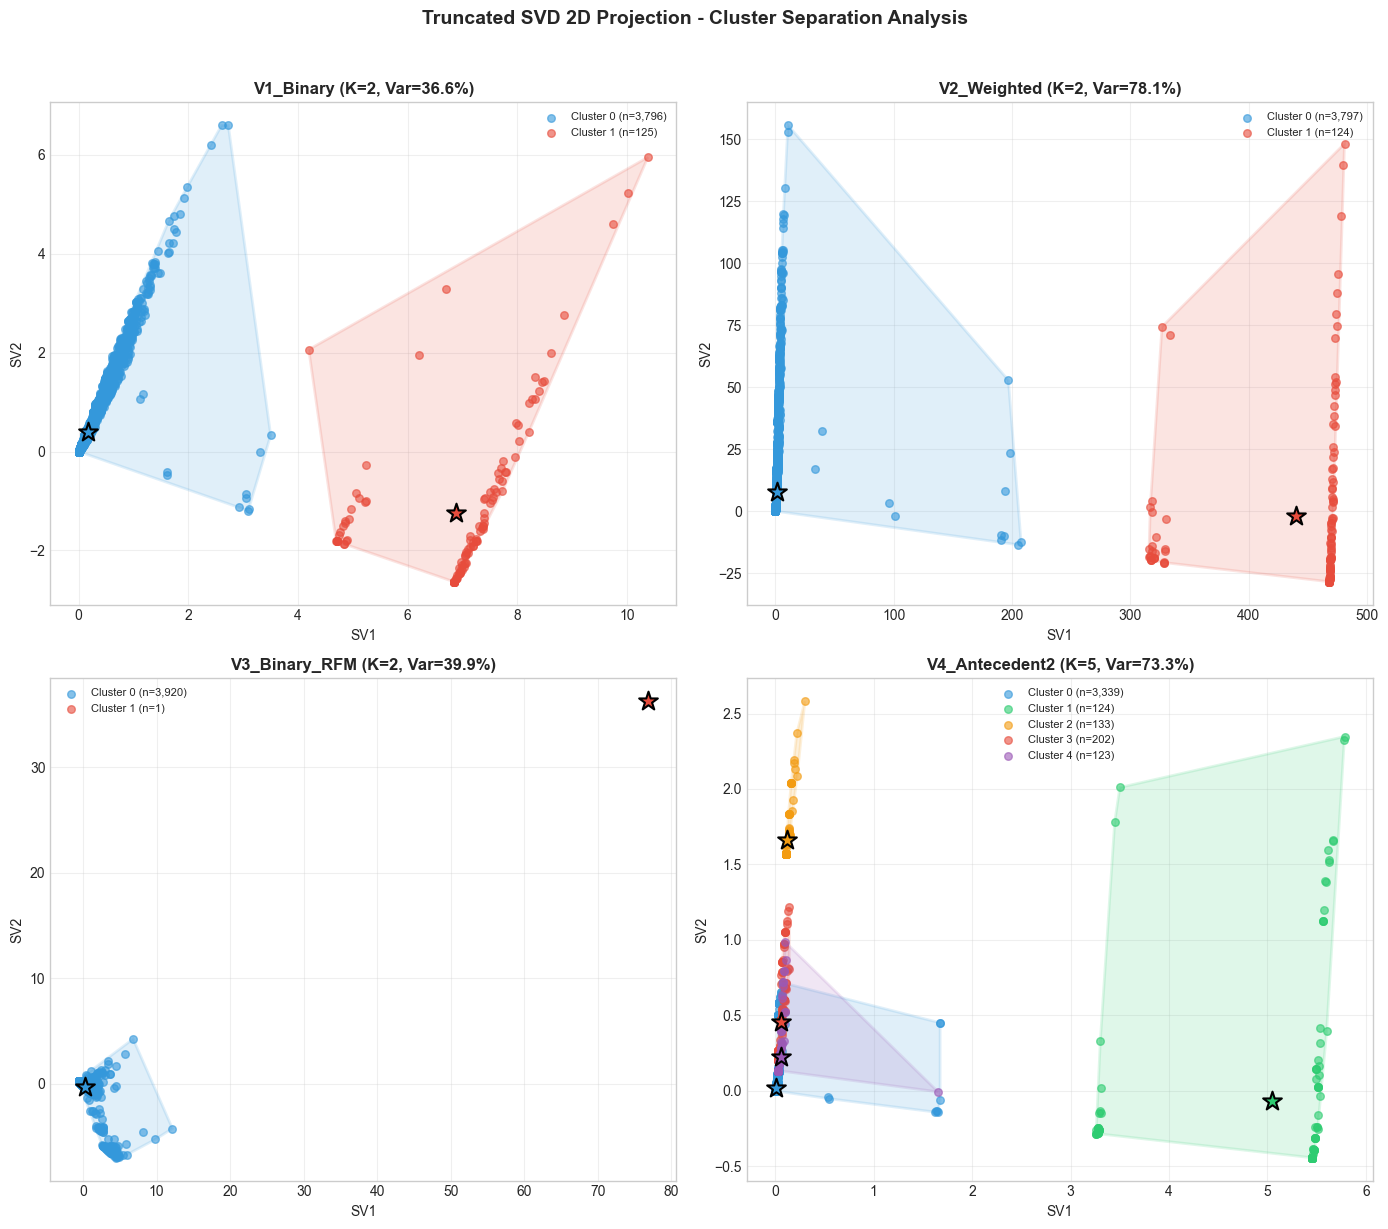


BẢNG TÓM TẮT SVD EXPLAINED VARIANCE


,Variant,K,SV1 (%),SV2 (%),Tổng (%)
0,V1_Binary,2,25.6,11.1,36.6
1,V2_Weighted,2,74.3,3.7,78.1
2,V3_Binary_RFM,2,23.9,15.9,39.9
3,V4_Antecedent2,5,63.6,9.6,73.3


In [118]:
# =============================================================================
# 4.3. SVD - TRUNCATED SINGULAR VALUE DECOMPOSITION
# =============================================================================
# Giảm chiều về 2D bằng TruncatedSVD và vẽ scatter plot cho 4 variants
# SVD phù hợp với sparse data hơn PCA

print("="*70)
print("TRUNCATED SVD - SINGULAR VALUE DECOMPOSITION")
print("="*70)

# -----------------------------------------------------------------------------
# 1. Thực hiện SVD cho 4 variants
# -----------------------------------------------------------------------------
svd_results = {}

print("\n[1] THỰC HIỆN SVD...")
for variant in VARIANT_NAMES:
    X = feature_data[variant]['X']
    
    # Fit TruncatedSVD
    svd = TruncatedSVD(n_components=2, random_state=RANDOM_STATE)
    Z = svd.fit_transform(X)
    
    # Lưu kết quả
    svd_results[variant] = {
        'Z': Z,
        'explained_variance': svd.explained_variance_ratio_,
        'total_variance': sum(svd.explained_variance_ratio_) * 100
    }
    
    var1 = svd.explained_variance_ratio_[0] * 100
    var2 = svd.explained_variance_ratio_[1] * 100
    print(f"  {variant}: SV1={var1:.1f}%, SV2={var2:.1f}%, Tổng={var1+var2:.1f}%")

# -----------------------------------------------------------------------------
# 2. Vẽ Figure 2x2
# -----------------------------------------------------------------------------
print("\n[2] VẼ BIỂU ĐỒ SVD...")

fig, axes = plt.subplots(2, 2, figsize=FIGURE_SIZE)
axes = axes.flatten()

for idx, variant in enumerate(VARIANT_NAMES):
    ax = axes[idx]
    Z = svd_results[variant]['Z']
    labels = cluster_data[variant]
    k = K_VALUES[variant]
    total_var = svd_results[variant]['total_variance']
    
    # Chọn color palette
    colors = COLORS_K2 if k == 2 else COLORS_K5
    
    # Vẽ từng cluster
    for cluster_id in range(k):
        mask = labels == cluster_id
        points = Z[mask]
        color = colors[cluster_id]
        
        # Vẽ Convex Hull trước (để nằm dưới)
        draw_convex_hull(ax, points, color, alpha=0.15)
        
        # Vẽ scatter points
        ax.scatter(points[:, 0], points[:, 1], 
                   c=color, s=MARKER_SIZE, alpha=ALPHA,
                   label=f'Cluster {cluster_id} (n={mask.sum():,})')
        
        # Vẽ centroid
        centroid = points.mean(axis=0)
        ax.scatter(centroid[0], centroid[1], 
                   c=color, s=200, marker='*', 
                   edgecolors='black', linewidths=1.5, zorder=10)
    
    # Title và labels
    ax.set_title(f'{variant} (K={k}, Var={total_var:.1f}%)', fontsize=12, fontweight='bold')
    ax.set_xlabel('SV1')
    ax.set_ylabel('SV2')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Truncated SVD 2D Projection - Cluster Separation Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Lưu figure
svd_output_path = f"{IMAGES_DIR}/Req4_SVD_ClusterSeparation.png"
plt.savefig(svd_output_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"\n[OK] Đã lưu: {svd_output_path}")

plt.show()

# -----------------------------------------------------------------------------
# 3. Bảng tóm tắt SVD
# -----------------------------------------------------------------------------
print("\n" + "="*70)
print("BẢNG TÓM TẮT SVD EXPLAINED VARIANCE")
print("="*70)

svd_summary = []
for variant in VARIANT_NAMES:
    var_ratio = svd_results[variant]['explained_variance']
    svd_summary.append({
        'Variant': variant,
        'K': K_VALUES[variant],
        'SV1 (%)': f"{var_ratio[0]*100:.1f}",
        'SV2 (%)': f"{var_ratio[1]*100:.1f}",
        'Tổng (%)': f"{(var_ratio[0]+var_ratio[1])*100:.1f}"
    })

df_svd_summary = pd.DataFrame(svd_summary)
display(df_svd_summary)

### 4.4. Cluster Separation Analysis

In [121]:
# =============================================================================
# 4.4. CLUSTER SEPARATION ANALYSIS
# =============================================================================
# So sánh mức độ tách cụm giữa 4 variants dựa trên PCA và SVD

print("="*70)
print("PHÂN TÍCH MỨC ĐỘ TÁCH CỤM - SO SÁNH 4 VARIANTS")
print("="*70)

# -----------------------------------------------------------------------------
# 1. Tính khoảng cách giữa các centroid (Inter-cluster distance)
# -----------------------------------------------------------------------------
def calculate_centroid_distance(Z, labels, k):
    """Tính khoảng cách trung bình giữa các centroid"""
    centroids = []
    for i in range(k):
        mask = labels == i
        centroid = Z[mask].mean(axis=0)
        centroids.append(centroid)
    
    # Tính khoảng cách giữa từng cặp centroid
    distances = []
    for i in range(k):
        for j in range(i+1, k):
            dist = np.linalg.norm(centroids[i] - centroids[j])
            distances.append(dist)
    
    return np.mean(distances) if distances else 0

# -----------------------------------------------------------------------------
# 2. Tính độ phân tán trong cụm (Intra-cluster scatter)
# -----------------------------------------------------------------------------
def calculate_intra_scatter(Z, labels, k):
    """Tính độ phân tán trung bình trong các cụm"""
    scatters = []
    for i in range(k):
        mask = labels == i
        if mask.sum() > 1:
            points = Z[mask]
            centroid = points.mean(axis=0)
            scatter = np.mean(np.linalg.norm(points - centroid, axis=1))
            scatters.append(scatter)
    return np.mean(scatters) if scatters else 0

# -----------------------------------------------------------------------------
# 3. Tạo bảng so sánh
# -----------------------------------------------------------------------------
comparison_data = []

for variant in VARIANT_NAMES:
    labels = cluster_data[variant]
    k = K_VALUES[variant]
    
    # PCA metrics
    Z_pca = pca_results[variant]['Z']
    pca_var = pca_results[variant]['total_variance']
    pca_inter = calculate_centroid_distance(Z_pca, labels, k)
    pca_intra = calculate_intra_scatter(Z_pca, labels, k)
    pca_ratio = pca_inter / pca_intra if pca_intra > 0 else 0
    
    # SVD metrics
    Z_svd = svd_results[variant]['Z']
    svd_var = svd_results[variant]['total_variance']
    svd_inter = calculate_centroid_distance(Z_svd, labels, k)
    svd_intra = calculate_intra_scatter(Z_svd, labels, k)
    svd_ratio = svd_inter / svd_intra if svd_intra > 0 else 0
    
    # Đánh giá mức độ tách cụm
    # Dựa trên ratio: Inter/Intra càng cao càng tốt
    avg_ratio = (pca_ratio + svd_ratio) / 2
    if avg_ratio > 2.0:
        separation = "Cao"
    elif avg_ratio > 1.0:
        separation = "Trung bình"
    else:
        separation = "Thấp"
    
    comparison_data.append({
        'Variant': variant,
        'K': k,
        'PCA Var%': f"{pca_var:.1f}",
        'SVD Var%': f"{svd_var:.1f}",
        'PCA Inter/Intra': f"{pca_ratio:.2f}",
        'SVD Inter/Intra': f"{svd_ratio:.2f}",
        'Mức độ tách': separation
    })

df_comparison = pd.DataFrame(comparison_data)

print("\nBẢNG SO SÁNH MỨC ĐỘ TÁCH CỤM:")
print("-" * 70)
display(df_comparison)

PHÂN TÍCH MỨC ĐỘ TÁCH CỤM - SO SÁNH 4 VARIANTS

BẢNG SO SÁNH MỨC ĐỘ TÁCH CỤM:
----------------------------------------------------------------------


,Variant,K,PCA Var%,SVD Var%,PCA Inter/Intra,SVD Inter/Intra,Mức độ tách
0,V1_Binary,2,36.7,36.6,6.44,6.42,Cao
1,V2_Weighted,2,78.1,78.1,12.78,12.70,Cao
2,V3_Binary_RFM,2,40.1,39.9,139.52,132.85,Cao
3,V4_Antecedent2,5,73.3,73.3,9.67,9.20,Cao
